In [13]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import os
import random

seed = 42

In [14]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [15]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
            
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
    else:
        y_scaler = None
        x_scaler = None
        
        
    return x_train, y_train, x_test, y_test 
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [16]:
class RandomizedNetwork(keras.Model):
    
    def __init__(self, input_size, output_size, layers, init=None, reg=None):
        super().__init__()
        
        if init is None:
            init = initializers.RandomNormal(mean=0, stddev=1, seed=None)
        
        self.reg = reg
        
        self.model = Sequential()
                    
            
        units = layers[0]["units"]
        activation = layers[0]["activation"]
        self.model.add(Dense(units, input_dim=input_size, activation=activation,
                    kernel_initializer = init, bias_initializer = init))
        self.model.layers[0].trainable = False
        
        
        
        for layer in layers[1:]:
            activation = layer["activation"]
            units = layer["units"]
            self.model.add(Dense(units, activation=activation, 
                        kernel_initializer = init, bias_initializer = init))
            self.model.layers[-1].trainable = False
        
        self.model.add(Dense(output_size, activation="linear",
                    kernel_initializer = init, bias_initializer = init))
        
        
        self.compile(loss="mse", metrics = mee)
        
        
        
                
    def lms_solve(self, x, y):
        
        n = x.shape[0]
        
        # x_b = np.append(x, np.ones((n,1)), axis=-1)
        for layer in self.model.layers[:-1]:
            x = layer(x)
        
        H = x.numpy()
        H = np.append(H, np.ones((n,1)), axis=-1)
        # H = self.model.layers[0](x).numpy()
        
        # if regularization is used apply direct solution
        if self.reg is not None:
            H_t = H.transpose()
            H = np.matmul(H_t, H)
            I = np.identity(H.shape[0])
            H = H + self.reg*I
            H_star = np.linalg.inv(H)
            W = np.matmul(H_star, H_t)
            W = np.matmul(W, y)
        # if regularization is not used apply numpy LMS solver
        else:
            W, _, _, _ = np.linalg.lstsq(H.T.dot(H), H.T.dot(y))
            
        b = W[-1:][0]
        W = W[:-1]
        
        # print(W.shape)
        # print(b.shape)
        # print(self.model.layers[-1].get_weights()[0].shape)
        # print(self.model.layers[-1].get_weights()[1].shape)
        self.model.layers[-1].set_weights([W, b])

        
    def call(self, x):
        return self.model(x)
    
    def summary(self):
        self.model.summary()
        

In [17]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("initialization")
    keys.remove("trials_train")
    keys.remove("trials_final")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_final"] = params["trials_final"]
        
        configurations.append(dict_conf)
        
        
    return configurations


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

    

def get_model(config, input_size, output_size):
    
    init_method = config["initialization"]["type"]
    reg = config["regularization"]
        
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
        
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1
    
    layers = []
    for l in range(1, n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        layers.append({ 
            "activation": activation,
            "units": n_units
        })
        
    model = RandomizedNetwork(input_size, output_size, layers, init, reg)
        
    return model
    
    

def get_metrics(model, x_train, y_train, x_test=None, y_test=None):
    train_loss, train_metric  = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_metric  = model.evaluate(x_test, y_test, verbose=0) if x_test is not None else [None, None]
    return train_loss, train_metric, test_loss, test_metric
    

def fit_model_k_fold(x_train, y_train, config, n_folds):
    

    train_metric = "mee"
    val_metric = "val_mee"

    trials = config["trials_train"]

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                
                model.lms_solve(x_train_fold, y_train_fold)
                
                trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold)

                trials_val_loss.append(trial_val_loss)
                trials_train_loss.append(trial_train_loss)
                trials_val_acc.append(trial_val_acc)
                trials_train_acc.append(trial_train_acc)

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    train_metric = "mee"
    val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)
            
            pbar.update(1)
    
    # get the mean metrics among the trials
    # med_idx = median_index(trials_val_loss)
    # med_val_loss = trials_val_loss[med_idx]
    # med_train_loss = trials_train_loss[med_idx]
    # med_val_acc = trials_val_acc[med_idx]
    # med_train_acc = trials_train_acc[med_idx]
    
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_final_model(x_train, y_train, config):

    train_metric = "mee"
    val_metric = "val_mee"
    train_loss = "mse"
    val_loss = "mse"

    trials = config["trials_final"]

            
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    models = []
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=None)

    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)
            
            models.append(model)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    med_model = models[med_idx]
    
    
    y_pred = med_model.predict(x_val)
    y_pred = y_scaler.inverse_transform(y_pred)
    y_val = y_scaler.inverse_transform(y_val)

    mse_val = mse(y_val, y_pred)
    mee_val = mee(y_val, y_pred)

    print(f"\nValidation MSE: {mse_val}")
    print(f"Validation MEE: {mee_val}")
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss


def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    global y_scaler
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale: 
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test = y_scaler.inverse_transform(y_test)
    
    
    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)
    
    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)
    
    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
    
    return model

In [18]:
normal = {
    "type": "normal",
    "mean": 0,
    "std": 1
}

unif = {
    "type": "uniform",
    "min": -1,
    "max": 1
}


params = {
    "trials_train": 3,
    "trials_final": 5,
    "initialization": normal,
    "regularization": [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "layers": [
        {
            "activations": ["tanh", "relu"],
            "units": [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        }
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


# ML Cup

In [19]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1194, 9) (1194, 2)
(298, 9) (298, 2)


In [20]:
model = grid_search(params, x_train, y_train, k_fold_val)
assess_model(model, x_train, y_train, x_test, y_test, True)

Testing configuration 1/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 1/4 median val_loss: 0.1933794766664505, std val_loss 0.015375752187117932
Fold 1/4 median train_loss: 0.18534494936466217, std train_loss 0.00824088368202594
Fold 1/4 median val_mee: 0.5196869969367981, std val_mee 0.02214702643221781
Fold 1/4 median train_mee: 0.5154665112495422, train_mee 0.011001002587852332

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 2/4 median val_loss: 0.16199660301208496, std val_loss 0.01740325849075722
Fold 2/4 median train_loss: 0.17843903601169586, std train_loss 0.008989559733092749
Fold 2/4 median val_mee: 0.4637266993522644, std val_mee 0.031351545021695945
Fold 2/4 median train_mee: 0.4949934482574463, train_mee 0.01780430842095329

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 3/4 median val_loss: 0.18953049182891846, std val_loss 0.007562009812819829
Fold 3/4 median train_loss: 0.15216483175754547, std train_loss 0.011061857010139852
Fold 3/4 median val_mee: 0.5133146047592163, std val_mee 0.017908468280539762
Fold 3/4 median train_mee: 0.4658251702785492, train_mee 0.022220369292146862

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 4/4 median val_loss: 0.19900798797607422, std val_loss 0.02017207021332937
Fold 4/4 median train_loss: 0.19817690551280975, std train_loss 0.01125249103092419
Fold 4/4 median val_mee: 0.5140341520309448, std val_mee 0.02374137659267695
Fold 4/4 median train_mee: 0.5370489358901978, train_mee 0.021369087182366905

Mean val_loss: 0.18597863987088203, std val_loss: 0.014250351237332922
Mean train_loss: 0.17853143066167831, std train_loss: 0.01678969024271378
Mean val_mee: 0.5026906132698059, std val_mee: 0.022630779440408748
Mean train_mee: 0.5026906132698059, std train_mee: 0.02626962048073791



Testing configuration 2/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 1/4 median val_loss: 0.13151146471500397, std val_loss 0.002539582207843375
Fold 1/4 median train_loss: 0.1071343794465065, std train_loss 0.003915327551951014
Fold 1/4 median val_mee: 0.4209190011024475, std val_mee 0.0061808718234589
Fold 1/4 median train_mee: 0.3766123950481415, train_mee 0.008264253190900803

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 2/4 median val_loss: 0.11801494657993317, std val_loss 0.006135991486862426
Fold 2/4 median train_loss: 0.10248963534832001, std train_loss 0.0040568534491596175
Fold 2/4 median val_mee: 0.39229846000671387, std val_mee 0.008527802378584248
Fold 2/4 median train_mee: 0.3685755133628845, train_mee 0.010050290844000144

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 3/4 median val_loss: 0.10904231667518616, std val_loss 0.0012709065678940987
Fold 3/4 median train_loss: 0.11963073164224625, std train_loss 0.004288942794827172
Fold 3/4 median val_mee: 0.38120177388191223, std val_mee 0.003834042803427468
Fold 3/4 median train_mee: 0.4005570411682129, train_mee 0.010117977475985834

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 4/4 median val_loss: 0.13255910575389862, std val_loss 0.002677615953346607
Fold 4/4 median train_loss: 0.10938959568738937, std train_loss 0.002517096668466399
Fold 4/4 median val_mee: 0.4188772737979889, std val_mee 0.0075881943701640794
Fold 4/4 median train_mee: 0.3815516531467438, train_mee 0.006894005916205458

Mean val_loss: 0.12278195843100548, std val_loss: 0.009789012300820285
Mean train_loss: 0.10966108553111553, std train_loss: 0.006270595898292851
Mean val_mee: 0.4033241271972656, std val_mee: 0.017047315112129657
Mean train_mee: 0.4033241271972656, std train_mee: 0.01176524785624682



Testing configuration 3/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Fold 1/4 median val_loss: 0.10352315753698349, std val_loss 0.00404099344399749
Fold 1/4 median train_loss: 0.08882589638233185, std train_loss 0.002122094966389512
Fold 1/4 median val_mee: 0.3648441731929779, std val_mee 0.004975994451242569
Fold 1/4 median train_mee: 0.33638590574264526, train_mee 0.004408998482603859

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 2/4 median val_loss: 0.10732033103704453, std val_loss 0.0041655592623241686
Fold 2/4 median train_loss: 0.08454716950654984, std train_loss 0.00224941599183158
Fold 2/4 median val_mee: 0.3665028214454651, std val_mee 0.011105935590987152
Fold 2/4 median train_mee: 0.325490802526474, train_mee 0.005792656853844383

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


Fold 3/4 median val_loss: 0.09404893219470978, std val_loss 0.001708951634981235
Fold 3/4 median train_loss: 0.08577241748571396, std train_loss 0.003333790856940818
Fold 3/4 median val_mee: 0.35292619466781616, std val_mee 0.0011396475956992667
Fold 3/4 median train_mee: 0.3325532078742981, train_mee 0.005085702386500944

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 4/4 median val_loss: 0.12670013308525085, std val_loss 0.003171866042096168
Fold 4/4 median train_loss: 0.08120345324277878, std train_loss 0.0016257443878124457
Fold 4/4 median val_mee: 0.3922531306743622, std val_mee 0.012662425212544924
Fold 4/4 median train_mee: 0.32071512937545776, train_mee 0.005552530298667081

Mean val_loss: 0.10789813846349716, std val_loss: 0.011882653697315436
Mean train_loss: 0.0850872341543436, std train_loss: 0.0027304988301318552
Mean val_mee: 0.36913157999515533, std val_mee: 0.014339742396732563
Mean train_mee: 0.36913157999515533, std train_mee: 0.006081687702020294



Testing configuration 4/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 1/4 median val_loss: 0.11218885332345963, std val_loss 0.0051390840874400625
Fold 1/4 median train_loss: 0.0663951113820076, std train_loss 0.00140747937523817
Fold 1/4 median val_mee: 0.3764011859893799, std val_mee 0.01468809703426473
Fold 1/4 median train_mee: 0.28836098313331604, train_mee 0.0027399249469320756

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 2/4 median val_loss: 0.10474284738302231, std val_loss 0.002018197827899382
Fold 2/4 median train_loss: 0.07098320871591568, std train_loss 0.00037102482225360246
Fold 2/4 median val_mee: 0.35376670956611633, std val_mee 0.005201049486632059
Fold 2/4 median train_mee: 0.29808109998703003, train_mee 0.0005041093152887767

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 3/4 median val_loss: 0.09071935713291168, std val_loss 0.0038922283527576917
Fold 3/4 median train_loss: 0.0751553326845169, std train_loss 0.000667224177700249
Fold 3/4 median val_mee: 0.34421616792678833, std val_mee 0.006323936566826535
Fold 3/4 median train_mee: 0.3051448166370392, train_mee 0.001790398224619959

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 4/4 median val_loss: 0.12713585793972015, std val_loss 0.003741179489315561
Fold 4/4 median train_loss: 0.06544110178947449, std train_loss 0.0007043783293071387
Fold 4/4 median val_mee: 0.4026187062263489, std val_mee 0.0066323238266363955
Fold 4/4 median train_mee: 0.2882530093193054, train_mee 0.0009380023989453615

Mean val_loss: 0.10869672894477844, std val_loss: 0.013143586719715971
Mean train_loss: 0.06949368864297867, std train_loss: 0.0038825740349724695
Mean val_mee: 0.36925069242715836, std val_mee: 0.022533503085888636
Mean train_mee: 0.36925069242715836, std train_mee: 0.00710637922318366



Testing configuration 5/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 1/4 median val_loss: 0.11351629346609116, std val_loss 0.007409260084051565
Fold 1/4 median train_loss: 0.05936092138290405, std train_loss 0.00048100923513852574
Fold 1/4 median val_mee: 0.3845936357975006, std val_mee 0.014652707477863805
Fold 1/4 median train_mee: 0.26867353916168213, train_mee 0.0018607012105532773

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 2/4 median val_loss: 0.13550974428653717, std val_loss 0.007768097232395395
Fold 2/4 median train_loss: 0.05514039099216461, std train_loss 0.0008226875514176324
Fold 2/4 median val_mee: 0.4259118437767029, std val_mee 0.015789961952966294
Fold 2/4 median train_mee: 0.2610006034374237, train_mee 0.002279389030936227

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 3/4 median val_loss: 0.14866727590560913, std val_loss 0.007089611808865627
Fold 3/4 median train_loss: 0.0545942448079586, std train_loss 0.0014178357196951456
Fold 3/4 median val_mee: 0.4386160969734192, std val_mee 0.008526679255343799
Fold 3/4 median train_mee: 0.2640393376350403, train_mee 0.002501635168888232

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.1246487945318222, std val_loss 0.0036447210647964474
Fold 4/4 median train_loss: 0.06138608604669571, std train_loss 0.0009125699739537694
Fold 4/4 median val_mee: 0.4005955159664154, std val_mee 0.004641043508433535
Fold 4/4 median train_mee: 0.2744193971157074, train_mee 0.0018429421978295778

Mean val_loss: 0.13058552704751492, std val_loss: 0.01301730660701709
Mean train_loss: 0.057620410807430744, std train_loss: 0.0028512219315331086
Mean val_mee: 0.4124292731285095, std val_mee: 0.021109180281116587
Mean train_mee: 0.4124292731285095, std train_mee: 0.005064633588500408



Testing configuration 6/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 1/4 median val_loss: 0.14709855616092682, std val_loss 0.0035028738949573024
Fold 1/4 median train_loss: 0.05119527131319046, std train_loss 0.000728815100480311
Fold 1/4 median val_mee: 0.4467102587223053, std val_mee 0.005284693037225834
Fold 1/4 median train_mee: 0.2528669834136963, train_mee 0.0023471347773197492

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 2/4 median val_loss: 0.17434430122375488, std val_loss 0.005857384393135257
Fold 2/4 median train_loss: 0.04780067503452301, std train_loss 0.0008579515249465452
Fold 2/4 median val_mee: 0.4697810709476471, std val_mee 0.003436345371385727
Fold 2/4 median train_mee: 0.2475624531507492, train_mee 0.0015480419929772432

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 3/4 median val_loss: 0.1715041995048523, std val_loss 0.0027753472151308633
Fold 3/4 median train_loss: 0.0465092770755291, std train_loss 0.0013747735017659434
Fold 3/4 median val_mee: 0.4649930000305176, std val_mee 0.0021281513599911792
Fold 3/4 median train_mee: 0.2367299646139145, train_mee 0.0039720151333112064

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 4/4 median val_loss: 0.16938450932502747, std val_loss 0.004431093512444289
Fold 4/4 median train_loss: 0.045136742293834686, std train_loss 0.0009800254246993152
Fold 4/4 median val_mee: 0.46735796332359314, std val_mee 0.009543194818328413
Fold 4/4 median train_mee: 0.24065335094928741, train_mee 0.0006606284840376663

Mean val_loss: 0.16558289155364037, std val_loss: 0.010816042943825512
Mean train_loss: 0.047660491429269314, std train_loss: 0.002247716867057551
Mean val_mee: 0.4622105732560158, std val_mee: 0.009107822313898778
Mean train_mee: 0.4622105732560158, std train_mee: 0.006215835103277484



Testing configuration 7/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 1/4 median val_loss: 0.24069306254386902, std val_loss 0.020654056351746778
Fold 1/4 median train_loss: 0.039401911199092865, std train_loss 0.0011333874322751202
Fold 1/4 median val_mee: 0.5381799936294556, std val_mee 0.034475976566924756
Fold 1/4 median train_mee: 0.21866555511951447, train_mee 0.002969885313385158

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 2/4 median val_loss: 0.22117432951927185, std val_loss 0.013043851055326135
Fold 2/4 median train_loss: 0.03705698251724243, std train_loss 0.0004891450287383278
Fold 2/4 median val_mee: 0.5288823843002319, std val_mee 0.017901587123012166
Fold 2/4 median train_mee: 0.21501509845256805, train_mee 0.0010555315582754215

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 3/4 median val_loss: 0.21621201932430267, std val_loss 0.035621559227035964
Fold 3/4 median train_loss: 0.04048028588294983, std train_loss 0.002059753124942148
Fold 3/4 median val_mee: 0.529876172542572, std val_mee 0.04298621427478253
Fold 3/4 median train_mee: 0.22619035840034485, train_mee 0.005930667356881547

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 4/4 median val_loss: 0.2078855186700821, std val_loss 0.008627805601935035
Fold 4/4 median train_loss: 0.036772049963474274, std train_loss 0.00023861666542204224
Fold 4/4 median val_mee: 0.5198106169700623, std val_mee 0.018413284271908987
Fold 4/4 median train_mee: 0.2121150642633438, train_mee 0.00028958080809937767

Mean val_loss: 0.2214912325143814, std val_loss: 0.012060226418986719
Mean train_loss: 0.03842780739068985, std train_loss: 0.0015638286097089356
Mean val_mee: 0.5291872918605804, std val_mee: 0.006506885628332169
Mean train_mee: 0.5291872918605804, std train_mee: 0.005269416280477457



Testing configuration 8/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 1/4 median val_loss: 0.31108129024505615, std val_loss 0.043296694012328926
Fold 1/4 median train_loss: 0.029092172160744667, std train_loss 0.0020941003003771635
Fold 1/4 median val_mee: 0.6180237531661987, std val_mee 0.03835914534455732
Fold 1/4 median train_mee: 0.18927347660064697, train_mee 0.005054355866203301

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 2/4 median val_loss: 0.37046658992767334, std val_loss 0.007612448813381139
Fold 2/4 median train_loss: 0.031291764229536057, std train_loss 0.0004437398315578162
Fold 2/4 median val_mee: 0.7036570310592651, std val_mee 0.02274721022206292
Fold 2/4 median train_mee: 0.19461654126644135, train_mee 0.0018256427277712943

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 3/4 median val_loss: 0.33964818716049194, std val_loss 0.03547391741224058
Fold 3/4 median train_loss: 0.02994205243885517, std train_loss 0.0008972855953585759
Fold 3/4 median val_mee: 0.6625410318374634, std val_mee 0.02242026850728071
Fold 3/4 median train_mee: 0.19245974719524384, train_mee 0.0022327506219111436

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]


Fold 4/4 median val_loss: 0.3162302076816559, std val_loss 0.013823234516175337
Fold 4/4 median train_loss: 0.030413765460252762, std train_loss 0.0011961808495002725
Fold 4/4 median val_mee: 0.6480686068534851, std val_mee 0.003820092258180394
Fold 4/4 median train_mee: 0.18436741828918457, train_mee 0.0018238018494134362

Mean val_loss: 0.33435656875371933, std val_loss: 0.023464006530838657
Mean train_loss: 0.030184938572347164, std train_loss: 0.0007953862087391057
Mean val_mee: 0.6580726057291031, std val_mee: 0.030829763418146805
Mean train_mee: 0.6580726057291031, std train_mee: 0.0038564243321424878



Testing configuration 9/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


Fold 1/4 median val_loss: 0.6858490109443665, std val_loss 0.10417162797580674
Fold 1/4 median train_loss: 0.021684231236577034, std train_loss 0.0008162300623955408
Fold 1/4 median val_mee: 0.871464729309082, std val_mee 0.07076391918300652
Fold 1/4 median train_mee: 0.16209109127521515, train_mee 0.0022203351012644247

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]


Fold 2/4 median val_loss: 0.771186351776123, std val_loss 0.10542488832922121
Fold 2/4 median train_loss: 0.021574389189481735, std train_loss 0.00016525342636619896
Fold 2/4 median val_mee: 0.9715030789375305, std val_mee 0.05046360993431902
Fold 2/4 median train_mee: 0.15743649005889893, train_mee 0.0006857791255425815

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


Fold 3/4 median val_loss: 0.606844425201416, std val_loss 0.08094015839726659
Fold 3/4 median train_loss: 0.018973033875226974, std train_loss 0.0004553705437054434
Fold 3/4 median val_mee: 0.8653149604797363, std val_mee 0.04683971775210385
Fold 3/4 median train_mee: 0.14950618147850037, train_mee 0.002928449080594636

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


Fold 4/4 median val_loss: 0.5393856167793274, std val_loss 0.06380488923219027
Fold 4/4 median train_loss: 0.017287394031882286, std train_loss 0.0013280361678254372
Fold 4/4 median val_mee: 0.8421486616134644, std val_mee 0.028992638528388442
Fold 4/4 median train_mee: 0.14758393168449402, train_mee 0.002541779694326033

Mean val_loss: 0.6508163511753082, std val_loss: 0.08669856275771795
Mean train_loss: 0.019879762083292007, std train_loss: 0.0018486750736311677
Mean val_mee: 0.8876078575849533, std val_mee: 0.04965511181149226
Mean train_mee: 0.8876078575849533, std train_mee: 0.005885154476716122



Testing configuration 10/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 1/4 median val_loss: 1.3009681701660156, std val_loss 0.20542602324152268
Fold 1/4 median train_loss: 0.011828417889773846, std train_loss 0.0009820214662874741
Fold 1/4 median val_mee: 1.232489824295044, std val_mee 0.0805193836069796
Fold 1/4 median train_mee: 0.11591897904872894, train_mee 0.004329292146394229

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 2/4 median val_loss: 1.4279197454452515, std val_loss 0.13936946750392284
Fold 2/4 median train_loss: 0.010738678276538849, std train_loss 0.0012813065416733059
Fold 2/4 median val_mee: 1.3299371004104614, std val_mee 0.056288870649192885
Fold 2/4 median train_mee: 0.10949332267045975, train_mee 0.006009142852064408

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Fold 3/4 median val_loss: 2.1913535594940186, std val_loss 0.7554156548373447
Fold 3/4 median train_loss: 0.010903319343924522, std train_loss 0.0018297887099819814
Fold 3/4 median val_mee: 1.6183149814605713, std val_mee 0.13617810183589127
Fold 3/4 median train_mee: 0.11300402879714966, train_mee 0.008872469624356949

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


Fold 4/4 median val_loss: 1.9784126281738281, std val_loss 0.1746671170115964
Fold 4/4 median train_loss: 0.010030395351350307, std train_loss 0.0006295603479500977
Fold 4/4 median val_mee: 1.5373716354370117, std val_mee 0.04728543966109348
Fold 4/4 median train_mee: 0.10466130822896957, train_mee 0.0042198564979935745

Mean val_loss: 1.7246635258197784, std val_loss: 0.3707299623950981
Mean train_loss: 0.010875202715396881, std train_loss: 0.0006406535955988792
Mean val_mee: 1.429528385400772, std val_mee: 0.1549299551723792
Mean train_mee: 1.429528385400772, std train_mee: 0.004196691812430342



Testing configuration 11/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]


Fold 1/4 median val_loss: 8.373564720153809, std val_loss 0.8176085962193164
Fold 1/4 median train_loss: 0.0007989590521901846, std train_loss 0.00015690641434488528
Fold 1/4 median val_mee: 2.857985019683838, std val_mee 0.0595249096224192
Fold 1/4 median train_mee: 0.02940177731215954, train_mee 0.0024061137263425318

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Fold 2/4 median val_loss: 5.739272594451904, std val_loss 0.7808473572712861
Fold 2/4 median train_loss: 0.001935208565555513, std train_loss 0.0004235335253975624
Fold 2/4 median val_mee: 2.665844440460205, std val_mee 0.15117869076140242
Fold 2/4 median train_mee: 0.043315399438142776, train_mee 0.005418985985385622

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


Fold 3/4 median val_loss: 7.13478946685791, std val_loss 1.1689786383408822
Fold 3/4 median train_loss: 0.0008750069537200034, std train_loss 0.00023494387408457514
Fold 3/4 median val_mee: 2.7337183952331543, std val_mee 0.11074818593669117
Fold 3/4 median train_mee: 0.030059397220611572, train_mee 0.003717327847279408

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


Fold 4/4 median val_loss: 7.334578514099121, std val_loss 1.034184132594379
Fold 4/4 median train_loss: 0.0011478435480967164, std train_loss 0.00016604891346765592
Fold 4/4 median val_mee: 2.8558413982391357, std val_mee 0.2253660229402727
Fold 4/4 median train_mee: 0.03571401163935661, train_mee 0.001270120354058559

Mean val_loss: 7.145551323890686, std val_loss: 0.9382808564708295
Mean train_loss: 0.0011892545298906043, std train_loss: 0.00044979005985581593
Mean val_mee: 2.7783473134040833, std val_mee: 0.0821525017933974
Mean train_mee: 2.7783473134040833, std train_mee: 0.005586496007636934



Testing configuration 12/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s]


Fold 1/4 median val_loss: 2.679809331893921, std val_loss 0.5212966879808063
Fold 1/4 median train_loss: 1.5750656530144624e-05, std train_loss 8.921888564273236e-06
Fold 1/4 median val_mee: 1.6967521905899048, std val_mee 0.1314826994976511
Fold 1/4 median train_mee: 0.004042171407490969, train_mee 0.0006876489118473897

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]


Fold 2/4 median val_loss: 3.4563143253326416, std val_loss 0.49784293797168394
Fold 2/4 median train_loss: 2.4931390726123936e-05, std train_loss 1.849617297013893e-06
Fold 2/4 median val_mee: 2.0295538902282715, std val_mee 0.11198589223289449
Fold 2/4 median train_mee: 0.004746130667626858, train_mee 9.428706194557692e-05

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


Fold 3/4 median val_loss: 2.4022409915924072, std val_loss 0.6071079741247978
Fold 3/4 median train_loss: 1.7437179849366657e-05, std train_loss 1.0343402176092641e-05
Fold 3/4 median val_mee: 1.7222034931182861, std val_mee 0.13959589265804634
Fold 3/4 median train_mee: 0.004139067605137825, train_mee 0.0010032450695371343

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s]


Fold 4/4 median val_loss: 2.8421123027801514, std val_loss 0.5523963079396885
Fold 4/4 median train_loss: 2.765035242191516e-05, std train_loss 1.9870475701822048e-05
Fold 4/4 median val_mee: 1.8662481307983398, std val_mee 0.13489583171109068
Fold 4/4 median train_mee: 0.005150866229087114, train_mee 0.0014050023930538232

Mean val_loss: 2.8451192378997803, std val_loss: 0.3863408413036463
Mean train_loss: 2.1442394881887594e-05, std train_loss: 4.9786911367677e-06
Mean val_mee: 1.8286894261837006, std val_mee: 0.13276283109852993
Mean train_mee: 1.8286894261837006, std train_mee: 0.00045347440752334524



Testing configuration 13/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 1/4 median val_loss: 0.17484742403030396, std val_loss 0.01900426962351013
Fold 1/4 median train_loss: 0.17300845682621002, std train_loss 0.019718168397670533
Fold 1/4 median val_mee: 0.474111944437027, std val_mee 0.031065656040481688
Fold 1/4 median train_mee: 0.4874313771724701, train_mee 0.02610470886130262

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 2/4 median val_loss: 0.20793014764785767, std val_loss 0.04349953828436574
Fold 2/4 median train_loss: 0.19756734371185303, std train_loss 0.04296626935879299
Fold 2/4 median val_mee: 0.5319615602493286, std val_mee 0.06866317121313359
Fold 2/4 median train_mee: 0.5311571359634399, train_mee 0.07444896354750224

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 3/4 median val_loss: 0.17342786490917206, std val_loss 0.03502127194614858
Fold 3/4 median train_loss: 0.16491301357746124, std train_loss 0.03630095643313898
Fold 3/4 median val_mee: 0.4847467541694641, std val_mee 0.04732720377985337
Fold 3/4 median train_mee: 0.4722464680671692, train_mee 0.054462308524916694

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 4/4 median val_loss: 0.181037038564682, std val_loss 0.04732398970293866
Fold 4/4 median train_loss: 0.19095884263515472, std train_loss 0.035908880604894264
Fold 4/4 median val_mee: 0.49293050169944763, std val_mee 0.055910690414478735
Fold 4/4 median train_mee: 0.511711061000824, train_mee 0.044973854849603985

Mean val_loss: 0.18431061878800392, std val_loss: 0.013933636083676959
Mean train_loss: 0.18161191418766975, std train_loss: 0.01317965821696129
Mean val_mee: 0.49593769013881683, std val_mee: 0.021842404992114827
Mean train_mee: 0.49593769013881683, std train_mee: 0.02255285072341551



Testing configuration 14/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 1/4 median val_loss: 0.10626927763223648, std val_loss 0.0021249736225243112
Fold 1/4 median train_loss: 0.09001137316226959, std train_loss 0.0010423997579778548
Fold 1/4 median val_mee: 0.3701687455177307, std val_mee 0.00222004246088037
Fold 1/4 median train_mee: 0.3362925052642822, train_mee 0.0022521868227730934

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]


Fold 2/4 median val_loss: 0.09641915559768677, std val_loss 0.0030237291757789176
Fold 2/4 median train_loss: 0.09252526611089706, std train_loss 0.0009993604797234536
Fold 2/4 median val_mee: 0.3542068898677826, std val_mee 0.007280463447326271
Fold 2/4 median train_mee: 0.3409563899040222, train_mee 0.0007943511568275387

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Fold 3/4 median val_loss: 0.0905807763338089, std val_loss 0.003060709082471093
Fold 3/4 median train_loss: 0.0938381776213646, std train_loss 0.0012273331987857172
Fold 3/4 median val_mee: 0.33555513620376587, std val_mee 0.009046752159401641
Fold 3/4 median train_mee: 0.342979371547699, train_mee 0.0021792755610410704

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


Fold 4/4 median val_loss: 0.11053190380334854, std val_loss 0.0012654338895659015
Fold 4/4 median train_loss: 0.08698038756847382, std train_loss 0.00130349618815162
Fold 4/4 median val_mee: 0.3600338101387024, std val_mee 0.00371098238349102
Fold 4/4 median train_mee: 0.33380189538002014, train_mee 0.005981727173685165

Mean val_loss: 0.10095027834177017, std val_loss: 0.007876498986748661
Mean train_loss: 0.09083880111575127, std train_loss: 0.002617843373957577
Mean val_mee: 0.3549911454319954, std val_mee: 0.012591281936488865
Mean train_mee: 0.3549911454319954, std train_mee: 0.003641552327421852



Testing configuration 15/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Fold 1/4 median val_loss: 0.09819956123828888, std val_loss 0.004961558422704065
Fold 1/4 median train_loss: 0.08051472157239914, std train_loss 0.001105856939340953
Fold 1/4 median val_mee: 0.3601367771625519, std val_mee 0.009749449202564101
Fold 1/4 median train_mee: 0.3139099180698395, train_mee 0.0011121291587539715

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 2/4 median val_loss: 0.10753436386585236, std val_loss 0.00353419671966587
Fold 2/4 median train_loss: 0.08054725080728531, std train_loss 7.673154465773189e-05
Fold 2/4 median val_mee: 0.3555399775505066, std val_mee 0.007294436851477119
Fold 2/4 median train_mee: 0.3177160322666168, train_mee 0.002459976111570435

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.37it/s]


Fold 3/4 median val_loss: 0.10076483339071274, std val_loss 0.0015258753023224608
Fold 3/4 median train_loss: 0.07823801785707474, std train_loss 0.0010819342567142437
Fold 3/4 median val_mee: 0.3711897134780884, std val_mee 0.004526121230359879
Fold 3/4 median train_mee: 0.31075698137283325, train_mee 0.0050626434742242436

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 4/4 median val_loss: 0.10402790457010269, std val_loss 0.0019942832080844484
Fold 4/4 median train_loss: 0.08089424669742584, std train_loss 0.0005155959879910777
Fold 4/4 median val_mee: 0.3471090495586395, std val_mee 0.0020096503748898366
Fold 4/4 median train_mee: 0.3188264071941376, train_mee 0.002081248688369394

Mean val_loss: 0.10263166576623917, std val_loss: 0.003504088509097484
Mean train_loss: 0.08004855923354626, std train_loss: 0.0010558465767290235
Mean val_mee: 0.3584938794374466, std val_mee: 0.008692283972721449
Mean train_mee: 0.3584938794374466, std train_mee: 0.0031954688164556695



Testing configuration 16/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Fold 1/4 median val_loss: 0.11108691990375519, std val_loss 0.006914794724828242
Fold 1/4 median train_loss: 0.0705924853682518, std train_loss 0.0008660032627476136
Fold 1/4 median val_mee: 0.3813602328300476, std val_mee 0.015107438419629459
Fold 1/4 median train_mee: 0.29519250988960266, train_mee 0.0019369896884776827

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 2/4 median val_loss: 0.10999114066362381, std val_loss 0.008267386418694995
Fold 2/4 median train_loss: 0.06976106017827988, std train_loss 0.0018503356724067434
Fold 2/4 median val_mee: 0.3686669170856476, std val_mee 0.01025876062925038
Fold 2/4 median train_mee: 0.2989291548728943, train_mee 0.003975034770115227

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Fold 3/4 median val_loss: 0.12121890485286713, std val_loss 0.002821949305042258
Fold 3/4 median train_loss: 0.067478708922863, std train_loss 0.00031147490733570506
Fold 3/4 median val_mee: 0.38153237104415894, std val_mee 0.006403144164204165
Fold 3/4 median train_mee: 0.2909824848175049, train_mee 0.0006836387262209872

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Fold 4/4 median val_loss: 0.1000588983297348, std val_loss 0.002440871068884303
Fold 4/4 median train_loss: 0.07233430445194244, std train_loss 0.0005353518298985365
Fold 4/4 median val_mee: 0.3647884726524353, std val_mee 0.004409575844997963
Fold 4/4 median train_mee: 0.298570841550827, train_mee 0.0003716994349321064

Mean val_loss: 0.11058896593749523, std val_loss: 0.007491383022832579
Mean train_loss: 0.07004163973033428, std train_loss: 0.0017469317138511598
Mean val_mee: 0.37408699840307236, std val_mee: 0.007486210246465431
Mean train_mee: 0.37408699840307236, std train_mee: 0.0032011820372542703



Testing configuration 17/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Fold 1/4 median val_loss: 0.12121426314115524, std val_loss 0.004608706769414091
Fold 1/4 median train_loss: 0.06042306870222092, std train_loss 0.0002621940002560966
Fold 1/4 median val_mee: 0.396675169467926, std val_mee 0.007236778409281353
Fold 1/4 median train_mee: 0.27288520336151123, train_mee 0.0028526551092049103

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


Fold 2/4 median val_loss: 0.1325307935476303, std val_loss 0.005340802062469531
Fold 2/4 median train_loss: 0.05625481903553009, std train_loss 0.0015650492693645933
Fold 2/4 median val_mee: 0.42661577463150024, std val_mee 0.005302026241574785
Fold 2/4 median train_mee: 0.2668890953063965, train_mee 0.0042794040814160056

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 0.14524121582508087, std val_loss 0.004840374943799779
Fold 3/4 median train_loss: 0.058599378913640976, std train_loss 0.0006196382631914781
Fold 3/4 median val_mee: 0.42689695954322815, std val_mee 0.004715616119113581
Fold 3/4 median train_mee: 0.2714044451713562, train_mee 0.0012705648851604435

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


Fold 4/4 median val_loss: 0.122695691883564, std val_loss 0.004190291665921612
Fold 4/4 median train_loss: 0.060417406260967255, std train_loss 0.0015961468089329852
Fold 4/4 median val_mee: 0.401489794254303, std val_mee 0.007099646945599855
Fold 4/4 median train_mee: 0.2785259783267975, train_mee 0.004050225863494243

Mean val_loss: 0.1304204910993576, std val_loss: 0.00959862508333307
Mean train_loss: 0.05892366822808981, std train_loss: 0.0017108020534811683
Mean val_mee: 0.41291942447423935, std val_mee: 0.013941608245730928
Mean train_mee: 0.41291942447423935, std train_mee: 0.004156966773929502



Testing configuration 18/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 1/4 median val_loss: 0.1500251591205597, std val_loss 0.007236915966290832
Fold 1/4 median train_loss: 0.0496540293097496, std train_loss 0.0003798427405933017
Fold 1/4 median val_mee: 0.44542375206947327, std val_mee 0.010769345262708674
Fold 1/4 median train_mee: 0.2507982850074768, train_mee 0.001939782871552701

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Fold 2/4 median val_loss: 0.18632137775421143, std val_loss 0.004105361423413058
Fold 2/4 median train_loss: 0.05029286816716194, std train_loss 0.0014522351215821713
Fold 2/4 median val_mee: 0.5069171786308289, std val_mee 0.0016358524040276962
Fold 2/4 median train_mee: 0.25005823373794556, train_mee 0.003484778364568733

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 3/4 median val_loss: 0.16059134900569916, std val_loss 0.00026385192674396516
Fold 3/4 median train_loss: 0.05170983076095581, std train_loss 0.0008141361238835236
Fold 3/4 median val_mee: 0.4669908583164215, std val_mee 0.004771009249768731
Fold 3/4 median train_mee: 0.256279319524765, train_mee 0.0013187334592217781

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 4/4 median val_loss: 0.16758613288402557, std val_loss 0.010444329030774644
Fold 4/4 median train_loss: 0.05250704288482666, std train_loss 0.0018693897592835054
Fold 4/4 median val_mee: 0.45981866121292114, std val_mee 0.014735713008632812
Fold 4/4 median train_mee: 0.25314438343048096, train_mee 0.006160883594996077

Mean val_loss: 0.16613100469112396, std val_loss: 0.013227382669488596
Mean train_loss: 0.051040942780673504, std train_loss: 0.001126943349150113
Mean val_mee: 0.4697876125574112, std val_mee: 0.022800242322557094
Mean train_mee: 0.4697876125574112, std train_mee: 0.0024257427429373378



Testing configuration 19/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 1/4 median val_loss: 0.2157241702079773, std val_loss 0.016304302151529983
Fold 1/4 median train_loss: 0.04322338476777077, std train_loss 0.0001538221240738728
Fold 1/4 median val_mee: 0.5204072594642639, std val_mee 0.012045434314447072
Fold 1/4 median train_mee: 0.2338705211877823, train_mee 0.001350695002078544

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 2/4 median val_loss: 0.23050041496753693, std val_loss 0.01386907318009552
Fold 2/4 median train_loss: 0.04111728072166443, std train_loss 0.0012984689546414459
Fold 2/4 median val_mee: 0.5397570729255676, std val_mee 0.023476095594404032
Fold 2/4 median train_mee: 0.22960709035396576, train_mee 0.0033053502857324853

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 3/4 median val_loss: 0.22027431428432465, std val_loss 0.006699102217245968
Fold 3/4 median train_loss: 0.037751615047454834, std train_loss 0.001079155898296129
Fold 3/4 median val_mee: 0.5445647835731506, std val_mee 0.003560132121597188
Fold 3/4 median train_mee: 0.22093845903873444, train_mee 0.0034703533927098584

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s]


Fold 4/4 median val_loss: 0.24858307838439941, std val_loss 0.014664209127207952
Fold 4/4 median train_loss: 0.039143241941928864, std train_loss 0.00045364061478565874
Fold 4/4 median val_mee: 0.5829336047172546, std val_mee 0.010642029727738781
Fold 4/4 median train_mee: 0.22398781776428223, train_mee 0.0015620544334556028

Mean val_loss: 0.22877049446105957, std val_loss: 0.012628566434776174
Mean train_loss: 0.04030888061970472, std train_loss: 0.0020643501330978383
Mean val_mee: 0.5469156801700592, std val_mee: 0.022675755938298636
Mean train_mee: 0.5469156801700592, std train_mee: 0.0049943898702199205



Testing configuration 20/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 1/4 median val_loss: 0.3364776074886322, std val_loss 0.0077796513248224505
Fold 1/4 median train_loss: 0.033514149487018585, std train_loss 0.0005796505406583224
Fold 1/4 median val_mee: 0.6566840410232544, std val_mee 0.006881279520734964
Fold 1/4 median train_mee: 0.20360125601291656, train_mee 0.00207701126879475

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 2/4 median val_loss: 0.4036610722541809, std val_loss 0.03349646032982741
Fold 2/4 median train_loss: 0.028067275881767273, std train_loss 0.0006830293296555083
Fold 2/4 median val_mee: 0.7103737592697144, std val_mee 0.022127443410080543
Fold 2/4 median train_mee: 0.18637199699878693, train_mee 0.003277633464534925

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Fold 3/4 median val_loss: 0.3509238064289093, std val_loss 0.03476217514979089
Fold 3/4 median train_loss: 0.03205754607915878, std train_loss 0.0019420800901882476
Fold 3/4 median val_mee: 0.6993076205253601, std val_mee 0.037272240491185465
Fold 3/4 median train_mee: 0.1997363567352295, train_mee 0.005148331793943724

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 4/4 median val_loss: 0.3957977294921875, std val_loss 0.025041018848193076
Fold 4/4 median train_loss: 0.030585722997784615, std train_loss 0.0011776901061840938
Fold 4/4 median val_mee: 0.7022927403450012, std val_mee 0.025612258741243336
Fold 4/4 median train_mee: 0.19645075500011444, train_mee 0.0032196529434093736

Mean val_loss: 0.3717150539159775, std val_loss: 0.028611522824564754
Mean train_loss: 0.031056173611432314, std train_loss: 0.0020124130814996102
Mean val_mee: 0.6921645402908325, std val_mee: 0.02088088549171014
Mean train_mee: 0.6921645402908325, std train_mee: 0.006392853090135496



Testing configuration 21/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 1/4 median val_loss: 0.5845128893852234, std val_loss 0.21210286016924496
Fold 1/4 median train_loss: 0.02236771211028099, std train_loss 0.0009273765893065225
Fold 1/4 median val_mee: 0.8689263463020325, std val_mee 0.10002574135601164
Fold 1/4 median train_mee: 0.16663827002048492, train_mee 0.0016037780954886996

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 2/4 median val_loss: 0.763398289680481, std val_loss 0.21599657665234478
Fold 2/4 median train_loss: 0.021482300013303757, std train_loss 0.0007227138712119959
Fold 2/4 median val_mee: 0.9916881322860718, std val_mee 0.07899078518801995
Fold 2/4 median train_mee: 0.16184024512767792, train_mee 0.004754405664667591

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 3/4 median val_loss: 0.6161398887634277, std val_loss 0.11927948664445377
Fold 3/4 median train_loss: 0.02050918899476528, std train_loss 0.00012118531552873465
Fold 3/4 median val_mee: 0.8465043306350708, std val_mee 0.06048163648875587
Fold 3/4 median train_mee: 0.1611476093530655, train_mee 0.0013944915338882774

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s]


Fold 4/4 median val_loss: 0.7928646802902222, std val_loss 0.0768206824114887
Fold 4/4 median train_loss: 0.019959036260843277, std train_loss 0.0017193861139949132
Fold 4/4 median val_mee: 1.013965368270874, std val_mee 0.045896728314797026
Fold 4/4 median train_mee: 0.15675854682922363, train_mee 0.004624476182943665

Mean val_loss: 0.6892289370298386, std val_loss: 0.09020659588487218
Mean train_loss: 0.021079559344798326, std train_loss: 0.0009222841090414858
Mean val_mee: 0.9302710443735123, std val_mee: 0.07341122675094487
Mean train_mee: 0.9302710443735123, std train_mee: 0.0035030754302796912



Testing configuration 22/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 1/4 median val_loss: 1.8887532949447632, std val_loss 0.24812870351313188
Fold 1/4 median train_loss: 0.010764159262180328, std train_loss 0.0004927246161356071
Fold 1/4 median val_mee: 1.4990230798721313, std val_mee 0.04644356626123822
Fold 1/4 median train_mee: 0.11423476040363312, train_mee 0.003005539632581405

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


Fold 2/4 median val_loss: 1.792627215385437, std val_loss 0.051883357589067106
Fold 2/4 median train_loss: 0.012275622226297855, std train_loss 0.0010993323939897353
Fold 2/4 median val_mee: 1.499548316001892, std val_mee 0.03525503833537829
Fold 2/4 median train_mee: 0.11913390457630157, train_mee 0.0045250264097198584

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 3/4 median val_loss: 1.8138790130615234, std val_loss 0.11081357822293854
Fold 3/4 median train_loss: 0.011436308734118938, std train_loss 0.000535013061249774
Fold 3/4 median val_mee: 1.454689383506775, std val_mee 0.030558437007923513
Fold 3/4 median train_mee: 0.11656685173511505, train_mee 0.0016061320200006415

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 4/4 median val_loss: 1.3650202751159668, std val_loss 0.22590040483186669
Fold 4/4 median train_loss: 0.010751674883067608, std train_loss 0.0006505038381162308
Fold 4/4 median val_mee: 1.307302713394165, std val_mee 0.0903216078920992
Fold 4/4 median train_mee: 0.11001498997211456, train_mee 0.004791319083131766

Mean val_loss: 1.7150699496269226, std val_loss: 0.20523099154049698
Mean train_loss: 0.011306941276416183, std train_loss: 0.0006241017153350084
Mean val_mee: 1.4401408731937408, std val_mee: 0.07882574829265268
Mean train_mee: 1.4401408731937408, std train_mee: 0.003353337726309505



Testing configuration 23/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 1/4 median val_loss: 5.537293910980225, std val_loss 0.6607582276694711
Fold 1/4 median train_loss: 0.001353582483716309, std train_loss 0.00016705057054824618
Fold 1/4 median val_mee: 2.4155142307281494, std val_mee 0.13645320719641904
Fold 1/4 median train_mee: 0.039308350533246994, train_mee 0.0021844645343707127

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


Fold 2/4 median val_loss: 6.894921779632568, std val_loss 0.8350891159313688
Fold 2/4 median train_loss: 0.0014309558318927884, std train_loss 0.00014144266598724618
Fold 2/4 median val_mee: 2.8650732040405273, std val_mee 0.14706309850898916
Fold 2/4 median train_mee: 0.039995405822992325, train_mee 0.0018604084946350495

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


Fold 3/4 median val_loss: 6.988641738891602, std val_loss 1.0788338958522026
Fold 3/4 median train_loss: 0.0009880895959213376, std train_loss 4.9973750652558874e-05
Fold 3/4 median val_mee: 2.7808470726013184, std val_mee 0.19748330018405072
Fold 3/4 median train_mee: 0.03255631774663925, train_mee 0.0015541289476521116

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.37it/s]


Fold 4/4 median val_loss: 6.735208511352539, std val_loss 1.1223948452920454
Fold 4/4 median train_loss: 0.0012315185740590096, std train_loss 6.293518550707677e-05
Fold 4/4 median val_mee: 2.695777654647827, std val_mee 0.2247327020503331
Fold 4/4 median train_mee: 0.0357748344540596, train_mee 0.0004938300279142489

Mean val_loss: 6.539016485214233, std val_loss: 0.5853996229477992
Mean train_loss: 0.0012510366213973612, std train_loss: 0.00016763701005642013
Mean val_mee: 2.6893030405044556, std val_mee: 0.16902491916066753
Mean train_mee: 2.6893030405044556, std train_mee: 0.0029797213742270207



Testing configuration 24/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 1/4 median val_loss: 3.511943817138672, std val_loss 0.4567894779451661
Fold 1/4 median train_loss: 3.9063463191268966e-05, std train_loss 7.373953590299466e-06
Fold 1/4 median val_mee: 2.0563478469848633, std val_mee 0.060612976567620616
Fold 1/4 median train_mee: 0.006392025854438543, train_mee 0.0005861649318687972

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


Fold 2/4 median val_loss: 2.5280704498291016, std val_loss 0.2981916961204019
Fold 2/4 median train_loss: 3.6169352824799716e-05, std train_loss 8.170921694569887e-06
Fold 2/4 median val_mee: 1.7730172872543335, std val_mee 0.07153528073552522
Fold 2/4 median train_mee: 0.006155882030725479, train_mee 0.0005535900483240589

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]


Fold 3/4 median val_loss: 3.0726141929626465, std val_loss 0.629611334441153
Fold 3/4 median train_loss: 2.3093161871656775e-05, std train_loss 1.2409641612731694e-05
Fold 3/4 median val_mee: 1.8475255966186523, std val_mee 0.18696549300787685
Fold 3/4 median train_mee: 0.004961166996508837, train_mee 0.0009068828094863932

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


Fold 4/4 median val_loss: 2.103533983230591, std val_loss 0.2708565608785526
Fold 4/4 median train_loss: 2.95637237286428e-05, std train_loss 8.037168193820653e-06
Fold 4/4 median val_mee: 1.6650753021240234, std val_mee 0.0952469941694991
Fold 4/4 median train_mee: 0.005389633122831583, train_mee 0.0007526796128669357

Mean val_loss: 2.8040406107902527, std val_loss: 0.5338838318387293
Mean train_loss: 3.1972425404092064e-05, std train_loss: 6.175357910955562e-06
Mean val_mee: 1.8354915082454681, std val_mee: 0.14306209599472874
Mean train_mee: 1.8354915082454681, std train_mee: 0.0005758676490962396



Testing configuration 25/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


Fold 1/4 median val_loss: 0.189042329788208, std val_loss 0.02251665331633485
Fold 1/4 median train_loss: 0.19901832938194275, std train_loss 0.022553921219004073
Fold 1/4 median val_mee: 0.5124720931053162, std val_mee 0.04486240825944139
Fold 1/4 median train_mee: 0.5264628529548645, train_mee 0.04172496166698347

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 2/4 median val_loss: 0.17658112943172455, std val_loss 0.013302469473623253
Fold 2/4 median train_loss: 0.180013969540596, std train_loss 0.014082113704998376
Fold 2/4 median val_mee: 0.4969247281551361, std val_mee 0.013839520584177976
Fold 2/4 median train_mee: 0.508213222026825, train_mee 0.00936260660741157

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Fold 3/4 median val_loss: 0.2048877477645874, std val_loss 0.0273164303205666
Fold 3/4 median train_loss: 0.20583494007587433, std train_loss 0.03713528020000072
Fold 3/4 median val_mee: 0.5356593728065491, std val_mee 0.04325171815829489
Fold 3/4 median train_mee: 0.543904185295105, train_mee 0.05680790840316001

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


Fold 4/4 median val_loss: 0.1839285045862198, std val_loss 0.022831892804890175
Fold 4/4 median train_loss: 0.16578280925750732, std train_loss 0.015002303910118413
Fold 4/4 median val_mee: 0.5043671131134033, std val_mee 0.030362895083997695
Fold 4/4 median train_mee: 0.48989829421043396, train_mee 0.026426330682404412

Mean val_loss: 0.18860992789268494, std val_loss: 0.010389443052566302
Mean train_loss: 0.1876625120639801, std train_loss: 0.015783007669943692
Mean val_mee: 0.5123558267951012, std val_mee: 0.014534503139831083
Mean train_mee: 0.5123558267951012, std train_mee: 0.020155851772459845



Testing configuration 26/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 1/4 median val_loss: 0.10935572534799576, std val_loss 0.005336520572076343
Fold 1/4 median train_loss: 0.10026518255472183, std train_loss 0.003589005282328379
Fold 1/4 median val_mee: 0.3795784115791321, std val_mee 0.00795899764736378
Fold 1/4 median train_mee: 0.3573760390281677, train_mee 0.008501427884910736

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 2/4 median val_loss: 0.12611238658428192, std val_loss 0.008457267339094144
Fold 2/4 median train_loss: 0.11748271435499191, std train_loss 0.007090487383627189
Fold 2/4 median val_mee: 0.4147346615791321, std val_mee 0.017174354787585413
Fold 2/4 median train_mee: 0.3903873860836029, train_mee 0.011387390032329463

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.49it/s]


Fold 3/4 median val_loss: 0.10401295125484467, std val_loss 0.001993456553400391
Fold 3/4 median train_loss: 0.09984338283538818, std train_loss 0.0031154762821938788
Fold 3/4 median val_mee: 0.36092647910118103, std val_mee 0.004862236530308718
Fold 3/4 median train_mee: 0.3630405366420746, train_mee 0.006461572816178376

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


Fold 4/4 median val_loss: 0.131869375705719, std val_loss 0.0019902840246128943
Fold 4/4 median train_loss: 0.09900739043951035, std train_loss 0.0019406379131751087
Fold 4/4 median val_mee: 0.39771220088005066, std val_mee 0.004172733923516949
Fold 4/4 median train_mee: 0.3579888641834259, train_mee 0.0038236998632021507

Mean val_loss: 0.11783760972321033, std val_loss: 0.01149375844763014
Mean train_loss: 0.10414966754615307, std train_loss: 0.007711135822740569
Mean val_mee: 0.38823793828487396, std val_mee: 0.020079474610686574
Mean train_mee: 0.38823793828487396, std train_mee: 0.01356752766863449



Testing configuration 27/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 1/4 median val_loss: 0.10840859264135361, std val_loss 0.0036195502437400503
Fold 1/4 median train_loss: 0.08469588309526443, std train_loss 0.0009394471766828843
Fold 1/4 median val_mee: 0.3686116635799408, std val_mee 0.006550288265682196
Fold 1/4 median train_mee: 0.32539835572242737, train_mee 0.001125662590703173

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 2/4 median val_loss: 0.12052606046199799, std val_loss 0.003464035175229902
Fold 2/4 median train_loss: 0.07943674176931381, std train_loss 0.004002666975563212
Fold 2/4 median val_mee: 0.39128512144088745, std val_mee 0.005381334871168871
Fold 2/4 median train_mee: 0.3175537586212158, train_mee 0.009476503466761156

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 0.09812480211257935, std val_loss 0.0066870595454865496
Fold 3/4 median train_loss: 0.0914587453007698, std train_loss 0.002019513183768635
Fold 3/4 median val_mee: 0.3558811843395233, std val_mee 0.008787109727020502
Fold 3/4 median train_mee: 0.3388891816139221, train_mee 0.0035764205750767387

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 4/4 median val_loss: 0.10608657449483871, std val_loss 0.0059448703209304225
Fold 4/4 median train_loss: 0.09006675332784653, std train_loss 0.001990157058958663
Fold 4/4 median val_mee: 0.3697259724140167, std val_mee 0.006328936769856171
Fold 4/4 median train_mee: 0.3379308879375458, train_mee 0.004038650809259912

Mean val_loss: 0.10828650742769241, std val_loss: 0.008029967669599064
Mean train_loss: 0.08641453087329865, std train_loss: 0.004754632451947347
Mean val_mee: 0.37137598544359207, std val_mee: 0.012716392725308168
Mean train_mee: 0.37137598544359207, std train_mee: 0.008916103587260873



Testing configuration 28/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 1/4 median val_loss: 0.10573537647724152, std val_loss 0.0020310847637976265
Fold 1/4 median train_loss: 0.06940506398677826, std train_loss 0.0003194728771965089
Fold 1/4 median val_mee: 0.36594825983047485, std val_mee 0.006327360944012607
Fold 1/4 median train_mee: 0.2953368127346039, train_mee 0.002222915177438675

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 2/4 median val_loss: 0.11082087457180023, std val_loss 0.00043494630695580086
Fold 2/4 median train_loss: 0.07087573409080505, std train_loss 0.001221262595275287
Fold 2/4 median val_mee: 0.36884722113609314, std val_mee 0.00219473755319194
Fold 2/4 median train_mee: 0.29490113258361816, train_mee 0.0012510893604246677

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.1141660287976265, std val_loss 0.0029832283352010714
Fold 3/4 median train_loss: 0.07108693569898605, std train_loss 0.00020433582154728646
Fold 3/4 median val_mee: 0.3682115375995636, std val_mee 0.0035759567408334618
Fold 3/4 median train_mee: 0.29860132932662964, train_mee 0.0011035353172362027

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 4/4 median val_loss: 0.12671911716461182, std val_loss 0.002685285735717984
Fold 4/4 median train_loss: 0.06649808585643768, std train_loss 0.0005589578448698981
Fold 4/4 median val_mee: 0.3941602408885956, std val_mee 0.005781175540277461
Fold 4/4 median train_mee: 0.29137247800827026, train_mee 0.0022839748091864694

Mean val_loss: 0.11436034925282001, std val_loss: 0.007741042260798795
Mean train_loss: 0.06946645490825176, std train_loss: 0.0018321442001466403
Mean val_mee: 0.3742918148636818, std val_mee: 0.011521530234377231
Mean train_mee: 0.3742918148636818, std train_mee: 0.0025612739265360156



Testing configuration 29/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 1/4 median val_loss: 0.130204439163208, std val_loss 0.009809836408959188
Fold 1/4 median train_loss: 0.058236923068761826, std train_loss 0.0017727915616341516
Fold 1/4 median val_mee: 0.41060391068458557, std val_mee 0.005867930270139136
Fold 1/4 median train_mee: 0.26762861013412476, train_mee 0.003017934551478202

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


Fold 2/4 median val_loss: 0.12616972625255585, std val_loss 0.004960016377314595
Fold 2/4 median train_loss: 0.059673819690942764, std train_loss 0.0008703311827924631
Fold 2/4 median val_mee: 0.4191039204597473, std val_mee 0.0060656065974865935
Fold 2/4 median train_mee: 0.2657413184642792, train_mee 0.0007376915567229386

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 3/4 median val_loss: 0.13632261753082275, std val_loss 0.0026447167280661773
Fold 3/4 median train_loss: 0.05420758202672005, std train_loss 0.0006990267869937467
Fold 3/4 median val_mee: 0.4045380651950836, std val_mee 0.003624370584930126
Fold 3/4 median train_mee: 0.26009947061538696, train_mee 0.002877708363352619

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 4/4 median val_loss: 0.1229105219244957, std val_loss 0.002589762100544615
Fold 4/4 median train_loss: 0.06257227063179016, std train_loss 0.0019801283074551237
Fold 4/4 median val_mee: 0.3957239091396332, std val_mee 0.0046837597823579016
Fold 4/4 median train_mee: 0.27523431181907654, train_mee 0.0023722062932012332

Mean val_loss: 0.12890182621777058, std val_loss: 0.005003125062199429
Mean train_loss: 0.0586726488545537, std train_loss: 0.0030139704621378284
Mean val_mee: 0.4074924513697624, std val_mee: 0.00854011676423313
Mean train_mee: 0.4074924513697624, std train_mee: 0.005414721242278673



Testing configuration 30/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 1/4 median val_loss: 0.15907621383666992, std val_loss 0.008808972637983688
Fold 1/4 median train_loss: 0.044193822890520096, std train_loss 0.0006489284726161588
Fold 1/4 median val_mee: 0.45437589287757874, std val_mee 0.02188618639561668
Fold 1/4 median train_mee: 0.2369021475315094, train_mee 0.0007601459334906919

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 2/4 median val_loss: 0.16466917097568512, std val_loss 0.012394460400081412
Fold 2/4 median train_loss: 0.047299906611442566, std train_loss 0.00019224743901406657
Fold 2/4 median val_mee: 0.463411420583725, std val_mee 0.014985840246548957
Fold 2/4 median train_mee: 0.24733708798885345, train_mee 0.002291873663202952

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


Fold 3/4 median val_loss: 0.13816888630390167, std val_loss 0.009231819789028891
Fold 3/4 median train_loss: 0.05086137726902962, std train_loss 0.001604741984887219
Fold 3/4 median val_mee: 0.4389607012271881, std val_mee 0.013495801441865001
Fold 3/4 median train_mee: 0.24885626137256622, train_mee 0.002557612199420679

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 4/4 median val_loss: 0.1646251380443573, std val_loss 0.013121526438628198
Fold 4/4 median train_loss: 0.04809671640396118, std train_loss 0.0009318058323068128
Fold 4/4 median val_mee: 0.4945679306983948, std val_mee 0.01916949071490725
Fold 4/4 median train_mee: 0.24480675160884857, train_mee 0.002237623844470913

Mean val_loss: 0.1566348522901535, std val_loss: 0.010901228017759435
Mean train_loss: 0.047612955793738365, std train_loss: 0.0023756439132129213
Mean val_mee: 0.46282898634672165, std val_mee: 0.0203030148127344
Mean train_mee: 0.46282898634672165, std train_mee: 0.004605571388173182



Testing configuration 31/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 1/4 median val_loss: 0.23013362288475037, std val_loss 0.016450898851850207
Fold 1/4 median train_loss: 0.03956723213195801, std train_loss 0.0007779616759940928
Fold 1/4 median val_mee: 0.5652008652687073, std val_mee 0.01662564418135061
Fold 1/4 median train_mee: 0.2158679962158203, train_mee 0.002751736281261031

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 2/4 median val_loss: 0.21269509196281433, std val_loss 0.004622583985438497
Fold 2/4 median train_loss: 0.0358634777367115, std train_loss 0.0007778546261628063
Fold 2/4 median val_mee: 0.5349990129470825, std val_mee 0.006803193664301157
Fold 2/4 median train_mee: 0.211891770362854, train_mee 0.0019425874274362834

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 3/4 median val_loss: 0.22291941940784454, std val_loss 0.01219820543675956
Fold 3/4 median train_loss: 0.03990458324551582, std train_loss 0.000707507402225277
Fold 3/4 median val_mee: 0.5586566925048828, std val_mee 0.016901475771145938
Fold 3/4 median train_mee: 0.2227960079908371, train_mee 0.0006773608395737222

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Fold 4/4 median val_loss: 0.22610877454280853, std val_loss 0.018966806625999623
Fold 4/4 median train_loss: 0.03627517819404602, std train_loss 0.002630636995476962
Fold 4/4 median val_mee: 0.5435100793838501, std val_mee 0.01826744478771092
Fold 4/4 median train_mee: 0.21275319159030914, train_mee 0.006157340468484104

Mean val_loss: 0.22296422719955444, std val_loss: 0.006456499801237656
Mean train_loss: 0.03790261782705784, std train_loss: 0.0018429228407569886
Mean val_mee: 0.5505916625261307, std val_mee: 0.01195567913198474
Mean train_mee: 0.5505916625261307, std train_mee: 0.004286696958884986



Testing configuration 32/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 1/4 median val_loss: 0.350940078496933, std val_loss 0.024183952751293813
Fold 1/4 median train_loss: 0.029079271480441093, std train_loss 0.0010425456907073249
Fold 1/4 median val_mee: 0.6547950506210327, std val_mee 0.014512982046130838
Fold 1/4 median train_mee: 0.1910247504711151, train_mee 0.0031382214052544538

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 2/4 median val_loss: 0.4107298254966736, std val_loss 0.011115501519724397
Fold 2/4 median train_loss: 0.027127351611852646, std train_loss 0.00030438703598204665
Fold 2/4 median val_mee: 0.7084884643554688, std val_mee 0.008508729771886166
Fold 2/4 median train_mee: 0.17920063436031342, train_mee 0.001818155097638561

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 3/4 median val_loss: 0.32984453439712524, std val_loss 0.04724843688362143
Fold 3/4 median train_loss: 0.030273258686065674, std train_loss 0.002135437360098265
Fold 3/4 median val_mee: 0.646102786064148, std val_mee 0.034587778870497105
Fold 3/4 median train_mee: 0.19063222408294678, train_mee 0.008074497995555565

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 4/4 median val_loss: 0.37358278036117554, std val_loss 0.02561669850574219
Fold 4/4 median train_loss: 0.02823830209672451, std train_loss 0.0007389384309485352
Fold 4/4 median val_mee: 0.6690158843994141, std val_mee 0.011957057820678765
Fold 4/4 median train_mee: 0.18342472612857819, train_mee 0.0014962938601780747

Mean val_loss: 0.36627430468797684, std val_loss: 0.02996653885319639
Mean train_loss: 0.02867954596877098, std train_loss: 0.0011514886219818297
Mean val_mee: 0.6696005463600159, std val_mee: 0.023895394109683346
Mean train_mee: 0.6696005463600159, std train_mee: 0.004988714704146305



Testing configuration 33/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 1/4 median val_loss: 0.526619553565979, std val_loss 0.015602051794208064
Fold 1/4 median train_loss: 0.019327759742736816, std train_loss 0.0005298747395496134
Fold 1/4 median val_mee: 0.8022798299789429, std val_mee 0.01937674531778435
Fold 1/4 median train_mee: 0.14753416180610657, train_mee 0.0028365869862886344

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 2/4 median val_loss: 0.7444160580635071, std val_loss 0.031780360514833066
Fold 2/4 median train_loss: 0.020735589787364006, std train_loss 0.00029922709190547585
Fold 2/4 median val_mee: 0.9277254939079285, std val_mee 0.019375534158622983
Fold 2/4 median train_mee: 0.1574012041091919, train_mee 0.0015066336888089986

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 3/4 median val_loss: 0.6070981025695801, std val_loss 0.02849472217574549
Fold 3/4 median train_loss: 0.021432876586914062, std train_loss 0.0005921122577079658
Fold 3/4 median val_mee: 0.8593921661376953, std val_mee 0.01623703805479115
Fold 3/4 median train_mee: 0.1579769402742386, train_mee 0.001980611162648475

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 4/4 median val_loss: 0.7418758273124695, std val_loss 0.1304099361284751
Fold 4/4 median train_loss: 0.0181264765560627, std train_loss 0.000830984837804821
Fold 4/4 median val_mee: 0.9550247192382812, std val_mee 0.03851227012792145
Fold 4/4 median train_mee: 0.14903102815151215, train_mee 0.002742726514485737

Mean val_loss: 0.6550023853778839, std val_loss: 0.09262663168888764
Mean train_loss: 0.019905675668269396, std train_loss: 0.0012767768392364985
Mean val_mee: 0.886105552315712, std val_mee: 0.059628910424846436
Mean train_mee: 0.886105552315712, std train_mee: 0.004737294957325143



Testing configuration 34/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 1/4 median val_loss: 1.8772101402282715, std val_loss 0.23769605628854715
Fold 1/4 median train_loss: 0.009487551636993885, std train_loss 0.001208306453376837
Fold 1/4 median val_mee: 1.3774484395980835, std val_mee 0.07871435281215049
Fold 1/4 median train_mee: 0.10401121526956558, train_mee 0.00602780032732081

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 2/4 median val_loss: 1.4021689891815186, std val_loss 0.46497390891914675
Fold 2/4 median train_loss: 0.011722561903297901, std train_loss 0.0002744375606099605
Fold 2/4 median val_mee: 1.2719041109085083, std val_mee 0.18297759575428424
Fold 2/4 median train_mee: 0.11784755438566208, train_mee 0.0010157432990626882

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


Fold 3/4 median val_loss: 1.7013956308364868, std val_loss 0.16312310142150563
Fold 3/4 median train_loss: 0.010716401971876621, std train_loss 0.0006761308594369073
Fold 3/4 median val_mee: 1.3839890956878662, std val_mee 0.05855874835021806
Fold 3/4 median train_mee: 0.1104072779417038, train_mee 0.003856826364523568

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Fold 4/4 median val_loss: 2.0022530555725098, std val_loss 0.1761224960321598
Fold 4/4 median train_loss: 0.010455097071826458, std train_loss 0.0005528449502451587
Fold 4/4 median val_mee: 1.479126214981079, std val_mee 0.09159033697515451
Fold 4/4 median train_mee: 0.11023097485303879, train_mee 0.0037424230466818957

Mean val_loss: 1.7457569539546967, std val_loss: 0.2253279869725372
Mean train_loss: 0.010595403145998716, std train_loss: 0.0007956362768994994
Mean val_mee: 1.3781169652938843, std val_mee: 0.07334672419581706
Mean train_mee: 1.3781169652938843, std train_mee: 0.004901787857736948



Testing configuration 35/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


Fold 1/4 median val_loss: 6.141012191772461, std val_loss 0.643136156291516
Fold 1/4 median train_loss: 0.0007919329218566418, std train_loss 2.997903448711816e-05
Fold 1/4 median val_mee: 2.597548484802246, std val_mee 0.1282677439802392
Fold 1/4 median train_mee: 0.029543263837695122, train_mee 0.0004313501431849999

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 2/4 median val_loss: 7.948269844055176, std val_loss 0.11810122336793198
Fold 2/4 median train_loss: 0.0009551796829327941, std train_loss 7.405697330136653e-05
Fold 2/4 median val_mee: 2.8731210231781006, std val_mee 0.11086730085383174
Fold 2/4 median train_mee: 0.03270699083805084, train_mee 0.0005941399098467455

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 3/4 median val_loss: 7.38713264465332, std val_loss 1.8743485874552832
Fold 3/4 median train_loss: 0.0008437502547167242, std train_loss 0.000416041840879839
Fold 3/4 median val_mee: 2.842949390411377, std val_mee 0.1469090503808455
Fold 3/4 median train_mee: 0.029596788808703423, train_mee 0.00480096014046481

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Fold 4/4 median val_loss: 4.875227451324463, std val_loss 0.9371103947250394
Fold 4/4 median train_loss: 0.0008825950208120048, std train_loss 0.00010130227386850787
Fold 4/4 median val_mee: 2.410151481628418, std val_mee 0.18272801109619943
Fold 4/4 median train_mee: 0.03167485073208809, train_mee 0.0018815484168364024

Mean val_loss: 6.587910532951355, std val_loss: 1.1855731635563076
Mean train_loss: 0.0008683644700795412, std train_loss: 5.9554661695331136e-05
Mean val_mee: 2.6809425950050354, std val_mee: 0.18938133138799956
Mean train_mee: 2.6809425950050354, std train_mee: 0.0013604389770117376



Testing configuration 36/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s]


Fold 1/4 median val_loss: 2.6569745540618896, std val_loss 0.30601604224817053
Fold 1/4 median train_loss: 2.7162255719304085e-05, std train_loss 5.490470027855188e-06
Fold 1/4 median val_mee: 1.7503955364227295, std val_mee 0.11781204167828613
Fold 1/4 median train_mee: 0.004881710279732943, train_mee 0.0004264295594596302

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


Fold 2/4 median val_loss: 3.1401426792144775, std val_loss 0.11966564962452911
Fold 2/4 median train_loss: 2.2939999325899407e-05, std train_loss 4.013342866210142e-06
Fold 2/4 median val_mee: 1.8642677068710327, std val_mee 0.038038326506670044
Fold 2/4 median train_mee: 0.004634648095816374, train_mee 0.0003145295654110073

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


Fold 3/4 median val_loss: 3.298940420150757, std val_loss 0.4133094448924854
Fold 3/4 median train_loss: 2.9535793146351352e-05, std train_loss 7.713322541314994e-06
Fold 3/4 median val_mee: 1.9533847570419312, std val_mee 0.09899631042332656
Fold 3/4 median train_mee: 0.00536129018291831, train_mee 0.000587019707341496

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.51it/s]


Fold 4/4 median val_loss: 3.000244379043579, std val_loss 0.08262211659032609
Fold 4/4 median train_loss: 1.8126103896065615e-05, std train_loss 2.002896946951778e-06
Fold 4/4 median val_mee: 1.8705164194107056, std val_mee 0.028472952442547706
Fold 4/4 median train_mee: 0.004213594365864992, train_mee 0.00024385425988146718

Mean val_loss: 3.024075508117676, std val_loss: 0.2368297601944181
Mean train_loss: 2.4441038021905115e-05, std train_loss: 4.344337283041781e-06
Mean val_mee: 1.8596411049365997, std val_mee: 0.0722186687435017
Mean train_mee: 1.8596411049365997, std train_mee: 0.0004153248830253274



Testing configuration 37/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


Fold 1/4 median val_loss: 0.12415507435798645, std val_loss 0.012422778290931876
Fold 1/4 median train_loss: 0.1392628252506256, std train_loss 0.009468226277205526
Fold 1/4 median val_mee: 0.4155697226524353, std val_mee 0.021079732058945155
Fold 1/4 median train_mee: 0.4344317615032196, train_mee 0.01533851308107555

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 2/4 median val_loss: 0.2060202658176422, std val_loss 0.020175666524773386
Fold 2/4 median train_loss: 0.2073715478181839, std train_loss 0.020671187656599133
Fold 2/4 median val_mee: 0.5503405332565308, std val_mee 0.03852345700485366
Fold 2/4 median train_mee: 0.5415369272232056, train_mee 0.03891984067236122

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 3/4 median val_loss: 0.15529707074165344, std val_loss 0.020004292628131762
Fold 3/4 median train_loss: 0.14901676774024963, std train_loss 0.02192706073430317
Fold 3/4 median val_mee: 0.46502184867858887, std val_mee 0.03421364664790118
Fold 3/4 median train_mee: 0.46103888750076294, train_mee 0.036833678909062556

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 4/4 median val_loss: 0.1370568722486496, std val_loss 0.0371791469449809
Fold 4/4 median train_loss: 0.13873830437660217, std train_loss 0.02506440046460721
Fold 4/4 median val_mee: 0.4261484146118164, std val_mee 0.05939138290914162
Fold 4/4 median train_mee: 0.43728429079055786, train_mee 0.04741630654063434

Mean val_loss: 0.15563232079148293, std val_loss: 0.03112443464610111
Mean train_loss: 0.15859736129641533, std train_loss: 0.028455735228592474
Mean val_mee: 0.46427012979984283, std val_mee: 0.05299451447477835
Mean train_mee: 0.46427012979984283, std train_mee: 0.04337368158534345



Testing configuration 38/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


Fold 1/4 median val_loss: 0.08952618390321732, std val_loss 0.003604059777625114
Fold 1/4 median train_loss: 0.09294813126325607, std train_loss 0.0010890130796001886
Fold 1/4 median val_mee: 0.33156174421310425, std val_mee 0.007808386777786351
Fold 1/4 median train_mee: 0.33932000398635864, train_mee 0.002687525592392177

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


Fold 2/4 median val_loss: 0.10864155739545822, std val_loss 0.0014107209961875728
Fold 2/4 median train_loss: 0.08628158271312714, std train_loss 0.0004174526493850491
Fold 2/4 median val_mee: 0.36376306414604187, std val_mee 0.0008294453172331878
Fold 2/4 median train_mee: 0.3301498591899872, train_mee 0.0014414942596965806

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s]


Fold 3/4 median val_loss: 0.10143498331308365, std val_loss 0.0015692498485435
Fold 3/4 median train_loss: 0.09127815812826157, std train_loss 0.0010188815801574303
Fold 3/4 median val_mee: 0.36242035031318665, std val_mee 0.005856087026446627
Fold 3/4 median train_mee: 0.34255319833755493, train_mee 0.004079020963950499

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 4/4 median val_loss: 0.0973426029086113, std val_loss 0.001400338882558591
Fold 4/4 median train_loss: 0.08818250149488449, std train_loss 0.002342770067290955
Fold 4/4 median val_mee: 0.3518807888031006, std val_mee 0.005727754903134476
Fold 4/4 median train_mee: 0.33191147446632385, train_mee 0.0048958954108743735

Mean val_loss: 0.09923633188009262, std val_loss: 0.006913130952559067
Mean train_loss: 0.08967259339988232, std train_loss: 0.002599341924143423
Mean val_mee: 0.35240648686885834, std val_mee: 0.012884379722897524
Mean train_mee: 0.35240648686885834, std train_mee: 0.005121180334473635



Testing configuration 39/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Fold 1/4 median val_loss: 0.11220996826887131, std val_loss 0.002199462656499758
Fold 1/4 median train_loss: 0.07839106768369675, std train_loss 0.000992096472553517
Fold 1/4 median val_mee: 0.3606356978416443, std val_mee 0.0008690220028364773
Fold 1/4 median train_mee: 0.3102816641330719, train_mee 0.0008825800870283062

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 2/4 median val_loss: 0.11161186546087265, std val_loss 0.00298100776261053
Fold 2/4 median train_loss: 0.07656294852495193, std train_loss 0.0006020033708080267
Fold 2/4 median val_mee: 0.3625739812850952, std val_mee 0.006243242131829489
Fold 2/4 median train_mee: 0.3101160228252411, train_mee 0.0015758161706243966

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 0.08459389954805374, std val_loss 0.002540614317201001
Fold 3/4 median train_loss: 0.08728019148111343, std train_loss 0.0018082854326447535
Fold 3/4 median val_mee: 0.33035096526145935, std val_mee 0.005908613674728552
Fold 3/4 median train_mee: 0.3296028971672058, train_mee 0.0022637352308029347

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 4/4 median val_loss: 0.08810645341873169, std val_loss 0.0011543963785239089
Fold 4/4 median train_loss: 0.08604300022125244, std train_loss 0.000853342721656672
Fold 4/4 median val_mee: 0.3339872658252716, std val_mee 0.002644865307793906
Fold 4/4 median train_mee: 0.32672399282455444, train_mee 0.002460988131061913

Mean val_loss: 0.09913054667413235, std val_loss: 0.012842306351285387
Mean train_loss: 0.08206930197775364, std train_loss: 0.004658137584264988
Mean val_mee: 0.3468869775533676, std val_mee: 0.014789790911559781
Mean train_mee: 0.3468869775533676, std train_mee: 0.009039976096251132



Testing configuration 40/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 1/4 median val_loss: 0.11623020470142365, std val_loss 0.0033125990213741506
Fold 1/4 median train_loss: 0.06734772026538849, std train_loss 0.0007842670977859981
Fold 1/4 median val_mee: 0.390584260225296, std val_mee 0.006687370133037512
Fold 1/4 median train_mee: 0.29202964901924133, train_mee 0.0011834615012971763

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 2/4 median val_loss: 0.12137365341186523, std val_loss 0.0023013965493390203
Fold 2/4 median train_loss: 0.06823448836803436, std train_loss 0.0006545671094331162
Fold 2/4 median val_mee: 0.3931412398815155, std val_mee 0.005690721897994724
Fold 2/4 median train_mee: 0.2923313081264496, train_mee 0.0013507245183831998

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 3/4 median val_loss: 0.09800530225038528, std val_loss 0.004569602174724594
Fold 3/4 median train_loss: 0.0759703665971756, std train_loss 0.0015440152878377683
Fold 3/4 median val_mee: 0.34849992394447327, std val_mee 0.010156143866327742
Fold 3/4 median train_mee: 0.30177193880081177, train_mee 0.0014326723430095553

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 4/4 median val_loss: 0.10350368916988373, std val_loss 0.0037626138592190645
Fold 4/4 median train_loss: 0.07182519882917404, std train_loss 0.0011465936207668002
Fold 4/4 median val_mee: 0.3707672357559204, std val_mee 0.012528181010283393
Fold 4/4 median train_mee: 0.3016596734523773, train_mee 0.0026485777058111682

Mean val_loss: 0.10977821238338947, std val_loss: 0.009408154867898463
Mean train_loss: 0.07084444351494312, std train_loss: 0.0034013198829354213
Mean val_mee: 0.3757481649518013, std val_mee: 0.017957624231246996
Mean train_mee: 0.3757481649518013, std train_mee: 0.004769021713622116



Testing configuration 41/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Fold 1/4 median val_loss: 0.13112156093120575, std val_loss 0.002807520683102081
Fold 1/4 median train_loss: 0.059020694345235825, std train_loss 0.0007768084497833517
Fold 1/4 median val_mee: 0.4188510775566101, std val_mee 0.0029457265923170835
Fold 1/4 median train_mee: 0.26949331164360046, train_mee 0.0024177821559115396

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Fold 2/4 median val_loss: 0.1212175264954567, std val_loss 0.0009423695391840563
Fold 2/4 median train_loss: 0.06221693381667137, std train_loss 0.001702560289853751
Fold 2/4 median val_mee: 0.40490642189979553, std val_mee 0.00919165431812545
Fold 2/4 median train_mee: 0.27857357263565063, train_mee 0.001862971139408738

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 3/4 median val_loss: 0.13528954982757568, std val_loss 0.00839096145997504
Fold 3/4 median train_loss: 0.05977502092719078, std train_loss 0.001987639620912017
Fold 3/4 median val_mee: 0.40186119079589844, std val_mee 0.013964137927986967
Fold 3/4 median train_mee: 0.2710694968700409, train_mee 0.0018952053933503274

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 4/4 median val_loss: 0.1305125504732132, std val_loss 0.007359434111870998
Fold 4/4 median train_loss: 0.060919132083654404, std train_loss 0.002103924518781622
Fold 4/4 median val_mee: 0.42076921463012695, std val_mee 0.006935415398342879
Fold 4/4 median train_mee: 0.277264267206192, train_mee 0.0035925231480234522

Mean val_loss: 0.12953529693186283, std val_loss: 0.005142178268503167
Mean train_loss: 0.060482945293188095, std train_loss: 0.0012079227891828419
Mean val_mee: 0.41159697622060776, std val_mee: 0.008311151824352806
Mean train_mee: 0.41159697622060776, std train_mee: 0.0038868678202124453



Testing configuration 42/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 1/4 median val_loss: 0.16835276782512665, std val_loss 0.01339786213755963
Fold 1/4 median train_loss: 0.05146732181310654, std train_loss 0.0010820179142515165
Fold 1/4 median val_mee: 0.47407975792884827, std val_mee 0.019338983213506942
Fold 1/4 median train_mee: 0.2549988031387329, train_mee 0.0039051545321661632

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Fold 2/4 median val_loss: 0.1749655157327652, std val_loss 0.006703719909774973
Fold 2/4 median train_loss: 0.04723949357867241, std train_loss 0.0016086224666063541
Fold 2/4 median val_mee: 0.47860440611839294, std val_mee 0.009017543885161352
Fold 2/4 median train_mee: 0.2468467503786087, train_mee 0.0016903578066415003

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 3/4 median val_loss: 0.16870979964733124, std val_loss 0.01007649264882746
Fold 3/4 median train_loss: 0.051036033779382706, std train_loss 0.00048620685622248103
Fold 3/4 median val_mee: 0.46016111969947815, std val_mee 0.01689381137868234
Fold 3/4 median train_mee: 0.25450533628463745, train_mee 0.0027442920297470665

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 4/4 median val_loss: 0.15872518718242645, std val_loss 0.008958599180591222
Fold 4/4 median train_loss: 0.05302770808339119, std train_loss 0.0004996959507385611
Fold 4/4 median val_mee: 0.46771782636642456, std val_mee 0.006623200790100415
Fold 4/4 median train_mee: 0.25728532671928406, train_mee 0.0014311251673324783

Mean val_loss: 0.16768831759691238, std val_loss: 0.005804744594309131
Mean train_loss: 0.05069263931363821, std train_loss: 0.002126899995326216
Mean val_mee: 0.470140777528286, std val_mee: 0.006939251368486029
Mean train_mee: 0.470140777528286, std train_mee: 0.003931235689490742



Testing configuration 43/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 1/4 median val_loss: 0.2533264458179474, std val_loss 0.018567465556807824
Fold 1/4 median train_loss: 0.03985150158405304, std train_loss 0.0014396866502840045
Fold 1/4 median val_mee: 0.5920307636260986, std val_mee 0.03290960083150371
Fold 1/4 median train_mee: 0.22598722577095032, train_mee 0.004108066739391718

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Fold 2/4 median val_loss: 0.2175920158624649, std val_loss 0.022467916686294286
Fold 2/4 median train_loss: 0.04405093565583229, std train_loss 0.00043560523386727574
Fold 2/4 median val_mee: 0.5413204431533813, std val_mee 0.02660819327297137
Fold 2/4 median train_mee: 0.23459838330745697, train_mee 0.0013419600665848742

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 3/4 median val_loss: 0.24139875173568726, std val_loss 0.01027680311212762
Fold 3/4 median train_loss: 0.03848431631922722, std train_loss 0.0004722875961897989
Fold 3/4 median val_mee: 0.543432891368866, std val_mee 0.012324682590630305
Fold 3/4 median train_mee: 0.21737612783908844, train_mee 0.003017401591573143

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 4/4 median val_loss: 0.21782951056957245, std val_loss 0.018793343414657864
Fold 4/4 median train_loss: 0.04326995462179184, std train_loss 0.0009440920430135256
Fold 4/4 median val_mee: 0.5409449934959412, std val_mee 0.010056562728688944
Fold 4/4 median train_mee: 0.23252716660499573, train_mee 0.002737390210341321

Mean val_loss: 0.232536680996418, std val_loss: 0.015414234468929902
Mean train_loss: 0.0414141770452261, std train_loss: 0.002314219352988888
Mean val_mee: 0.5544322729110718, std val_mee: 0.021728205655181475
Mean train_mee: 0.5544322729110718, std train_mee: 0.006715299069828328



Testing configuration 44/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 1/4 median val_loss: 0.38787052035331726, std val_loss 0.06596755379673433
Fold 1/4 median train_loss: 0.032348908483982086, std train_loss 0.0014904974947594714
Fold 1/4 median val_mee: 0.7245546579360962, std val_mee 0.059846869236669424
Fold 1/4 median train_mee: 0.1970948725938797, train_mee 0.005421060629685976

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 2/4 median val_loss: 0.3321860730648041, std val_loss 0.040133855282645764
Fold 2/4 median train_loss: 0.02923947386443615, std train_loss 0.0006432791382743863
Fold 2/4 median val_mee: 0.6398810148239136, std val_mee 0.03401514716972329
Fold 2/4 median train_mee: 0.19404804706573486, train_mee 0.0015059510728039037

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 3/4 median val_loss: 0.36270591616630554, std val_loss 0.012910177690528418
Fold 3/4 median train_loss: 0.032175518572330475, std train_loss 0.00037975701428895743
Fold 3/4 median val_mee: 0.6835344433784485, std val_mee 0.01221223284794612
Fold 3/4 median train_mee: 0.2005603313446045, train_mee 0.0016903460204980515

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 4/4 median val_loss: 0.3573439419269562, std val_loss 0.01680206145116032
Fold 4/4 median train_loss: 0.031911544501781464, std train_loss 0.0017037862548738502
Fold 4/4 median val_mee: 0.6885952353477478, std val_mee 0.020071247662777347
Fold 4/4 median train_mee: 0.2010865956544876, train_mee 0.005567233549666068

Mean val_loss: 0.36002661287784576, std val_loss: 0.019778487240727456
Mean train_loss: 0.031418861355632544, std train_loss: 0.001267870687788664
Mean val_mee: 0.6841413378715515, std val_mee: 0.030051697783048906
Mean train_mee: 0.6841413378715515, std train_mee: 0.002844450408618307



Testing configuration 45/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 1/4 median val_loss: 0.7465477585792542, std val_loss 0.05309201547301104
Fold 1/4 median train_loss: 0.022709453478455544, std train_loss 0.0011512040078302736
Fold 1/4 median val_mee: 0.9208887219429016, std val_mee 0.05259667065196675
Fold 1/4 median train_mee: 0.16557399928569794, train_mee 0.005258963278247057

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Fold 2/4 median val_loss: 0.8767115473747253, std val_loss 0.1599031058353099
Fold 2/4 median train_loss: 0.023477867245674133, std train_loss 0.0008993713854796951
Fold 2/4 median val_mee: 1.0242968797683716, std val_mee 0.06349861402645433
Fold 2/4 median train_mee: 0.1685403287410736, train_mee 0.002401822809684817

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 3/4 median val_loss: 0.7042254209518433, std val_loss 0.15343369121908668
Fold 3/4 median train_loss: 0.020836012437939644, std train_loss 0.0009208437163191397
Fold 3/4 median val_mee: 0.9234586954116821, std val_mee 0.0720094116452588
Fold 3/4 median train_mee: 0.15992474555969238, train_mee 0.003945956626433706

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 4/4 median val_loss: 0.6128721237182617, std val_loss 0.007631512172359061
Fold 4/4 median train_loss: 0.021673481911420822, std train_loss 0.0007829748096945754
Fold 4/4 median val_mee: 0.8643707036972046, std val_mee 0.02372641699970212
Fold 4/4 median train_mee: 0.16498646140098572, train_mee 0.0034774082981341957

Mean val_loss: 0.7350892126560211, std val_loss: 0.0949707513298576
Mean train_loss: 0.022174203768372536, std train_loss: 0.001003432749249914
Mean val_mee: 0.93325375020504, std val_mee: 0.057625000128448074
Mean train_mee: 0.93325375020504, std train_mee: 0.003097757180090454



Testing configuration 46/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 1/4 median val_loss: 1.823458194732666, std val_loss 0.034931928647823705
Fold 1/4 median train_loss: 0.011719446629285812, std train_loss 0.0003688542593996272
Fold 1/4 median val_mee: 1.4334083795547485, std val_mee 0.03232971853186666
Fold 1/4 median train_mee: 0.1158275231719017, train_mee 0.0019739484999012416

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 2/4 median val_loss: 1.80953848361969, std val_loss 0.23462330727808395
Fold 2/4 median train_loss: 0.01027444377541542, std train_loss 0.0003649721371542152
Fold 2/4 median val_mee: 1.4125443696975708, std val_mee 0.06010520424402319
Fold 2/4 median train_mee: 0.11076581478118896, train_mee 0.001354385616072429

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 3/4 median val_loss: 1.9990137815475464, std val_loss 0.34800092662569615
Fold 3/4 median train_loss: 0.012504353187978268, std train_loss 0.0006207148131020798
Fold 3/4 median val_mee: 1.5525941848754883, std val_mee 0.14482966207162953
Fold 3/4 median train_mee: 0.11918936669826508, train_mee 0.003594353375059203

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.31it/s]


Fold 4/4 median val_loss: 1.4577165842056274, std val_loss 0.35016370547884706
Fold 4/4 median train_loss: 0.009801666252315044, std train_loss 0.001544030946025616
Fold 4/4 median val_mee: 1.3125241994857788, std val_mee 0.13030666206772265
Fold 4/4 median train_mee: 0.10659289360046387, train_mee 0.007844441807789091

Mean val_loss: 1.7724317610263824, std val_loss: 0.196446977797554
Mean train_loss: 0.011074977461248636, std train_loss: 0.0010863506677937873
Mean val_mee: 1.4277677834033966, std val_mee: 0.08533211996143392
Mean train_mee: 1.4277677834033966, std train_mee: 0.0048039170191748705



Testing configuration 47/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 1/4 median val_loss: 6.673220634460449, std val_loss 0.6821371620918149
Fold 1/4 median train_loss: 0.00125784648116678, std train_loss 0.0005378200344932808
Fold 1/4 median val_mee: 2.6977171897888184, std val_mee 0.05399122562405099
Fold 1/4 median train_mee: 0.035942938178777695, train_mee 0.006735520828830808

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 2/4 median val_loss: 5.068725109100342, std val_loss 0.8940784014742521
Fold 2/4 median train_loss: 0.0010746940970420837, std train_loss 0.00015481944651354862
Fold 2/4 median val_mee: 2.461806535720825, std val_mee 0.1600909121180451
Fold 2/4 median train_mee: 0.0330459401011467, train_mee 0.0018351139429482546

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 3/4 median val_loss: 5.188358306884766, std val_loss 0.7885573229329663
Fold 3/4 median train_loss: 0.0009886332554742694, std train_loss 0.0004329231217664858
Fold 3/4 median val_mee: 2.4391486644744873, std val_mee 0.12108380367921817
Fold 3/4 median train_mee: 0.033700115978717804, train_mee 0.004915561768895886

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 4/4 median val_loss: 6.2842512130737305, std val_loss 0.3037087078666423
Fold 4/4 median train_loss: 0.0022184276022017, std train_loss 0.0005573032267740635
Fold 4/4 median val_mee: 2.7621212005615234, std val_mee 0.08159300950059749
Fold 4/4 median train_mee: 0.04901841655373573, train_mee 0.007164859256726717

Mean val_loss: 5.803638815879822, std val_loss: 0.6902588421570631
Mean train_loss: 0.0013849003589712083, std train_loss: 0.0004909597476694145
Mean val_mee: 2.5901983976364136, std val_mee: 0.1417905435192866
Mean train_mee: 2.5901983976364136, std train_mee: 0.006493214085830184



Testing configuration 48/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 1/4 median val_loss: 2.5530974864959717, std val_loss 0.4840518903069597
Fold 1/4 median train_loss: 5.664430500473827e-05, std train_loss 1.288770224175093e-05
Fold 1/4 median val_mee: 1.7811965942382812, std val_mee 0.12229239233843996
Fold 1/4 median train_mee: 0.007654003333300352, train_mee 0.0010347452392846334

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 2/4 median val_loss: 2.7487502098083496, std val_loss 0.16710172615830773
Fold 2/4 median train_loss: 1.9522156435414217e-05, std train_loss 7.83087231954998e-06
Fold 2/4 median val_mee: 1.8510639667510986, std val_mee 0.07916537494532731
Fold 2/4 median train_mee: 0.004579323809593916, train_mee 0.0006503968761409481

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Fold 3/4 median val_loss: 4.044625282287598, std val_loss 0.6177611273558258
Fold 3/4 median train_loss: 3.7549336411757395e-05, std train_loss 3.375848888854771e-06
Fold 3/4 median val_mee: 2.229292392730713, std val_mee 0.23089710433695046
Fold 3/4 median train_mee: 0.006367899477481842, train_mee 0.00032075365783052693

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Fold 4/4 median val_loss: 3.008391857147217, std val_loss 0.45837778857827344
Fold 4/4 median train_loss: 2.7882369977305643e-05, std train_loss 9.712169217791336e-06
Fold 4/4 median val_mee: 1.8927669525146484, std val_mee 0.13855850790724297
Fold 4/4 median train_mee: 0.0053223492577672005, train_mee 0.0008514214530724722

Mean val_loss: 3.088716208934784, std val_loss: 0.5750387931255917
Mean train_loss: 3.539954195730388e-05, std train_loss: 1.3825346457915756e-05
Mean val_mee: 1.9385799765586853, std val_mee: 0.1725116830042894
Mean train_mee: 1.9385799765586853, std train_mee: 0.0011561950805265417



Testing configuration 49/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 1/4 median val_loss: 0.19187386333942413, std val_loss 0.014622289952671317
Fold 1/4 median train_loss: 0.1952509880065918, std train_loss 0.015344310394046202
Fold 1/4 median val_mee: 0.5226923227310181, std val_mee 0.016627756023315052
Fold 1/4 median train_mee: 0.5357491374015808, train_mee 0.020365979464772144

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Fold 2/4 median val_loss: 0.17255869507789612, std val_loss 0.018635154950946677
Fold 2/4 median train_loss: 0.16736294329166412, std train_loss 0.018934732682824938
Fold 2/4 median val_mee: 0.48905736207962036, std val_mee 0.030128343480732584
Fold 2/4 median train_mee: 0.4901788830757141, train_mee 0.033017159661152026

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 3/4 median val_loss: 0.18548497557640076, std val_loss 0.004333009938556104
Fold 3/4 median train_loss: 0.19376349449157715, std train_loss 0.0012461789584484778
Fold 3/4 median val_mee: 0.4951418936252594, std val_mee 0.0030341443448829945
Fold 3/4 median train_mee: 0.5001363158226013, train_mee 0.009946752731327453

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 4/4 median val_loss: 0.21580077707767487, std val_loss 0.02752903625430027
Fold 4/4 median train_loss: 0.22991600632667542, std train_loss 0.020296256466634518
Fold 4/4 median val_mee: 0.5596327185630798, std val_mee 0.02890378792517233
Fold 4/4 median train_mee: 0.5672479271888733, train_mee 0.018854247285691277

Mean val_loss: 0.19142957776784897, std val_loss: 0.015697143483615904
Mean train_loss: 0.19657335802912712, std train_loss: 0.022218373704013243
Mean val_mee: 0.5166310742497444, std val_mee: 0.02787460597728219
Mean train_mee: 0.5166310742497444, std train_mee: 0.030495748992489535



Testing configuration 50/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


Fold 1/4 median val_loss: 0.13457530736923218, std val_loss 0.007503925005007742
Fold 1/4 median train_loss: 0.10338113456964493, std train_loss 0.004075890092047207
Fold 1/4 median val_mee: 0.3978850245475769, std val_mee 0.021878373314618973
Fold 1/4 median train_mee: 0.36958548426628113, train_mee 0.012459625864293849

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 2/4 median val_loss: 0.10038813203573227, std val_loss 0.007730878894679958
Fold 2/4 median train_loss: 0.10558576881885529, std train_loss 0.0033450118654723094
Fold 2/4 median val_mee: 0.3603954613208771, std val_mee 0.016957379543404105
Fold 2/4 median train_mee: 0.3626222610473633, train_mee 0.011393869350663173

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]


Fold 3/4 median val_loss: 0.12148525565862656, std val_loss 0.003545927522580683
Fold 3/4 median train_loss: 0.10497140884399414, std train_loss 0.002142062833215738
Fold 3/4 median val_mee: 0.38962632417678833, std val_mee 0.0018875203278990143
Fold 3/4 median train_mee: 0.3727359175682068, train_mee 0.0043828927809232265

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 4/4 median val_loss: 0.11607881635427475, std val_loss 0.0035234619462672107
Fold 4/4 median train_loss: 0.10136453807353973, std train_loss 0.005981693025257774
Fold 4/4 median val_mee: 0.38622087240219116, std val_mee 0.0057296739743355725
Fold 4/4 median train_mee: 0.36531856656074524, train_mee 0.013060156200275652

Mean val_loss: 0.11813187785446644, std val_loss: 0.01225445933229939
Mean train_loss: 0.10382571257650852, std train_loss: 0.0016328998324916285
Mean val_mee: 0.38353192061185837, std val_mee: 0.014014988027605825
Mean train_mee: 0.38353192061185837, std train_mee: 0.0038825853331185753



Testing configuration 51/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 1/4 median val_loss: 0.10117089748382568, std val_loss 0.006503715020981867
Fold 1/4 median train_loss: 0.08871719986200333, std train_loss 0.0011722781856693125
Fold 1/4 median val_mee: 0.3671228289604187, std val_mee 0.009270861165653052
Fold 1/4 median train_mee: 0.3301330506801605, train_mee 0.002399124792386669

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s]


Fold 2/4 median val_loss: 0.11008820682764053, std val_loss 0.004063472479959107
Fold 2/4 median train_loss: 0.08633637428283691, std train_loss 0.0007843474063369518
Fold 2/4 median val_mee: 0.37074485421180725, std val_mee 0.00573886366392246
Fold 2/4 median train_mee: 0.32282161712646484, train_mee 0.0034149898106306106

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 3/4 median val_loss: 0.12082964181900024, std val_loss 0.003256682657183901
Fold 3/4 median train_loss: 0.08259235322475433, std train_loss 0.0016002880207452192
Fold 3/4 median val_mee: 0.39248985052108765, std val_mee 0.006957294052799311
Fold 3/4 median train_mee: 0.325618177652359, train_mee 0.003304519360234877

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 4/4 median val_loss: 0.10311822593212128, std val_loss 0.00047786449463241987
Fold 4/4 median train_loss: 0.08237992227077484, std train_loss 0.0023613565317954005
Fold 4/4 median val_mee: 0.34891176223754883, std val_mee 0.002350928725088418
Fold 4/4 median train_mee: 0.32045498490333557, train_mee 0.0050019994655972465

Mean val_loss: 0.10880174301564693, std val_loss: 0.007695087860650479
Mean train_loss: 0.08500646241009235, std train_loss: 0.0026582359887931855
Mean val_mee: 0.3698173239827156, std val_mee: 0.01548553024007595
Mean train_mee: 0.3698173239827156, std train_mee: 0.003601964346592169



Testing configuration 52/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Fold 1/4 median val_loss: 0.10867439955472946, std val_loss 0.0038170529909849634
Fold 1/4 median train_loss: 0.07031930983066559, std train_loss 0.0003805768017522463
Fold 1/4 median val_mee: 0.38426080346107483, std val_mee 0.006570406362527487
Fold 1/4 median train_mee: 0.2943127155303955, train_mee 0.0015308881699441332

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 2/4 median val_loss: 0.10929074138402939, std val_loss 0.001120835340858001
Fold 2/4 median train_loss: 0.06822003424167633, std train_loss 0.002132730317306041
Fold 2/4 median val_mee: 0.3807304799556732, std val_mee 0.004346176825725073
Fold 2/4 median train_mee: 0.2902285158634186, train_mee 0.0026495467879582174

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 3/4 median val_loss: 0.12224644422531128, std val_loss 0.0010344677256448461
Fold 3/4 median train_loss: 0.0668855682015419, std train_loss 0.0007240428045711259
Fold 3/4 median val_mee: 0.3893794119358063, std val_mee 0.005642775849322932
Fold 3/4 median train_mee: 0.2846522927284241, train_mee 0.0020922657471835722

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]


Fold 4/4 median val_loss: 0.11172810196876526, std val_loss 0.0030700141298396553
Fold 4/4 median train_loss: 0.06871188431978226, std train_loss 0.00090837212293715
Fold 4/4 median val_mee: 0.361948698759079, std val_mee 0.0030307144441608343
Fold 4/4 median train_mee: 0.29716628789901733, train_mee 0.00042051357615229484

Mean val_loss: 0.11298492178320885, std val_loss: 0.005467699806487222
Mean train_loss: 0.06853419914841652, std train_loss: 0.0012282992057742672
Mean val_mee: 0.3790798485279083, std val_mee: 0.010357656309769113
Mean train_mee: 0.3790798485279083, std train_mee: 0.004703551525804475



Testing configuration 53/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Fold 1/4 median val_loss: 0.13005594909191132, std val_loss 0.002157127628029426
Fold 1/4 median train_loss: 0.06038134545087814, std train_loss 0.0015605787229391926
Fold 1/4 median val_mee: 0.42217540740966797, std val_mee 0.0028608932488828898
Fold 1/4 median train_mee: 0.2713639736175537, train_mee 0.004102249273265058

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 2/4 median val_loss: 0.1421084702014923, std val_loss 0.0018225299344785853
Fold 2/4 median train_loss: 0.05601793900132179, std train_loss 0.0010915352727425773
Fold 2/4 median val_mee: 0.43132367730140686, std val_mee 0.006077483960885854
Fold 2/4 median train_mee: 0.2629438042640686, train_mee 0.0048517971476451805

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 3/4 median val_loss: 0.12996315956115723, std val_loss 0.009136518853561232
Fold 3/4 median train_loss: 0.05779504403471947, std train_loss 0.0019714896313215192
Fold 3/4 median val_mee: 0.40334397554397583, std val_mee 0.023066262923028595
Fold 3/4 median train_mee: 0.26700547337532043, train_mee 0.004338062339557381

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 4/4 median val_loss: 0.12344798445701599, std val_loss 0.004424483472701437
Fold 4/4 median train_loss: 0.06325643509626389, std train_loss 0.0030613338316226564
Fold 4/4 median val_mee: 0.39081552624702454, std val_mee 0.008933528653184161
Fold 4/4 median train_mee: 0.2747306227684021, train_mee 0.00564074814982953

Mean val_loss: 0.1313938908278942, std val_loss: 0.006741229844294004
Mean train_loss: 0.05936269089579582, std train_loss: 0.0027314731793438318
Mean val_mee: 0.4119146466255188, std val_mee: 0.015816312522055245
Mean train_mee: 0.4119146466255188, std train_mee: 0.004446447193944926



Testing configuration 54/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


Fold 1/4 median val_loss: 0.1532711684703827, std val_loss 0.00923383167056666
Fold 1/4 median train_loss: 0.050766896456480026, std train_loss 0.002266531527928456
Fold 1/4 median val_mee: 0.4518962800502777, std val_mee 0.012664063658451843
Fold 1/4 median train_mee: 0.2502281367778778, train_mee 0.005989459902579479

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


Fold 2/4 median val_loss: 0.1409844309091568, std val_loss 0.0074432912819403065
Fold 2/4 median train_loss: 0.046356379985809326, std train_loss 0.0010035618769903755
Fold 2/4 median val_mee: 0.4375480115413666, std val_mee 0.006287938523741635
Fold 2/4 median train_mee: 0.24120721220970154, train_mee 0.0033005673786741106

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 3/4 median val_loss: 0.1651560515165329, std val_loss 0.007202552255374955
Fold 3/4 median train_loss: 0.045221779495477676, std train_loss 0.0008907745313300159
Fold 3/4 median val_mee: 0.471886545419693, std val_mee 0.002027678547605887
Fold 3/4 median train_mee: 0.23948147892951965, train_mee 0.0011584354479632932

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.14488376677036285, std val_loss 0.011504385705393545
Fold 4/4 median train_loss: 0.05117810145020485, std train_loss 0.0013736961664756653
Fold 4/4 median val_mee: 0.44020286202430725, std val_mee 0.02106388650967463
Fold 4/4 median train_mee: 0.25349950790405273, train_mee 0.00599355957290009

Mean val_loss: 0.1510738544166088, std val_loss: 0.009263505222011734
Mean train_loss: 0.04838078934699297, std train_loss: 0.0026265965927573932
Mean val_mee: 0.45038342475891113, std val_mee: 0.013537583050004553
Mean train_mee: 0.45038342475891113, std train_mee: 0.005906317746395149



Testing configuration 55/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


Fold 1/4 median val_loss: 0.19399188458919525, std val_loss 0.00024921807900681026
Fold 1/4 median train_loss: 0.039133962243795395, std train_loss 0.0007870677541127137
Fold 1/4 median val_mee: 0.5009738206863403, std val_mee 0.005053692314429169
Fold 1/4 median train_mee: 0.2171373814344406, train_mee 0.003150928965797885

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 2/4 median val_loss: 0.19174820184707642, std val_loss 0.02199839664395579
Fold 2/4 median train_loss: 0.04233047738671303, std train_loss 0.0006306336222891952
Fold 2/4 median val_mee: 0.5054639577865601, std val_mee 0.01696576944973137
Fold 2/4 median train_mee: 0.22640933096408844, train_mee 0.0015156678761166053

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 3/4 median val_loss: 0.22074651718139648, std val_loss 0.00872151715762676
Fold 3/4 median train_loss: 0.03529062494635582, std train_loss 0.0012311937098594193
Fold 3/4 median val_mee: 0.5283459424972534, std val_mee 0.012644823667184075
Fold 3/4 median train_mee: 0.21338166296482086, train_mee 0.001939768779070282

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 4/4 median val_loss: 0.21378104388713837, std val_loss 0.024765941475941886
Fold 4/4 median train_loss: 0.03848071023821831, std train_loss 0.0008846969148113054
Fold 4/4 median val_mee: 0.538408637046814, std val_mee 0.026283672517572267
Fold 4/4 median train_mee: 0.21767055988311768, train_mee 0.0021888535170451686

Mean val_loss: 0.20506691187620163, std val_loss: 0.012468263566737987
Mean train_loss: 0.03880894370377064, std train_loss: 0.0024996570073783655
Mean val_mee: 0.5182980895042419, std val_mee: 0.015574327427315645
Mean train_mee: 0.5182980895042419, std train_mee: 0.004775193967539699



Testing configuration 56/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


Fold 1/4 median val_loss: 0.26792407035827637, std val_loss 0.011278975194128125
Fold 1/4 median train_loss: 0.029255373403429985, std train_loss 0.0016732577213046163
Fold 1/4 median val_mee: 0.5915895700454712, std val_mee 0.006292582030473704
Fold 1/4 median train_mee: 0.18405507504940033, train_mee 0.006646157361477281

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 2/4 median val_loss: 0.3517037034034729, std val_loss 0.007525248987027821
Fold 2/4 median train_loss: 0.028437357395887375, std train_loss 0.0005581919674109623
Fold 2/4 median val_mee: 0.641623318195343, std val_mee 0.009701508226316472
Fold 2/4 median train_mee: 0.187644824385643, train_mee 0.002034875695696048

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 3/4 median val_loss: 0.3039174973964691, std val_loss 0.03645817591250481
Fold 3/4 median train_loss: 0.029638653621077538, std train_loss 0.0008568129528512354
Fold 3/4 median val_mee: 0.5996066331863403, std val_mee 0.03223411298672428
Fold 3/4 median train_mee: 0.18405210971832275, train_mee 0.0051732595521955214

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 4/4 median val_loss: 0.32907867431640625, std val_loss 0.007698544634102571
Fold 4/4 median train_loss: 0.029448404908180237, std train_loss 0.0006773765164368957
Fold 4/4 median val_mee: 0.6440998911857605, std val_mee 0.002346751440105077
Fold 4/4 median train_mee: 0.18869049847126007, train_mee 0.002353133740973604

Mean val_loss: 0.31315598636865616, std val_loss: 0.03110761315392504
Mean train_loss: 0.029194947332143784, std train_loss: 0.00045790551298759033
Mean val_mee: 0.6192298531532288, std val_mee: 0.023817231579666462
Mean train_mee: 0.6192298531532288, std train_mee: 0.002089993160689371



Testing configuration 57/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Fold 1/4 median val_loss: 0.6288567185401917, std val_loss 0.018569332363389517
Fold 1/4 median train_loss: 0.019209440797567368, std train_loss 0.00041606718621765143
Fold 1/4 median val_mee: 0.8998154401779175, std val_mee 0.009566133528443996
Fold 1/4 median train_mee: 0.15305116772651672, train_mee 0.0028069447308844745

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Fold 2/4 median val_loss: 0.5534189343452454, std val_loss 0.032468346242832145
Fold 2/4 median train_loss: 0.019845420494675636, std train_loss 0.00029175693791349763
Fold 2/4 median val_mee: 0.8446402549743652, std val_mee 0.010441861025495212
Fold 2/4 median train_mee: 0.1541205793619156, train_mee 0.003952458018894306

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


Fold 3/4 median val_loss: 0.5798301696777344, std val_loss 0.12007092275505415
Fold 3/4 median train_loss: 0.018350988626480103, std train_loss 0.0008016147272365508
Fold 3/4 median val_mee: 0.8589116334915161, std val_mee 0.08013912692661897
Fold 3/4 median train_mee: 0.14896325767040253, train_mee 0.002317746867814152

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


Fold 4/4 median val_loss: 0.5500254034996033, std val_loss 0.04167794676642448
Fold 4/4 median train_loss: 0.02310112491250038, std train_loss 0.0006512853600773373
Fold 4/4 median val_mee: 0.7955353260040283, std val_mee 0.024928292515237153
Fold 4/4 median train_mee: 0.16331875324249268, train_mee 0.002276147579606288

Mean val_loss: 0.5780328065156937, std val_loss: 0.03152997730231918
Mean train_loss: 0.020126743707805872, std train_loss: 0.0017972782922430377
Mean val_mee: 0.8497256636619568, std val_mee: 0.037268692726364155
Mean train_mee: 0.8497256636619568, std train_mee: 0.00524739569386607



Testing configuration 58/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 1/4 median val_loss: 1.1430526971817017, std val_loss 0.14021762626195367
Fold 1/4 median train_loss: 0.01016678661108017, std train_loss 0.0011273428019979803
Fold 1/4 median val_mee: 1.2109010219573975, std val_mee 0.05628484232468477
Fold 1/4 median train_mee: 0.10571550577878952, train_mee 0.004996047121810957

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 2/4 median val_loss: 1.060238242149353, std val_loss 0.16528350720341334
Fold 2/4 median train_loss: 0.013925658538937569, std train_loss 0.001302550519624125
Fold 2/4 median val_mee: 1.154022216796875, std val_mee 0.03909043412466654
Fold 2/4 median train_mee: 0.12190799415111542, train_mee 0.0034334339710524694

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 3/4 median val_loss: 1.0481164455413818, std val_loss 0.0640107817098002
Fold 3/4 median train_loss: 0.0094191525131464, std train_loss 0.001307238647548794
Fold 3/4 median val_mee: 1.1202775239944458, std val_mee 0.06235282342961546
Fold 3/4 median train_mee: 0.10622554272413254, train_mee 0.005335034494091908

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 4/4 median val_loss: 0.9148600697517395, std val_loss 0.06865823881129737
Fold 4/4 median train_loss: 0.007346767466515303, std train_loss 0.0015959282736022374
Fold 4/4 median val_mee: 1.0306161642074585, std val_mee 0.03890951161137724
Fold 4/4 median train_mee: 0.09308647364377975, train_mee 0.008830364727100158

Mean val_loss: 1.041566863656044, std val_loss: 0.0817702626656209
Mean train_loss: 0.01021459128241986, std train_loss: 0.0023786257452430605
Mean val_mee: 1.1289542317390442, std val_mee: 0.06536310328672115
Mean train_mee: 1.1289542317390442, std train_mee: 0.010220089693385045



Testing configuration 59/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 1/4 median val_loss: 1.5944430828094482, std val_loss 0.1547177444581786
Fold 1/4 median train_loss: 0.004050763323903084, std train_loss 0.00030563394934953044
Fold 1/4 median val_mee: 1.3702985048294067, std val_mee 0.03024984885746947
Fold 1/4 median train_mee: 0.06486337631940842, train_mee 0.002968280311112641

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 2/4 median val_loss: 2.21683669090271, std val_loss 0.3627577624080261
Fold 2/4 median train_loss: 0.0033946980256587267, std train_loss 0.00020850754339381633
Fold 2/4 median val_mee: 1.631341576576233, std val_mee 0.1215851440341054
Fold 2/4 median train_mee: 0.05984426289796829, train_mee 0.0015033206856239168

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 3/4 median val_loss: 1.65244460105896, std val_loss 0.1287716161890895
Fold 3/4 median train_loss: 0.0030824679415673018, std train_loss 0.00013285974791136404
Fold 3/4 median val_mee: 1.356919765472412, std val_mee 0.01834898679856687
Fold 3/4 median train_mee: 0.05534816160798073, train_mee 0.0028892152617348865

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 4/4 median val_loss: 1.5520628690719604, std val_loss 0.18476142911103297
Fold 4/4 median train_loss: 0.0029015247710049152, std train_loss 0.0005258967414110154
Fold 4/4 median val_mee: 1.3962666988372803, std val_mee 0.08287264924302729
Fold 4/4 median train_mee: 0.05638989433646202, train_mee 0.005194617567340165

Mean val_loss: 1.7539468109607697, std val_loss: 0.26961468100529584
Mean train_loss: 0.003357363515533507, std train_loss: 0.0004374796273807696
Mean val_mee: 1.438706636428833, std val_mee: 0.11211392999771917
Mean train_mee: 1.438706636428833, std train_mee: 0.003714528095055509



Testing configuration 60/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 1/4 median val_loss: 1.6175235509872437, std val_loss 0.15217422723028437
Fold 1/4 median train_loss: 0.0008219800656661391, std train_loss 9.535311332328505e-05
Fold 1/4 median val_mee: 1.4035065174102783, std val_mee 0.034125677305942514
Fold 1/4 median train_mee: 0.029112283140420914, train_mee 0.0017941967206837961

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.87it/s]


Fold 2/4 median val_loss: 1.7390371561050415, std val_loss 0.09093577645171297
Fold 2/4 median train_loss: 0.0012141658226028085, std train_loss 0.00018559152392783046
Fold 2/4 median val_mee: 1.4420067071914673, std val_mee 0.06636592490980114
Fold 2/4 median train_mee: 0.033392585813999176, train_mee 0.002495070570183276

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 3/4 median val_loss: 1.7367291450500488, std val_loss 0.06214352848061939
Fold 3/4 median train_loss: 0.0007030122797004879, std train_loss 6.565788714190627e-05
Fold 3/4 median val_mee: 1.4311065673828125, std val_mee 0.02624403805502289
Fold 3/4 median train_mee: 0.027349242940545082, train_mee 0.0007955000556436172

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 4/4 median val_loss: 1.8068993091583252, std val_loss 0.26202264390190333
Fold 4/4 median train_loss: 0.0009026585030369461, std train_loss 5.776858470979883e-05
Fold 4/4 median val_mee: 1.456186056137085, std val_mee 0.07430909496249682
Fold 4/4 median train_mee: 0.02856406942009926, train_mee 0.0011649104325074813

Mean val_loss: 1.7250472903251648, std val_loss: 0.0681786065834172
Mean train_loss: 0.0009104541677515954, std train_loss: 0.00018918334053163983
Mean val_mee: 1.4332014620304108, std val_mee: 0.019313222337120108
Mean train_mee: 1.4332014620304108, std train_mee: 0.002278187424174685



Testing configuration 61/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Fold 1/4 median val_loss: 0.12580183148384094, std val_loss 0.010492562654570652
Fold 1/4 median train_loss: 0.1433919072151184, std train_loss 0.013006739056738395
Fold 1/4 median val_mee: 0.4110484719276428, std val_mee 0.026106924115236397
Fold 1/4 median train_mee: 0.4418518841266632, train_mee 0.026889762689818558

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Fold 2/4 median val_loss: 0.22117894887924194, std val_loss 0.06497486329283411
Fold 2/4 median train_loss: 0.21018095314502716, std train_loss 0.0510705442331775
Fold 2/4 median val_mee: 0.5424179434776306, std val_mee 0.0941818858589719
Fold 2/4 median train_mee: 0.5402305722236633, train_mee 0.07494708560669132

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 3/4 median val_loss: 0.14201444387435913, std val_loss 0.03185670420459505
Fold 3/4 median train_loss: 0.1481672078371048, std train_loss 0.020282059662923815
Fold 3/4 median val_mee: 0.4373626708984375, std val_mee 0.04076259176239008
Fold 3/4 median train_mee: 0.45071941614151, train_mee 0.028619477915643506

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 4/4 median val_loss: 0.17392264306545258, std val_loss 0.02142675215410007
Fold 4/4 median train_loss: 0.16450698673725128, std train_loss 0.01937627845894771
Fold 4/4 median val_mee: 0.4848785400390625, std val_mee 0.03809636632780725
Fold 4/4 median train_mee: 0.48092612624168396, train_mee 0.03593213922418069

Mean val_loss: 0.16572946682572365, std val_loss: 0.036395025671363435
Mean train_loss: 0.1665617637336254, std train_loss: 0.026372607621976792
Mean val_mee: 0.46892690658569336, std val_mee: 0.05000400305542945
Mean train_mee: 0.46892690658569336, std train_mee: 0.0385077147335874



Testing configuration 62/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]


Fold 1/4 median val_loss: 0.10549069195985794, std val_loss 0.0031052417167878816
Fold 1/4 median train_loss: 0.09278975427150726, std train_loss 0.0005709698087732305
Fold 1/4 median val_mee: 0.3590168058872223, std val_mee 0.008081634412215679
Fold 1/4 median train_mee: 0.3481542766094208, train_mee 0.003099203132030987

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.98it/s]


Fold 2/4 median val_loss: 0.10907793790102005, std val_loss 0.005156985071487689
Fold 2/4 median train_loss: 0.08802691102027893, std train_loss 0.0015638652052562699
Fold 2/4 median val_mee: 0.3808119595050812, std val_mee 0.011576907381605252
Fold 2/4 median train_mee: 0.333784818649292, train_mee 0.004936062356909318

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 3/4 median val_loss: 0.09190601855516434, std val_loss 0.0027655721315876292
Fold 3/4 median train_loss: 0.09193708747625351, std train_loss 0.0017570810321313746
Fold 3/4 median val_mee: 0.32798364758491516, std val_mee 0.0076475396382073586
Fold 3/4 median train_mee: 0.3383229374885559, train_mee 0.004940484724726242

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 4/4 median val_loss: 0.10267741978168488, std val_loss 0.001856356991981016
Fold 4/4 median train_loss: 0.08805496990680695, std train_loss 0.0013238170584774257
Fold 4/4 median val_mee: 0.3597300350666046, std val_mee 0.004443295578871922
Fold 4/4 median train_mee: 0.32919830083847046, train_mee 0.0026762984294577932

Mean val_loss: 0.1022880170494318, std val_loss: 0.0064089328085018184
Mean train_loss: 0.09020218066871166, std train_loss: 0.0021821864540050046
Mean val_mee: 0.3568856120109558, std val_mee: 0.01884427221963945
Mean train_mee: 0.3568856120109558, std train_mee: 0.007014962716537415



Testing configuration 63/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Fold 1/4 median val_loss: 0.1063380315899849, std val_loss 0.0037990861214911653
Fold 1/4 median train_loss: 0.08132009953260422, std train_loss 0.001129384988766426
Fold 1/4 median val_mee: 0.3636249303817749, std val_mee 0.0060676241771165755
Fold 1/4 median train_mee: 0.3215288817882538, train_mee 0.0033846536037894477

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s]


Fold 2/4 median val_loss: 0.09504018723964691, std val_loss 0.002056910696388786
Fold 2/4 median train_loss: 0.08337953686714172, std train_loss 0.0004662551451803384
Fold 2/4 median val_mee: 0.3381231427192688, std val_mee 0.003998663112092035
Fold 2/4 median train_mee: 0.3209742605686188, train_mee 0.001878758082488725

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 3/4 median val_loss: 0.10407131910324097, std val_loss 0.0014015696917320615
Fold 3/4 median train_loss: 0.08181735128164291, std train_loss 0.00042442710286205303
Fold 3/4 median val_mee: 0.36645597219467163, std val_mee 0.0036371334558285345
Fold 3/4 median train_mee: 0.31790342926979065, train_mee 0.0011948471084841403

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 4/4 median val_loss: 0.10355894267559052, std val_loss 0.0038887864493151584
Fold 4/4 median train_loss: 0.08130732923746109, std train_loss 0.0004417546898863827
Fold 4/4 median val_mee: 0.3563866913318634, std val_mee 0.007839376536694356
Fold 4/4 median train_mee: 0.323331743478775, train_mee 0.0019730456800080773

Mean val_loss: 0.10225212015211582, std val_loss: 0.004293131681642703
Mean train_loss: 0.08195607922971249, std train_loss: 0.000847175279489335
Mean val_mee: 0.3561476841568947, std val_mee: 0.011035298272403423
Mean train_mee: 0.3561476841568947, std train_mee: 0.0019550598875905964



Testing configuration 64/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 1/4 median val_loss: 0.12055859714746475, std val_loss 0.003767303244345378
Fold 1/4 median train_loss: 0.06977494806051254, std train_loss 0.0007530561372423985
Fold 1/4 median val_mee: 0.3838713765144348, std val_mee 0.00677796860134177
Fold 1/4 median train_mee: 0.2942635715007782, train_mee 0.0007876028889568507

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Fold 2/4 median val_loss: 0.11239774525165558, std val_loss 0.0026853065643654764
Fold 2/4 median train_loss: 0.06747078150510788, std train_loss 0.0007511523665149375
Fold 2/4 median val_mee: 0.37169843912124634, std val_mee 0.0060468130417606755
Fold 2/4 median train_mee: 0.2897350788116455, train_mee 0.002201098152142613

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 3/4 median val_loss: 0.09667418152093887, std val_loss 0.01032576318173395
Fold 3/4 median train_loss: 0.07374833524227142, std train_loss 0.002056384197916148
Fold 3/4 median val_mee: 0.3619900941848755, std val_mee 0.014347612287246988
Fold 3/4 median train_mee: 0.30263593792915344, train_mee 0.0026969345195762707

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.10679638385772705, std val_loss 0.0020481085349904537
Fold 4/4 median train_loss: 0.07098252326250076, std train_loss 0.0012219956308978958
Fold 4/4 median val_mee: 0.3578398823738098, std val_mee 0.002528923016483308
Fold 4/4 median train_mee: 0.2996426522731781, train_mee 0.0015611656025699614

Mean val_loss: 0.10910672694444656, std val_loss: 0.008687375949202028
Mean train_loss: 0.07049414701759815, std train_loss: 0.002263086306362174
Mean val_mee: 0.3688499480485916, std val_mee: 0.010025422132508779
Mean train_mee: 0.3688499480485916, std train_mee: 0.004956625695005598



Testing configuration 65/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Fold 1/4 median val_loss: 0.12121505290269852, std val_loss 0.0014930782027110436
Fold 1/4 median train_loss: 0.060961030423641205, std train_loss 0.00047008040280546774
Fold 1/4 median val_mee: 0.41507482528686523, std val_mee 0.006364794578865933
Fold 1/4 median train_mee: 0.27434566617012024, train_mee 0.0008526830450311413

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 2/4 median val_loss: 0.13503076136112213, std val_loss 0.00769735866109615
Fold 2/4 median train_loss: 0.05938705801963806, std train_loss 0.0008480355472834692
Fold 2/4 median val_mee: 0.40112876892089844, std val_mee 0.012837598292699974
Fold 2/4 median train_mee: 0.27475810050964355, train_mee 0.0018939949014862923

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 3/4 median val_loss: 0.13275207579135895, std val_loss 0.006379956108969171
Fold 3/4 median train_loss: 0.06178761273622513, std train_loss 0.0018120717541050247
Fold 3/4 median val_mee: 0.40622949600219727, std val_mee 0.008264676507894256
Fold 3/4 median train_mee: 0.27369147539138794, train_mee 0.0008476458984359715

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 4/4 median val_loss: 0.12554939091205597, std val_loss 0.002668232595106853
Fold 4/4 median train_loss: 0.05959058552980423, std train_loss 0.00017831575215641792
Fold 4/4 median val_mee: 0.40602320432662964, std val_mee 0.004672576503292163
Fold 4/4 median train_mee: 0.27517321705818176, train_mee 0.0007840544440847627

Mean val_loss: 0.1286368202418089, std val_loss: 0.005532464676286945
Mean train_loss: 0.060431571677327156, std train_loss: 0.0009896262424382856
Mean val_mee: 0.40711407363414764, std val_mee: 0.005029162773755706
Mean train_mee: 0.40711407363414764, std train_mee: 0.000547064746545418



Testing configuration 66/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Fold 1/4 median val_loss: 0.16369229555130005, std val_loss 0.011366145231609894
Fold 1/4 median train_loss: 0.04749049246311188, std train_loss 0.0017426036312892857
Fold 1/4 median val_mee: 0.46682387590408325, std val_mee 0.016690795094779057
Fold 1/4 median train_mee: 0.24623683094978333, train_mee 0.0037254433958860515

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Fold 2/4 median val_loss: 0.1747238039970398, std val_loss 0.010736692132948042
Fold 2/4 median train_loss: 0.05142361670732498, std train_loss 0.0003617434376944779
Fold 2/4 median val_mee: 0.47834205627441406, std val_mee 0.015523272547806638
Fold 2/4 median train_mee: 0.2508344054222107, train_mee 0.002334692051166893

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 3/4 median val_loss: 0.15702742338180542, std val_loss 0.007932409818372892
Fold 3/4 median train_loss: 0.052236758172512054, std train_loss 0.00037193925040777606
Fold 3/4 median val_mee: 0.46353936195373535, std val_mee 0.011056956906552728
Fold 3/4 median train_mee: 0.2543388307094574, train_mee 0.0014389324772772474

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.16642720997333527, std val_loss 0.012651928917193037
Fold 4/4 median train_loss: 0.05078684538602829, std train_loss 0.0010470256716188532
Fold 4/4 median val_mee: 0.47043007612228394, std val_mee 0.007105503824402931
Fold 4/4 median train_mee: 0.25489166378974915, train_mee 0.003841031007946165

Mean val_loss: 0.16546768322587013, std val_loss: 0.00634402181072713
Mean train_loss: 0.0504844281822443, std train_loss: 0.001803319351631632
Mean val_mee: 0.46978384256362915, std val_mee: 0.005509436914167396
Mean train_mee: 0.46978384256362915, std train_mee: 0.0034526637279474626



Testing configuration 67/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 1/4 median val_loss: 0.20516738295555115, std val_loss 0.005392248372629163
Fold 1/4 median train_loss: 0.04138360545039177, std train_loss 0.00022994307333762528
Fold 1/4 median val_mee: 0.5133916139602661, std val_mee 0.013572526712060542
Fold 1/4 median train_mee: 0.22624050080776215, train_mee 0.0012431395075380642

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 2/4 median val_loss: 0.22647854685783386, std val_loss 0.02102818165270468
Fold 2/4 median train_loss: 0.040350306779146194, std train_loss 0.0013450928928372338
Fold 2/4 median val_mee: 0.5504254102706909, std val_mee 0.01975175078901384
Fold 2/4 median train_mee: 0.22970733046531677, train_mee 0.002290665771588484

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 3/4 median val_loss: 0.20396602153778076, std val_loss 0.0046090296661234036
Fold 3/4 median train_loss: 0.039082203060388565, std train_loss 0.0010994829554539837
Fold 3/4 median val_mee: 0.5139364004135132, std val_mee 0.011022979436623784
Fold 3/4 median train_mee: 0.2214978039264679, train_mee 0.0038160443672695457

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 4/4 median val_loss: 0.22331468760967255, std val_loss 0.02734434030905286
Fold 4/4 median train_loss: 0.03944093734025955, std train_loss 0.001253105017802351
Fold 4/4 median val_mee: 0.5358730554580688, std val_mee 0.032293530612642805
Fold 4/4 median train_mee: 0.22392891347408295, train_mee 0.003301489544038093

Mean val_loss: 0.21473165974020958, std val_loss: 0.010235136548690207
Mean train_loss: 0.04006426315754652, std train_loss: 0.0008909913226393364
Mean val_mee: 0.5284066200256348, std val_mee: 0.015615796847171877
Mean train_mee: 0.5284066200256348, std train_mee: 0.003026469066138723



Testing configuration 68/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 1/4 median val_loss: 0.35659635066986084, std val_loss 0.029701242447841378
Fold 1/4 median train_loss: 0.029593994840979576, std train_loss 0.00037617471355912916
Fold 1/4 median val_mee: 0.6881489753723145, std val_mee 0.024765937062132325
Fold 1/4 median train_mee: 0.1932220309972763, train_mee 0.0013434873638225654

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 2/4 median val_loss: 0.36645251512527466, std val_loss 0.03483233855958192
Fold 2/4 median train_loss: 0.03230162337422371, std train_loss 0.00031486133830660196
Fold 2/4 median val_mee: 0.693315863609314, std val_mee 0.03181882905611
Fold 2/4 median train_mee: 0.20051805675029755, train_mee 0.0008840336491971723

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]


Fold 3/4 median val_loss: 0.327958881855011, std val_loss 0.011394973248747942
Fold 3/4 median train_loss: 0.030065206810832024, std train_loss 0.0005552946555413715
Fold 3/4 median val_mee: 0.6469857096672058, std val_mee 0.014673681792906314
Fold 3/4 median train_mee: 0.19614805281162262, train_mee 0.000984518614223939

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 4/4 median val_loss: 0.3678477704524994, std val_loss 0.025579243866996684
Fold 4/4 median train_loss: 0.031694602221250534, std train_loss 0.0008157762518149846
Fold 4/4 median val_mee: 0.6792770624160767, std val_mee 0.0017422385888967629
Fold 4/4 median train_mee: 0.19924482703208923, train_mee 0.001342189602460868

Mean val_loss: 0.35471387952566147, std val_loss: 0.016044222126546347
Mean train_loss: 0.03091385681182146, std train_loss: 0.0011177770207335988
Mean val_mee: 0.6769319027662277, std val_mee: 0.018003688133721323
Mean train_mee: 0.6769319027662277, std train_mee: 0.002832575312719502



Testing configuration 69/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 1/4 median val_loss: 0.543917179107666, std val_loss 0.03181764310481346
Fold 1/4 median train_loss: 0.020247478038072586, std train_loss 0.0009117405580664448
Fold 1/4 median val_mee: 0.8094924092292786, std val_mee 0.023395577547943202
Fold 1/4 median train_mee: 0.1593066155910492, train_mee 0.004307861194253765

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 2/4 median val_loss: 0.5346488952636719, std val_loss 0.041304010624109114
Fold 2/4 median train_loss: 0.02160595916211605, std train_loss 0.0005948873588556429
Fold 2/4 median val_mee: 0.8733612298965454, std val_mee 0.03422994776074687
Fold 2/4 median train_mee: 0.1610567569732666, train_mee 0.0024393344283196185

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 3/4 median val_loss: 0.6974523067474365, std val_loss 0.0477365222130838
Fold 3/4 median train_loss: 0.02109178714454174, std train_loss 0.0002838243689386737
Fold 3/4 median val_mee: 0.9294099807739258, std val_mee 0.02917407608768479
Fold 3/4 median train_mee: 0.15967854857444763, train_mee 0.00100511760015885

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 4/4 median val_loss: 0.6037570238113403, std val_loss 0.042049406267804984
Fold 4/4 median train_loss: 0.021525677293539047, std train_loss 0.0022390588454509804
Fold 4/4 median val_mee: 0.8700485229492188, std val_mee 0.0022100361488096186
Fold 4/4 median train_mee: 0.16403643786907196, train_mee 0.0051654361664987035

Mean val_loss: 0.5949438512325287, std val_loss: 0.06485533603023805
Mean train_loss: 0.021117725409567356, std train_loss: 0.0005391660731977504
Mean val_mee: 0.8705780357122421, std val_mee: 0.0424284046252945
Mean train_mee: 0.8705780357122421, std train_mee: 0.0018598001155899439



Testing configuration 70/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 1/4 median val_loss: 1.0345796346664429, std val_loss 0.09869786673793174
Fold 1/4 median train_loss: 0.009614960290491581, std train_loss 0.0012269226562774288
Fold 1/4 median val_mee: 1.1114751100540161, std val_mee 0.034629335682367104
Fold 1/4 median train_mee: 0.10852692276239395, train_mee 0.0037216974188107226

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 2/4 median val_loss: 0.9864424467086792, std val_loss 0.07299779768738905
Fold 2/4 median train_loss: 0.01107221283018589, std train_loss 0.0007367816034302212
Fold 2/4 median val_mee: 1.1343492269515991, std val_mee 0.034804389742272825
Fold 2/4 median train_mee: 0.11351165920495987, train_mee 0.004208465165599615

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 3/4 median val_loss: 0.9299519062042236, std val_loss 0.06562101653017903
Fold 3/4 median train_loss: 0.010196357034146786, std train_loss 0.0009131721723972647
Fold 3/4 median val_mee: 1.071819543838501, std val_mee 0.02590717771657016
Fold 3/4 median train_mee: 0.10910595208406448, train_mee 0.005416880943669528

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 4/4 median val_loss: 1.0221953392028809, std val_loss 0.07311780912253955
Fold 4/4 median train_loss: 0.01085604727268219, std train_loss 0.0015289511831346305
Fold 4/4 median val_mee: 1.1627999544143677, std val_mee 0.0293675425844819
Fold 4/4 median train_mee: 0.11148571223020554, train_mee 0.006649751254570402

Mean val_loss: 0.9932923316955566, std val_loss: 0.04061697814749009
Mean train_loss: 0.010434894356876612, std train_loss: 0.0005728735773420291
Mean val_mee: 1.120110958814621, std val_mee: 0.03328557220879471
Mean train_mee: 1.120110958814621, std train_mee: 0.001986128177586003



Testing configuration 71/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 1/4 median val_loss: 1.632287621498108, std val_loss 0.17663138879960952
Fold 1/4 median train_loss: 0.005763084162026644, std train_loss 0.0009041164035195757
Fold 1/4 median val_mee: 1.4088268280029297, std val_mee 0.05919877424380912
Fold 1/4 median train_mee: 0.077277772128582, train_mee 0.005626296666853196

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


Fold 2/4 median val_loss: 1.8732073307037354, std val_loss 0.2488667126689128
Fold 2/4 median train_loss: 0.003072122810408473, std train_loss 0.0007139079239973496
Fold 2/4 median val_mee: 1.526638388633728, std val_mee 0.04580784486361657
Fold 2/4 median train_mee: 0.05946169048547745, train_mee 0.005391181935316334

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 3/4 median val_loss: 1.8707910776138306, std val_loss 0.251899957417518
Fold 3/4 median train_loss: 0.004446509759873152, std train_loss 0.00040474138937908704
Fold 3/4 median val_mee: 1.5073740482330322, std val_mee 0.09162384983730203
Fold 3/4 median train_mee: 0.07292214781045914, train_mee 0.0029517605959505995

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 4/4 median val_loss: 1.7218750715255737, std val_loss 0.05630744207161708
Fold 4/4 median train_loss: 0.0036055108066648245, std train_loss 0.0008016678717532452
Fold 4/4 median val_mee: 1.4744348526000977, std val_mee 0.032843839773500326
Fold 4/4 median train_mee: 0.06482572108507156, train_mee 0.00522510470733686

Mean val_loss: 1.774540275335312, std val_loss: 0.10248029807038848
Mean train_loss: 0.004221806884743273, std train_loss: 0.0010158274157301055
Mean val_mee: 1.479318529367447, std val_mee: 0.04477502506931205
Mean train_mee: 1.479318529367447, std train_mee: 0.0069234504805009665



Testing configuration 72/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 1/4 median val_loss: 1.8506845235824585, std val_loss 0.18962210227370216
Fold 1/4 median train_loss: 0.001140676555223763, std train_loss 9.844823166459813e-05
Fold 1/4 median val_mee: 1.5260759592056274, std val_mee 0.01947462900320122
Fold 1/4 median train_mee: 0.03334323316812515, train_mee 0.0004585515793745191

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.49it/s]


Fold 2/4 median val_loss: 1.7354001998901367, std val_loss 0.10228019862002528
Fold 2/4 median train_loss: 0.0013187923468649387, std train_loss 5.2898843015631526e-05
Fold 2/4 median val_mee: 1.476614236831665, std val_mee 0.028442767506244686
Fold 2/4 median train_mee: 0.03698710724711418, train_mee 0.0007682677238216765

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 3/4 median val_loss: 1.7037166357040405, std val_loss 0.1196968144407648
Fold 3/4 median train_loss: 0.000957455369643867, std train_loss 0.00017070158550929048
Fold 3/4 median val_mee: 1.4339367151260376, std val_mee 0.03033323733575446
Fold 3/4 median train_mee: 0.03188132867217064, train_mee 0.0026740289572273327

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


Fold 4/4 median val_loss: 1.5063530206680298, std val_loss 0.08895802908974895
Fold 4/4 median train_loss: 0.0010018660686910152, std train_loss 0.00018823017411610324
Fold 4/4 median val_mee: 1.3994697332382202, std val_mee 0.04202317170444115
Fold 4/4 median train_mee: 0.03241982311010361, train_mee 0.0029982046699798303

Mean val_loss: 1.6990385949611664, std val_loss: 0.12396397519672035
Mean train_loss: 0.001104697585105896, std train_loss: 0.00014087729065196606
Mean val_mee: 1.4590241611003876, std val_mee: 0.04738529364920078
Mean train_mee: 1.4590241611003876, std train_mee: 0.0019919636150401506



Testing configuration 73/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.98it/s]


Fold 1/4 median val_loss: 0.17016945779323578, std val_loss 0.005612517124035101
Fold 1/4 median train_loss: 0.1742803007364273, std train_loss 0.005702501120186083
Fold 1/4 median val_mee: 0.4954294264316559, std val_mee 0.0010280720390763423
Fold 1/4 median train_mee: 0.5012668371200562, train_mee 0.007659486216984062

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Fold 2/4 median val_loss: 0.15958595275878906, std val_loss 0.015349728555389167
Fold 2/4 median train_loss: 0.1768617033958435, std train_loss 0.01672442521774998
Fold 2/4 median val_mee: 0.48216360807418823, std val_mee 0.02190254510141428
Fold 2/4 median train_mee: 0.49874624609947205, train_mee 0.02121537234427719

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 3/4 median val_loss: 0.19808314740657806, std val_loss 0.025787837244993925
Fold 3/4 median train_loss: 0.18956515192985535, std train_loss 0.018901405397600903
Fold 3/4 median val_mee: 0.5298475027084351, std val_mee 0.04322545255699806
Fold 3/4 median train_mee: 0.5157457590103149, train_mee 0.03264977141694696

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Fold 4/4 median val_loss: 0.2298036366701126, std val_loss 0.004808719283428957
Fold 4/4 median train_loss: 0.1864130198955536, std train_loss 0.0016567438324308075
Fold 4/4 median val_mee: 0.5784849524497986, std val_mee 0.010639251203612601
Fold 4/4 median train_mee: 0.519190788269043, train_mee 0.007771145667245674

Mean val_loss: 0.18941054865717888, std val_loss: 0.027232983799179333
Mean train_loss: 0.18178004398941994, std train_loss: 0.006373942940721144
Mean val_mee: 0.5214813724160194, std val_mee: 0.037228989897488185
Mean train_mee: 0.5214813724160194, std train_mee: 0.00886034548321657



Testing configuration 74/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


Fold 1/4 median val_loss: 0.12252943962812424, std val_loss 0.000977812579127455
Fold 1/4 median train_loss: 0.09994778037071228, std train_loss 0.002293385925026102
Fold 1/4 median val_mee: 0.3936668634414673, std val_mee 0.004732862024888492
Fold 1/4 median train_mee: 0.3599064350128174, train_mee 0.0045063828012278755

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Fold 2/4 median val_loss: 0.10802531242370605, std val_loss 0.008002940523114488
Fold 2/4 median train_loss: 0.10265345126390457, std train_loss 0.004659013694768491
Fold 2/4 median val_mee: 0.37051182985305786, std val_mee 0.01594008082755975
Fold 2/4 median train_mee: 0.3741995692253113, train_mee 0.008686301063691846

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 3/4 median val_loss: 0.11916256695985794, std val_loss 0.004908711236501844
Fold 3/4 median train_loss: 0.10509561002254486, std train_loss 0.0046265722530391224
Fold 3/4 median val_mee: 0.39623039960861206, std val_mee 0.008852016149486327
Fold 3/4 median train_mee: 0.3714466989040375, train_mee 0.0067049804822652175

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 4/4 median val_loss: 0.11447665840387344, std val_loss 0.0066626931008294706
Fold 4/4 median train_loss: 0.09880267083644867, std train_loss 0.005522619568023508
Fold 4/4 median val_mee: 0.3853238523006439, std val_mee 0.011521463377827688
Fold 4/4 median train_mee: 0.3574191927909851, train_mee 0.010021334816246834

Mean val_loss: 0.11604849435389042, std val_loss: 0.005443854709244491
Mean train_loss: 0.1016248781234026, std train_loss: 0.002443432701329245
Mean val_mee: 0.3864332363009453, std val_mee: 0.010037824547980311
Mean train_mee: 0.3864332363009453, std train_mee: 0.007200642359368832



Testing configuration 75/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]


Fold 1/4 median val_loss: 0.09697024524211884, std val_loss 0.002231429879901948
Fold 1/4 median train_loss: 0.09356021136045456, std train_loss 0.002012040759793511
Fold 1/4 median val_mee: 0.3432328701019287, std val_mee 0.007873380214442664
Fold 1/4 median train_mee: 0.33795371651649475, train_mee 0.0033375451877751066

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 2/4 median val_loss: 0.10665625333786011, std val_loss 0.003654803756811922
Fold 2/4 median train_loss: 0.0866660326719284, std train_loss 0.0011382599743479688
Fold 2/4 median val_mee: 0.3679167926311493, std val_mee 0.00624311477057081
Fold 2/4 median train_mee: 0.33350691199302673, train_mee 0.0009666293068865301

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 3/4 median val_loss: 0.11813262104988098, std val_loss 0.00048277686486833523
Fold 3/4 median train_loss: 0.07940993458032608, std train_loss 0.0025562362134907315
Fold 3/4 median val_mee: 0.38458386063575745, std val_mee 0.0017726129585879343
Fold 3/4 median train_mee: 0.31965190172195435, train_mee 0.005157864309681938

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 4/4 median val_loss: 0.11649336665868759, std val_loss 0.0031836774900916055
Fold 4/4 median train_loss: 0.08467236906290054, std train_loss 0.002537407963848641
Fold 4/4 median val_mee: 0.3681979477405548, std val_mee 0.0052082044835303765
Fold 4/4 median train_mee: 0.32183411717414856, train_mee 0.00607604314162149

Mean val_loss: 0.10956312157213688, std val_loss: 0.008492570804139534
Mean train_loss: 0.0860771369189024, std train_loss: 0.005068731622864758
Mean val_mee: 0.36598286777734756, std val_mee: 0.014766566748348555
Mean train_mee: 0.36598286777734756, std train_mee: 0.00769557296021675



Testing configuration 76/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]


Fold 1/4 median val_loss: 0.11411193758249283, std val_loss 0.009370160009024874
Fold 1/4 median train_loss: 0.06726337224245071, std train_loss 0.0007846802198661442
Fold 1/4 median val_mee: 0.3751288056373596, std val_mee 0.008838365484978288
Fold 1/4 median train_mee: 0.2910270094871521, train_mee 0.0016513921428175746

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Fold 2/4 median val_loss: 0.12025788426399231, std val_loss 0.0065452846838980104
Fold 2/4 median train_loss: 0.06573709845542908, std train_loss 0.0024584959803832357
Fold 2/4 median val_mee: 0.39390838146209717, std val_mee 0.010232744245859713
Fold 2/4 median train_mee: 0.2884896695613861, train_mee 0.004743379499367401

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 3/4 median val_loss: 0.09873408824205399, std val_loss 0.0042605009160483895
Fold 3/4 median train_loss: 0.0726737529039383, std train_loss 0.0013732058334866143
Fold 3/4 median val_mee: 0.34932786226272583, std val_mee 0.011361135486655105
Fold 3/4 median train_mee: 0.3013986647129059, train_mee 0.0008066046269492752

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 4/4 median val_loss: 0.10649057477712631, std val_loss 0.004234311176684221
Fold 4/4 median train_loss: 0.06929533928632736, std train_loss 0.0009916326074062448
Fold 4/4 median val_mee: 0.3648380935192108, std val_mee 0.007212885559106012
Fold 4/4 median train_mee: 0.29602286219596863, train_mee 0.0029098115356250643

Mean val_loss: 0.10989862121641636, std val_loss: 0.00808282040437468
Mean train_loss: 0.06874239072203636, std train_loss: 0.0025971444891806457
Mean val_mee: 0.37080078572034836, std val_mee: 0.01619670396615123
Mean train_mee: 0.37080078572034836, std train_mee: 0.0049450623738595285



Testing configuration 77/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 1/4 median val_loss: 0.14137950539588928, std val_loss 0.004360909641926208
Fold 1/4 median train_loss: 0.05037388205528259, std train_loss 0.00234113445434882
Fold 1/4 median val_mee: 0.42337122559547424, std val_mee 0.011593048471392075
Fold 1/4 median train_mee: 0.24825675785541534, train_mee 0.006263682149778294

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 2/4 median val_loss: 0.11364312469959259, std val_loss 0.0014847675106532624
Fold 2/4 median train_loss: 0.05948534607887268, std train_loss 0.0007495946562405316
Fold 2/4 median val_mee: 0.38302087783813477, std val_mee 0.001889980843991032
Fold 2/4 median train_mee: 0.2709933817386627, train_mee 0.0025225678329342323

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 3/4 median val_loss: 0.12393967062234879, std val_loss 0.0011093567005151168
Fold 3/4 median train_loss: 0.055336106568574905, std train_loss 0.0007111868526895294
Fold 3/4 median val_mee: 0.4057937562465668, std val_mee 0.006504336486671977
Fold 3/4 median train_mee: 0.2670750021934509, train_mee 0.0019040256909638388

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 4/4 median val_loss: 0.1224675253033638, std val_loss 0.0019319574173944601
Fold 4/4 median train_loss: 0.059662219136953354, std train_loss 0.0008656237274076208
Fold 4/4 median val_mee: 0.3941117227077484, std val_mee 0.0009548537630744105
Fold 4/4 median train_mee: 0.27098336815834045, train_mee 0.0028537445989908886

Mean val_loss: 0.12535745650529861, std val_loss: 0.010053524748421094
Mean train_loss: 0.05621438845992088, std train_loss: 0.0037904351420962263
Mean val_mee: 0.40157439559698105, std val_mee: 0.014940124749763617
Mean train_mee: 0.40157439559698105, std train_mee: 0.009414776698370616



Testing configuration 78/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


Fold 1/4 median val_loss: 0.13290701806545258, std val_loss 0.012753502277789895
Fold 1/4 median train_loss: 0.04939524456858635, std train_loss 0.0013390489905525914
Fold 1/4 median val_mee: 0.41772446036338806, std val_mee 0.025541553711260163
Fold 1/4 median train_mee: 0.24442096054553986, train_mee 0.0027994279273894605

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.78it/s]


Fold 2/4 median val_loss: 0.14276228845119476, std val_loss 0.0013262349490622194
Fold 2/4 median train_loss: 0.05002406984567642, std train_loss 0.0007813361132336395
Fold 2/4 median val_mee: 0.42753225564956665, std val_mee 0.003181396160930524
Fold 2/4 median train_mee: 0.2519235908985138, train_mee 0.004820307641959569

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 3/4 median val_loss: 0.16476726531982422, std val_loss 0.008078468909578047
Fold 3/4 median train_loss: 0.04441502317786217, std train_loss 0.001534442839104296
Fold 3/4 median val_mee: 0.44615644216537476, std val_mee 0.016379548639055035
Fold 3/4 median train_mee: 0.23418954014778137, train_mee 0.003137136148937426

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 4/4 median val_loss: 0.1627063751220703, std val_loss 0.010265461014825087
Fold 4/4 median train_loss: 0.04612172394990921, std train_loss 0.0015927484327749957
Fold 4/4 median val_mee: 0.4610608220100403, std val_mee 0.01365853707775075
Fold 4/4 median train_mee: 0.2393275499343872, train_mee 0.004207980288284792

Mean val_loss: 0.15078573673963547, std val_loss: 0.013431391074189522
Mean train_loss: 0.04748901538550854, std train_loss: 0.002311878282748059
Mean val_mee: 0.43811849504709244, std val_mee: 0.01672531072665745
Mean train_mee: 0.43811849504709244, std train_mee: 0.006550144110006293



Testing configuration 79/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Fold 1/4 median val_loss: 0.19270406663417816, std val_loss 0.003511242738223294
Fold 1/4 median train_loss: 0.03921923041343689, std train_loss 0.0009334700702937945
Fold 1/4 median val_mee: 0.50916588306427, std val_mee 0.006552196104442327
Fold 1/4 median train_mee: 0.21763171255588531, train_mee 0.0026382070102986084

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 2/4 median val_loss: 0.17988386750221252, std val_loss 0.018856817533604558
Fold 2/4 median train_loss: 0.037818003445863724, std train_loss 0.0009359448367525011
Fold 2/4 median val_mee: 0.4936181902885437, std val_mee 0.01838037856455655
Fold 2/4 median train_mee: 0.21577337384223938, train_mee 0.0019111525799617103

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.21339312195777893, std val_loss 0.004180296308420221
Fold 3/4 median train_loss: 0.03743938356637955, std train_loss 0.001085237755848859
Fold 3/4 median val_mee: 0.5311446189880371, std val_mee 0.005742420757440347
Fold 3/4 median train_mee: 0.2125445455312729, train_mee 0.0015136526625379161

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 4/4 median val_loss: 0.19095250964164734, std val_loss 0.014769500328548962
Fold 4/4 median train_loss: 0.03820826858282089, std train_loss 0.0016359657806002985
Fold 4/4 median val_mee: 0.5072488188743591, std val_mee 0.022838145671832455
Fold 4/4 median train_mee: 0.21136601269245148, train_mee 0.007281332192060195

Mean val_loss: 0.19423339143395424, std val_loss: 0.012104824766301956
Mean train_loss: 0.03817122150212526, std train_loss: 0.0006633334236721342
Mean val_mee: 0.5102943778038025, std val_mee: 0.01344783176812057
Mean train_mee: 0.5102943778038025, std train_mee: 0.002497883980843999



Testing configuration 80/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 1/4 median val_loss: 0.2265736311674118, std val_loss 0.02799397090663281
Fold 1/4 median train_loss: 0.029770206660032272, std train_loss 0.0013551379831907959
Fold 1/4 median val_mee: 0.5399109125137329, std val_mee 0.018338341863899876
Fold 1/4 median train_mee: 0.1875726282596588, train_mee 0.0049189247856551545

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Fold 2/4 median val_loss: 0.22664086520671844, std val_loss 0.0053831112924860374
Fold 2/4 median train_loss: 0.02782236598432064, std train_loss 0.00022746087928769484
Fold 2/4 median val_mee: 0.5399972796440125, std val_mee 0.007706001209925019
Fold 2/4 median train_mee: 0.1834321916103363, train_mee 0.0015315108611951376

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 3/4 median val_loss: 0.23686015605926514, std val_loss 0.010251158319472266
Fold 3/4 median train_loss: 0.029014622792601585, std train_loss 0.0021282312754944996
Fold 3/4 median val_mee: 0.554450273513794, std val_mee 0.024879614616826976
Fold 3/4 median train_mee: 0.18424980342388153, train_mee 0.00733723833425

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 4/4 median val_loss: 0.29974794387817383, std val_loss 0.02325196777957266
Fold 4/4 median train_loss: 0.030838090926408768, std train_loss 0.0004892573347745533
Fold 4/4 median val_mee: 0.6117642521858215, std val_mee 0.01094406952773269
Fold 4/4 median train_mee: 0.18976302444934845, train_mee 0.0008347801377692306

Mean val_loss: 0.2474556490778923, std val_loss: 0.030479757493312817
Mean train_loss: 0.029361321590840816, std train_loss: 0.0010996157380901202
Mean val_mee: 0.5615306794643402, std val_mee: 0.029600023680774086
Mean train_mee: 0.5615306794643402, std train_mee: 0.0025510507099150833



Testing configuration 81/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 1/4 median val_loss: 0.33082279562950134, std val_loss 0.012322569088249111
Fold 1/4 median train_loss: 0.02487580105662346, std train_loss 0.000507949829570464
Fold 1/4 median val_mee: 0.6798966526985168, std val_mee 0.0193665107374941
Fold 1/4 median train_mee: 0.16966991126537323, train_mee 0.002825007361157027

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 2/4 median val_loss: 0.34007763862609863, std val_loss 0.009961252384436512
Fold 2/4 median train_loss: 0.021123692393302917, std train_loss 0.000502179955757067
Fold 2/4 median val_mee: 0.6543024778366089, std val_mee 0.008908468161795644
Fold 2/4 median train_mee: 0.1589137613773346, train_mee 0.004047051962095302

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


Fold 3/4 median val_loss: 0.3294762372970581, std val_loss 0.004584263128868737
Fold 3/4 median train_loss: 0.023292044177651405, std train_loss 0.00047519265039857163
Fold 3/4 median val_mee: 0.6911490559577942, std val_mee 0.010141850432617339
Fold 3/4 median train_mee: 0.16267584264278412, train_mee 0.0014326111135658372

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 4/4 median val_loss: 0.3023233115673065, std val_loss 0.034791119645705824
Fold 4/4 median train_loss: 0.020080287009477615, std train_loss 0.0005594595369476589
Fold 4/4 median val_mee: 0.6290364861488342, std val_mee 0.030743680165023154
Fold 4/4 median train_mee: 0.15215107798576355, train_mee 0.0035115565697693826

Mean val_loss: 0.32567499577999115, std val_loss: 0.01408622160910411
Mean train_loss: 0.02234295615926385, std train_loss: 0.0018656330797551686
Mean val_mee: 0.6635961681604385, std val_mee: 0.02400839292168601
Mean train_mee: 0.6635961681604385, std train_mee: 0.006335313177826853



Testing configuration 82/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 1/4 median val_loss: 0.379613995552063, std val_loss 0.0272313015885694
Fold 1/4 median train_loss: 0.013989027589559555, std train_loss 0.0002958140957345509
Fold 1/4 median val_mee: 0.7199454307556152, std val_mee 0.021809473230833553
Fold 1/4 median train_mee: 0.1261378973722458, train_mee 0.001647929542133848

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 2/4 median val_loss: 0.4610534906387329, std val_loss 0.039249854369622306
Fold 2/4 median train_loss: 0.015269333496689796, std train_loss 0.00024654513434556845
Fold 2/4 median val_mee: 0.7610415816307068, std val_mee 0.028747047699719072
Fold 2/4 median train_mee: 0.13247807323932648, train_mee 0.001327430554827737

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 3/4 median val_loss: 0.4552745819091797, std val_loss 0.04114371807486773
Fold 3/4 median train_loss: 0.014079699292778969, std train_loss 0.0009393190257238904
Fold 3/4 median val_mee: 0.7672128677368164, std val_mee 0.022912806406554964
Fold 3/4 median train_mee: 0.1251084953546524, train_mee 0.003206643062033327

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 4/4 median val_loss: 0.3839481472969055, std val_loss 0.01592101837921003
Fold 4/4 median train_loss: 0.01648394949734211, std train_loss 0.0007905079203360353
Fold 4/4 median val_mee: 0.6985005140304565, std val_mee 0.008186037947985308
Fold 4/4 median train_mee: 0.1364583522081375, train_mee 0.003930378138909123

Mean val_loss: 0.4199725538492203, std val_loss: 0.038276780324112934
Mean train_loss: 0.014955502469092607, std train_loss: 0.0010168265742565112
Mean val_mee: 0.7366750985383987, std val_mee: 0.028563357349845473
Mean train_mee: 0.7366750985383987, std train_mee: 0.004655251309149821



Testing configuration 83/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 1/4 median val_loss: 0.46373623609542847, std val_loss 0.008647880079077295
Fold 1/4 median train_loss: 0.010927516035735607, std train_loss 0.0002240535020617448
Fold 1/4 median val_mee: 0.7833631038665771, std val_mee 0.007513685349105084
Fold 1/4 median train_mee: 0.10739856958389282, train_mee 0.0016387357357345294

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 2/4 median val_loss: 0.5091862678527832, std val_loss 0.052610642446262616
Fold 2/4 median train_loss: 0.010142548941075802, std train_loss 0.000476813557475954
Fold 2/4 median val_mee: 0.8495995402336121, std val_mee 0.04707769972551235
Fold 2/4 median train_mee: 0.10136008262634277, train_mee 0.0031515087070825417

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


Fold 3/4 median val_loss: 0.4570634961128235, std val_loss 0.022716218508472375
Fold 3/4 median train_loss: 0.008401147089898586, std train_loss 0.0007050420852578547
Fold 3/4 median val_mee: 0.7625438570976257, std val_mee 0.0038489049667853495
Fold 3/4 median train_mee: 0.09457861632108688, train_mee 0.0034590771751531408

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 4/4 median val_loss: 0.5041267275810242, std val_loss 0.04597278372281278
Fold 4/4 median train_loss: 0.008369931019842625, std train_loss 0.001055268575649712
Fold 4/4 median val_mee: 0.8168541789054871, std val_mee 0.026411160998402974
Fold 4/4 median train_mee: 0.09353689104318619, train_mee 0.004176041917574119

Mean val_loss: 0.48352818191051483, std val_loss: 0.023317044042281226
Mean train_loss: 0.009460285771638155, std train_loss: 0.0011100558445608386
Mean val_mee: 0.8030901700258255, std val_mee: 0.03311242247588965
Mean train_mee: 0.8030901700258255, std train_mee: 0.005597077706902213



Testing configuration 84/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 1/4 median val_loss: 0.5919283628463745, std val_loss 0.057709490887000295
Fold 1/4 median train_loss: 0.005674338433891535, std train_loss 3.466276488673813e-05
Fold 1/4 median val_mee: 0.8336924314498901, std val_mee 0.027452673075883657
Fold 1/4 median train_mee: 0.07765619456768036, train_mee 0.00043813801749883

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 2/4 median val_loss: 0.5603376626968384, std val_loss 0.02092154457620647
Fold 2/4 median train_loss: 0.0054631358943879604, std train_loss 0.00018796997593957467
Fold 2/4 median val_mee: 0.8654223680496216, std val_mee 0.0164844439023559
Fold 2/4 median train_mee: 0.07267758995294571, train_mee 0.0013986191429476696

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s]


Fold 3/4 median val_loss: 0.4542263448238373, std val_loss 0.0031304825085662754
Fold 3/4 median train_loss: 0.005309712141752243, std train_loss 0.00010882425949545515
Fold 3/4 median val_mee: 0.8062747120857239, std val_mee 0.020103934399642982
Fold 3/4 median train_mee: 0.07677023112773895, train_mee 0.0013115866171380856

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Fold 4/4 median val_loss: 0.5699389576911926, std val_loss 0.04347178042382489
Fold 4/4 median train_loss: 0.006398482713848352, std train_loss 0.0003057305038519358
Fold 4/4 median val_mee: 0.8380268812179565, std val_mee 0.01344552597850419
Fold 4/4 median train_mee: 0.07883670181035995, train_mee 0.0023501114237354766

Mean val_loss: 0.5441078320145607, std val_loss: 0.05314164884144542
Mean train_loss: 0.005711417295970023, std train_loss: 0.0004172662266928761
Mean val_mee: 0.835854098200798, std val_mee: 0.020967930596384105
Mean train_mee: 0.835854098200798, std train_mee: 0.00231732205650017



Testing configuration 85/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 1/4 median val_loss: 0.13880608975887299, std val_loss 0.03553541420818118
Fold 1/4 median train_loss: 0.18716134130954742, std train_loss 0.040776433493240026
Fold 1/4 median val_mee: 0.44462648034095764, std val_mee 0.04986525712387167
Fold 1/4 median train_mee: 0.5042269825935364, train_mee 0.05715710993337309

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 2/4 median val_loss: 0.21968601644039154, std val_loss 0.04979579733460879
Fold 2/4 median train_loss: 0.19122491776943207, std train_loss 0.04257375218728857
Fold 2/4 median val_mee: 0.5542734861373901, std val_mee 0.0749363206324434
Fold 2/4 median train_mee: 0.5250755548477173, train_mee 0.06812611607882092

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 3/4 median val_loss: 0.16346336901187897, std val_loss 0.0077587680672714645
Fold 3/4 median train_loss: 0.14447425305843353, std train_loss 0.008839323825002606
Fold 3/4 median val_mee: 0.47860780358314514, std val_mee 0.010136342040555649
Fold 3/4 median train_mee: 0.44660672545433044, train_mee 0.013208920050931498

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 4/4 median val_loss: 0.2404625117778778, std val_loss 0.023609300014241566
Fold 4/4 median train_loss: 0.2002941071987152, std train_loss 0.011001332095735223
Fold 4/4 median val_mee: 0.5688820481300354, std val_mee 0.027149552417694775
Fold 4/4 median train_mee: 0.5305213332176208, train_mee 0.014684690344091098

Mean val_loss: 0.19060449674725533, std val_loss: 0.04108306290838768
Mean train_loss: 0.18078865483403206, std train_loss: 0.02149840206412175
Mean val_mee: 0.5115974545478821, std val_mee: 0.05166284155730518
Mean train_mee: 0.5115974545478821, std train_mee: 0.0332366749211787



Testing configuration 86/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Fold 1/4 median val_loss: 0.09727400541305542, std val_loss 0.001445049976015497
Fold 1/4 median train_loss: 0.09305088967084885, std train_loss 0.00022338160082300738
Fold 1/4 median val_mee: 0.35470253229141235, std val_mee 0.005769049556883682
Fold 1/4 median train_mee: 0.34543219208717346, train_mee 0.0011560140543224232

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 2/4 median val_loss: 0.09847413003444672, std val_loss 0.0026425802591832337
Fold 2/4 median train_loss: 0.09083432704210281, std train_loss 0.001282218947697398
Fold 2/4 median val_mee: 0.3530380427837372, std val_mee 0.007114243684372319
Fold 2/4 median train_mee: 0.3374619483947754, train_mee 0.004446633673400003

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 3/4 median val_loss: 0.09667466580867767, std val_loss 0.0030167350181377578
Fold 3/4 median train_loss: 0.09014911204576492, std train_loss 0.001591344551341086
Fold 3/4 median val_mee: 0.35739558935165405, std val_mee 0.005668462224278586
Fold 3/4 median train_mee: 0.3356209099292755, train_mee 0.0042041326587748205

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 4/4 median val_loss: 0.11316962540149689, std val_loss 0.00048316046690544226
Fold 4/4 median train_loss: 0.08538921922445297, std train_loss 0.0008056722825743792
Fold 4/4 median val_mee: 0.3574768900871277, std val_mee 0.0021723246549486424
Fold 4/4 median train_mee: 0.32658571004867554, train_mee 0.003614737379498883

Mean val_loss: 0.10139810666441917, std val_loss: 0.006827104022921887
Mean train_loss: 0.08985588699579239, std train_loss: 0.0027929594038982866
Mean val_mee: 0.3556532636284828, std val_mee: 0.001877803406135321
Mean train_mee: 0.3556532636284828, std train_mee: 0.006700246018806602



Testing configuration 87/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Fold 1/4 median val_loss: 0.09758944064378738, std val_loss 0.0024154338437249916
Fold 1/4 median train_loss: 0.08199220150709152, std train_loss 0.0006898664078611132
Fold 1/4 median val_mee: 0.3432823121547699, std val_mee 0.002529560229180221
Fold 1/4 median train_mee: 0.31377410888671875, train_mee 0.004781858029534152

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Fold 2/4 median val_loss: 0.10185189545154572, std val_loss 0.005248100459458003
Fold 2/4 median train_loss: 0.0817379504442215, std train_loss 0.0007446480231283242
Fold 2/4 median val_mee: 0.3514123558998108, std val_mee 0.008694662761649707
Fold 2/4 median train_mee: 0.3170163333415985, train_mee 0.0015341905282146068

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 3/4 median val_loss: 0.09367763251066208, std val_loss 0.0018480371854421162
Fold 3/4 median train_loss: 0.08239785581827164, std train_loss 0.000375182045254471
Fold 3/4 median val_mee: 0.342252254486084, std val_mee 0.0024017305196309805
Fold 3/4 median train_mee: 0.32174739241600037, train_mee 0.0031482046463121405

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 4/4 median val_loss: 0.10713625699281693, std val_loss 0.0008566686275282416
Fold 4/4 median train_loss: 0.07979874312877655, std train_loss 0.0009539871747343633
Fold 4/4 median val_mee: 0.3586319088935852, std val_mee 0.0053811438250224355
Fold 4/4 median train_mee: 0.31279638409614563, train_mee 0.0015438949387477543

Mean val_loss: 0.10006380639970303, std val_loss: 0.005003062129448154
Mean train_loss: 0.0814816877245903, std train_loss: 0.0009997451415304406
Mean val_mee: 0.34889470785856247, std val_mee: 0.006647796777834545
Mean train_mee: 0.34889470785856247, std train_mee: 0.0034942153711708147



Testing configuration 88/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


Fold 1/4 median val_loss: 0.11312368512153625, std val_loss 0.0018711254821603446
Fold 1/4 median train_loss: 0.06870946288108826, std train_loss 0.000759608223578912
Fold 1/4 median val_mee: 0.3741219639778137, std val_mee 0.006864782195901671
Fold 1/4 median train_mee: 0.2949478328227997, train_mee 0.0021707834719625237

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s]


Fold 2/4 median val_loss: 0.1086263656616211, std val_loss 0.00615088967888555
Fold 2/4 median train_loss: 0.070170097053051, std train_loss 0.0011924127054339872
Fold 2/4 median val_mee: 0.38601213693618774, std val_mee 0.011762222840728644
Fold 2/4 median train_mee: 0.2930109202861786, train_mee 0.0043220556084861885

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 3/4 median val_loss: 0.09806200861930847, std val_loss 0.00281826598426693
Fold 3/4 median train_loss: 0.0732872486114502, std train_loss 0.0008118104097937383
Fold 3/4 median val_mee: 0.3484484553337097, std val_mee 0.0076804062158642794
Fold 3/4 median train_mee: 0.30306103825569153, train_mee 0.0017373883717754983

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 4/4 median val_loss: 0.12167242169380188, std val_loss 0.003330278573312501
Fold 4/4 median train_loss: 0.06510625779628754, std train_loss 0.001000602444050014
Fold 4/4 median val_mee: 0.37342390418052673, std val_mee 0.007337097320196291
Fold 4/4 median train_mee: 0.2849949300289154, train_mee 0.001457554608972528

Mean val_loss: 0.11037112027406693, std val_loss: 0.008512555806075349
Mean train_loss: 0.06931826658546925, std train_loss: 0.002940667163190709
Mean val_mee: 0.3705016151070595, std val_mee: 0.013679956531141046
Mean train_mee: 0.3705016151070595, std train_mee: 0.006423984569868748



Testing configuration 89/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 1/4 median val_loss: 0.15108929574489594, std val_loss 0.003612065528322212
Fold 1/4 median train_loss: 0.05997481569647789, std train_loss 0.00041675347760734876
Fold 1/4 median val_mee: 0.44245409965515137, std val_mee 0.010303961578813548
Fold 1/4 median train_mee: 0.2702605724334717, train_mee 0.000924352010047245

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Fold 2/4 median val_loss: 0.11812631040811539, std val_loss 0.00832238600581953
Fold 2/4 median train_loss: 0.06131455674767494, std train_loss 0.00100620194628804
Fold 2/4 median val_mee: 0.381857305765152, std val_mee 0.015114660292005715
Fold 2/4 median train_mee: 0.2803688645362854, train_mee 0.0036407744761922183

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 3/4 median val_loss: 0.12639279663562775, std val_loss 0.00416604108931268
Fold 3/4 median train_loss: 0.061435334384441376, std train_loss 0.001928768394493121
Fold 3/4 median val_mee: 0.4124514162540436, std val_mee 0.0018349837500984745
Fold 3/4 median train_mee: 0.27627161145210266, train_mee 0.003703319567243226

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Fold 4/4 median val_loss: 0.1336846500635147, std val_loss 0.0019455557927935848
Fold 4/4 median train_loss: 0.05818386748433113, std train_loss 0.0005540255578259618
Fold 4/4 median val_mee: 0.4392823278903961, std val_mee 0.008100257012866412
Fold 4/4 median train_mee: 0.2738502323627472, train_mee 0.0030168161230742477

Mean val_loss: 0.13232326321303844, std val_loss: 0.012152584641902123
Mean train_loss: 0.060227143578231335, std train_loss: 0.0013115676670595493
Mean val_mee: 0.41901128739118576, std val_mee: 0.024412756858698537
Mean train_mee: 0.41901128739118576, std train_mee: 0.0036771162501277495



Testing configuration 90/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 1/4 median val_loss: 0.15815141797065735, std val_loss 0.005196489544855056
Fold 1/4 median train_loss: 0.05124495550990105, std train_loss 0.0013794388282176331
Fold 1/4 median val_mee: 0.46128058433532715, std val_mee 0.006796888807845492
Fold 1/4 median train_mee: 0.25359296798706055, train_mee 0.003667434765244849

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 2/4 median val_loss: 0.1490001380443573, std val_loss 0.006154314323193443
Fold 2/4 median train_loss: 0.048671603202819824, std train_loss 0.0008596619178345401
Fold 2/4 median val_mee: 0.44837674498558044, std val_mee 0.011287718640510664
Fold 2/4 median train_mee: 0.24690106511116028, train_mee 0.0015721094754776316

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 3/4 median val_loss: 0.15528704226016998, std val_loss 0.00497810999239722
Fold 3/4 median train_loss: 0.05186901614069939, std train_loss 0.00221795392794094
Fold 3/4 median val_mee: 0.46672487258911133, std val_mee 0.005032425634692848
Fold 3/4 median train_mee: 0.25616350769996643, train_mee 0.0031243322584326907

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 4/4 median val_loss: 0.1476248800754547, std val_loss 0.0040318897890974535
Fold 4/4 median train_loss: 0.05168768763542175, std train_loss 0.001225096545934886
Fold 4/4 median val_mee: 0.44088584184646606, std val_mee 0.0038023118438566712
Fold 4/4 median train_mee: 0.2560062110424042, train_mee 0.0029711393592875487

Mean val_loss: 0.15251586958765984, std val_loss: 0.004350889284130483
Mean train_loss: 0.0508683156222105, std train_loss: 0.0012884268588323681
Mean val_mee: 0.45431701093912125, std val_mee: 0.010224106904320946
Mean train_mee: 0.45431701093912125, std train_mee: 0.0037577773345666915



Testing configuration 91/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Fold 1/4 median val_loss: 0.21249069273471832, std val_loss 0.014060466774733238
Fold 1/4 median train_loss: 0.037184759974479675, std train_loss 0.001133103533083491
Fold 1/4 median val_mee: 0.5340033769607544, std val_mee 0.017499416977039908
Fold 1/4 median train_mee: 0.2183641642332077, train_mee 0.0021965769738460606

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 2/4 median val_loss: 0.18546606600284576, std val_loss 0.017307890773785334
Fold 2/4 median train_loss: 0.04539218172430992, std train_loss 0.0017992112934667886
Fold 2/4 median val_mee: 0.49530529975891113, std val_mee 0.021686144067939343
Fold 2/4 median train_mee: 0.23839430510997772, train_mee 0.002684188736972422

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 3/4 median val_loss: 0.20184767246246338, std val_loss 0.0011060778219322525
Fold 3/4 median train_loss: 0.043236736208200455, std train_loss 0.0010766424153429582
Fold 3/4 median val_mee: 0.5296288728713989, std val_mee 0.00520206404030731
Fold 3/4 median train_mee: 0.22665365040302277, train_mee 0.001008383814195596

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 4/4 median val_loss: 0.1964859515428543, std val_loss 0.007463927984211476
Fold 4/4 median train_loss: 0.039789002388715744, std train_loss 0.0006277492214001284
Fold 4/4 median val_mee: 0.5189871191978455, std val_mee 0.0048951905034152095
Fold 4/4 median train_mee: 0.22457845509052277, train_mee 0.0018560562150502068

Mean val_loss: 0.19907259568572044, std val_loss: 0.009741339197794071
Mean train_loss: 0.04140067007392645, std train_loss: 0.0031493917983772923
Mean val_mee: 0.5194811671972275, std val_mee: 0.0149882216814256
Mean train_mee: 0.5194811671972275, std train_mee: 0.007252442069982174



Testing configuration 92/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 1/4 median val_loss: 0.28365835547447205, std val_loss 0.004287683937217621
Fold 1/4 median train_loss: 0.03091650828719139, std train_loss 0.0017433067146766668
Fold 1/4 median val_mee: 0.6042161583900452, std val_mee 0.010416949326016355
Fold 1/4 median train_mee: 0.19502592086791992, train_mee 0.005251316222497

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 2/4 median val_loss: 0.22482897341251373, std val_loss 0.030767927539904812
Fold 2/4 median train_loss: 0.033349283039569855, std train_loss 0.0018337262261113323
Fold 2/4 median val_mee: 0.5552581548690796, std val_mee 0.029497955847073695
Fold 2/4 median train_mee: 0.19737465679645538, train_mee 0.0035039358296057536

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 3/4 median val_loss: 0.2141459882259369, std val_loss 0.0049776586641772464
Fold 3/4 median train_loss: 0.034818753600120544, std train_loss 0.0014977288144024552
Fold 3/4 median val_mee: 0.5353639721870422, std val_mee 0.014585893587045134
Fold 3/4 median train_mee: 0.20410819351673126, train_mee 0.0028354362593938295

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 4/4 median val_loss: 0.2536647319793701, std val_loss 0.011960282547417335
Fold 4/4 median train_loss: 0.03311042860150337, std train_loss 0.0014803614533813148
Fold 4/4 median val_mee: 0.585870623588562, std val_mee 0.014130750094606261
Fold 4/4 median train_mee: 0.20207653939723969, train_mee 0.002411560613710688

Mean val_loss: 0.2440745122730732, std val_loss: 0.02704145093315675
Mean train_loss: 0.03304874338209629, std train_loss: 0.0013940491225080628
Mean val_mee: 0.5701772272586823, std val_mee: 0.026643352691532764
Mean train_mee: 0.5701772272586823, std train_mee: 0.0036167258483281186



Testing configuration 93/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 1/4 median val_loss: 0.32740268111228943, std val_loss 0.029485487357487305
Fold 1/4 median train_loss: 0.026391571387648582, std train_loss 0.0013879428648763104
Fold 1/4 median val_mee: 0.6661875247955322, std val_mee 0.030283581226029643
Fold 1/4 median train_mee: 0.17875580489635468, train_mee 0.003549148145749522

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 2/4 median val_loss: 0.3472532033920288, std val_loss 0.029815398630778474
Fold 2/4 median train_loss: 0.021645691245794296, std train_loss 0.0010408900695685309
Fold 2/4 median val_mee: 0.7010374069213867, std val_mee 0.0362862586758621
Fold 2/4 median train_mee: 0.16435647010803223, train_mee 0.0032947635581699387

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 3/4 median val_loss: 0.3186517059803009, std val_loss 0.0296808199292875
Fold 3/4 median train_loss: 0.024057799950242043, std train_loss 0.0009168448395783394
Fold 3/4 median val_mee: 0.6627256870269775, std val_mee 0.014819108753637301
Fold 3/4 median train_mee: 0.17092010378837585, train_mee 0.0033861144533135082

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 4/4 median val_loss: 0.37272152304649353, std val_loss 0.00952677276540274
Fold 4/4 median train_loss: 0.023408932611346245, std train_loss 0.0007318218207719374
Fold 4/4 median val_mee: 0.6850652694702148, std val_mee 0.0056255918070756295
Fold 4/4 median train_mee: 0.1694650799036026, train_mee 0.0024832841401001113

Mean val_loss: 0.34150727838277817, std val_loss: 0.02078858808424573
Mean train_loss: 0.02387599879875779, std train_loss: 0.0016995278545002498
Mean val_mee: 0.6787539720535278, std val_mee: 0.015420809497010128
Mean train_mee: 0.6787539720535278, std train_mee: 0.005162078679715186



Testing configuration 94/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 1/4 median val_loss: 0.3841564953327179, std val_loss 0.03447842477911326
Fold 1/4 median train_loss: 0.01782814785838127, std train_loss 0.00016986242592691064
Fold 1/4 median val_mee: 0.7325299978256226, std val_mee 0.03351699073107988
Fold 1/4 median train_mee: 0.14185336232185364, train_mee 0.0004905368842173077

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 2/4 median val_loss: 0.38508373498916626, std val_loss 0.018135024810293086
Fold 2/4 median train_loss: 0.015921199694275856, std train_loss 0.0006627264026623475
Fold 2/4 median val_mee: 0.7126353979110718, std val_mee 0.02445168871763334
Fold 2/4 median train_mee: 0.1386130005121231, train_mee 0.0012403174539271735

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 3/4 median val_loss: 0.409472793340683, std val_loss 0.02133354449706515
Fold 3/4 median train_loss: 0.01358676515519619, std train_loss 0.001082167334161656
Fold 3/4 median val_mee: 0.7181142568588257, std val_mee 0.008068882463882583
Fold 3/4 median train_mee: 0.12807665765285492, train_mee 0.003993156222433666

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


Fold 4/4 median val_loss: 0.43422985076904297, std val_loss 0.0315903467698106
Fold 4/4 median train_loss: 0.018225358799099922, std train_loss 0.0006140260323713881
Fold 4/4 median val_mee: 0.7419828772544861, std val_mee 0.03600168401824036
Fold 4/4 median train_mee: 0.1432323157787323, train_mee 0.003063109439085578

Mean val_loss: 0.4032357186079025, std val_loss: 0.020573335897003588
Mean train_loss: 0.01639036787673831, std train_loss: 0.0018381179208932883
Mean val_mee: 0.7263156324625015, std val_mee: 0.01160271816658738
Mean train_mee: 0.7263156324625015, std train_mee: 0.005938463692529525



Testing configuration 95/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 1/4 median val_loss: 0.5050457119941711, std val_loss 0.00619354144066451
Fold 1/4 median train_loss: 0.011341595090925694, std train_loss 0.0007433291888168204
Fold 1/4 median val_mee: 0.7925400733947754, std val_mee 0.0037647430084248143
Fold 1/4 median train_mee: 0.11352498829364777, train_mee 0.002687251003808668

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 2/4 median val_loss: 0.4738861918449402, std val_loss 0.045413925327491396
Fold 2/4 median train_loss: 0.012152835726737976, std train_loss 0.00041853405329901703
Fold 2/4 median val_mee: 0.7681970000267029, std val_mee 0.04246190965274705
Fold 2/4 median train_mee: 0.11542720347642899, train_mee 0.0015589856774844777

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


Fold 3/4 median val_loss: 0.48934492468833923, std val_loss 0.05389086857882771
Fold 3/4 median train_loss: 0.010849222540855408, std train_loss 0.0007252849811245082
Fold 3/4 median val_mee: 0.7791385650634766, std val_mee 0.03303197695723502
Fold 3/4 median train_mee: 0.11239620298147202, train_mee 0.0026746323810769323

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Fold 4/4 median val_loss: 0.43362724781036377, std val_loss 0.01823960374745996
Fold 4/4 median train_loss: 0.008719353936612606, std train_loss 0.0003824108862730021
Fold 4/4 median val_mee: 0.748364269733429, std val_mee 0.017138514387270667
Fold 4/4 median train_mee: 0.10156664997339249, train_mee 0.0015416749022572856

Mean val_loss: 0.4754760190844536, std val_loss: 0.026554474619294745
Mean train_loss: 0.01076575182378292, std train_loss: 0.001269872916414711
Mean val_mee: 0.772059977054596, std val_mee: 0.016170574288433114
Mean train_mee: 0.772059977054596, std train_mee: 0.005399511320654653



Testing configuration 96/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


Fold 1/4 median val_loss: 0.5049442052841187, std val_loss 0.0708964628038985
Fold 1/4 median train_loss: 0.006518639624118805, std train_loss 0.0002810736390477424
Fold 1/4 median val_mee: 0.839057445526123, std val_mee 0.06352811908543403
Fold 1/4 median train_mee: 0.08515685051679611, train_mee 0.0015190149588535484

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 2/4 median val_loss: 0.5871211290359497, std val_loss 0.07181343611366113
Fold 2/4 median train_loss: 0.005913191009312868, std train_loss 0.0008565427902215679
Fold 2/4 median val_mee: 0.8965643048286438, std val_mee 0.03844245732163721
Fold 2/4 median train_mee: 0.08247369527816772, train_mee 0.004624327349542194

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


Fold 3/4 median val_loss: 0.49411454796791077, std val_loss 0.021891080685421834
Fold 3/4 median train_loss: 0.004978239070624113, std train_loss 0.0006034397665365013
Fold 3/4 median val_mee: 0.8354626893997192, std val_mee 0.01747253100930356
Fold 3/4 median train_mee: 0.07550492137670517, train_mee 0.004406631792249382

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


Fold 4/4 median val_loss: 0.4896606206893921, std val_loss 0.02258932253776684
Fold 4/4 median train_loss: 0.006136201787739992, std train_loss 5.6394244551330056e-05
Fold 4/4 median val_mee: 0.8159605860710144, std val_mee 0.015187133741208196
Fold 4/4 median train_mee: 0.0833229050040245, train_mee 0.0007443366022466496

Mean val_loss: 0.5189601257443428, std val_loss: 0.03974333946580104
Mean train_loss: 0.005886567872948945, std train_loss: 0.0005673627134742714
Mean val_mee: 0.8467612564563751, std val_mee: 0.03006672265038622
Mean train_mee: 0.8467612564563751, std train_mee: 0.0036582804118615564



Testing configuration 97/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s]


Fold 1/4 median val_loss: 0.21836921572685242, std val_loss 0.021186227557585407
Fold 1/4 median train_loss: 0.22367435693740845, std train_loss 0.016918582674974408
Fold 1/4 median val_mee: 0.5674636363983154, std val_mee 0.030248437560612133
Fold 1/4 median train_mee: 0.5725761651992798, train_mee 0.019364833912938525

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Fold 2/4 median val_loss: 0.20809753239154816, std val_loss 0.008315663790044087
Fold 2/4 median train_loss: 0.20671093463897705, std train_loss 0.008572595136328744
Fold 2/4 median val_mee: 0.5330551862716675, std val_mee 0.0035189570332451662
Fold 2/4 median train_mee: 0.5575420260429382, train_mee 0.010925936941446376

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 3/4 median val_loss: 0.18270699679851532, std val_loss 0.01864174618125451
Fold 3/4 median train_loss: 0.1996374875307083, std train_loss 0.008078482967640977
Fold 3/4 median val_mee: 0.49376124143600464, std val_mee 0.029222959700871055
Fold 3/4 median train_mee: 0.5334507822990417, train_mee 0.016037217273944023

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 4/4 median val_loss: 0.21068960428237915, std val_loss 0.02312010813269182
Fold 4/4 median train_loss: 0.1738252490758896, std train_loss 0.032121456317594374
Fold 4/4 median val_mee: 0.5318939685821533, std val_mee 0.04660399088440354
Fold 4/4 median train_mee: 0.5010234713554382, train_mee 0.046243572360013696

Mean val_loss: 0.20496583729982376, std val_loss: 0.013394733632466791
Mean train_loss: 0.20096200704574585, std train_loss: 0.017937802200477304
Mean val_mee: 0.5315435081720352, std val_mee: 0.02607759231927357
Mean train_mee: 0.5315435081720352, std train_mee: 0.027044956169887193



Testing configuration 98/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 1/4 median val_loss: 0.12380845844745636, std val_loss 0.00407743095283426
Fold 1/4 median train_loss: 0.10035905241966248, std train_loss 0.003940239410115655
Fold 1/4 median val_mee: 0.4029582440853119, std val_mee 0.004350966208592773
Fold 1/4 median train_mee: 0.3647475838661194, train_mee 0.007309021486419169

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 2/4 median val_loss: 0.10785087198019028, std val_loss 0.005371369653814474
Fold 2/4 median train_loss: 0.10616342723369598, std train_loss 0.010772683308939376
Fold 2/4 median val_mee: 0.3847324252128601, std val_mee 0.013161575826147678
Fold 2/4 median train_mee: 0.3737836182117462, train_mee 0.01952476387683168

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 3/4 median val_loss: 0.11922264099121094, std val_loss 0.00404967954336096
Fold 3/4 median train_loss: 0.10321097075939178, std train_loss 0.0008251383409865576
Fold 3/4 median val_mee: 0.39273983240127563, std val_mee 0.01015353092009628
Fold 3/4 median train_mee: 0.3706657290458679, train_mee 0.0036427860451306586

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 4/4 median val_loss: 0.13578246533870697, std val_loss 0.009969300272915748
Fold 4/4 median train_loss: 0.10282626003026962, std train_loss 0.009828380430994993
Fold 4/4 median val_mee: 0.4079107344150543, std val_mee 0.016726192444999455
Fold 4/4 median train_mee: 0.3693310618400574, train_mee 0.01688837561379908

Mean val_loss: 0.12166610918939114, std val_loss: 0.010008652347592377
Mean train_loss: 0.10313992761075497, std train_loss: 0.0020602336808220284
Mean val_mee: 0.3970853090286255, std val_mee: 0.008988299431230527
Mean train_mee: 0.3970853090286255, std train_mee: 0.0032501005469594466



Testing configuration 99/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.70it/s]


Fold 1/4 median val_loss: 0.11382992565631866, std val_loss 0.00482093521811173
Fold 1/4 median train_loss: 0.0814608633518219, std train_loss 0.0015286764072151762
Fold 1/4 median val_mee: 0.36134907603263855, std val_mee 0.006066449299741854
Fold 1/4 median train_mee: 0.32044196128845215, train_mee 0.002834220661440846

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


Fold 2/4 median val_loss: 0.10638163983821869, std val_loss 0.002839304412561515
Fold 2/4 median train_loss: 0.08452905714511871, std train_loss 0.00100520865163522
Fold 2/4 median val_mee: 0.3692445158958435, std val_mee 0.004807313543092037
Fold 2/4 median train_mee: 0.3218049705028534, train_mee 0.0022771435340251792

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 3/4 median val_loss: 0.08088313043117523, std val_loss 0.002104745777839017
Fold 3/4 median train_loss: 0.090019591152668, std train_loss 0.0017406211742049702
Fold 3/4 median val_mee: 0.3314686417579651, std val_mee 0.00735963035900847
Fold 3/4 median train_mee: 0.33258095383644104, train_mee 0.003644172269901054

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 4/4 median val_loss: 0.11758529394865036, std val_loss 0.0019901719003816956
Fold 4/4 median train_loss: 0.08470265567302704, std train_loss 0.0029511011653342877
Fold 4/4 median val_mee: 0.3736056089401245, std val_mee 0.001617207669190122
Fold 4/4 median train_mee: 0.3301737606525421, train_mee 0.007687804694299383

Mean val_loss: 0.10466999746859074, std val_loss: 0.01431305287691416
Mean train_loss: 0.08517804183065891, std train_loss: 0.0030783594982518453
Mean val_mee: 0.3589169606566429, std val_mee: 0.016444909403674404
Mean train_mee: 0.3589169606566429, std train_mee: 0.00521939829782532



Testing configuration 100/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Fold 1/4 median val_loss: 0.10513031482696533, std val_loss 0.004120637078832393
Fold 1/4 median train_loss: 0.06889815628528595, std train_loss 0.0011129102862665664
Fold 1/4 median val_mee: 0.3751596212387085, std val_mee 0.005727262110585886
Fold 1/4 median train_mee: 0.29194876551628113, train_mee 0.001236487603087174

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 2/4 median val_loss: 0.11243594437837601, std val_loss 0.001206452457105254
Fold 2/4 median train_loss: 0.06673039495944977, std train_loss 0.0024764575227115295
Fold 2/4 median val_mee: 0.3832409977912903, std val_mee 0.002370546698441657
Fold 2/4 median train_mee: 0.2831067740917206, train_mee 0.005307112043199616

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Fold 3/4 median val_loss: 0.10550187528133392, std val_loss 0.0021455044641268085
Fold 3/4 median train_loss: 0.06848075240850449, std train_loss 0.0018463710376734332
Fold 3/4 median val_mee: 0.36398667097091675, std val_mee 0.0039448317356290015
Fold 3/4 median train_mee: 0.2901494801044464, train_mee 0.004615398124262232

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 4/4 median val_loss: 0.11214993894100189, std val_loss 0.005024582024960283
Fold 4/4 median train_loss: 0.07009446620941162, std train_loss 0.0010834695667298238
Fold 4/4 median val_mee: 0.3521793484687805, std val_mee 0.006839399354613175
Fold 4/4 median train_mee: 0.2960025370121002, train_mee 0.0021746058417636076

Mean val_loss: 0.10880451835691929, std val_loss: 0.003492360115235635
Mean train_loss: 0.06855094246566296, std train_loss: 0.0012064765694529724
Mean val_mee: 0.368641659617424, std val_mee: 0.01170791512679894
Mean train_mee: 0.368641659617424, std train_mee: 0.004663756453561038



Testing configuration 101/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 1/4 median val_loss: 0.10400277376174927, std val_loss 0.0012272329493660133
Fold 1/4 median train_loss: 0.05930101126432419, std train_loss 0.001038220907044459
Fold 1/4 median val_mee: 0.362215131521225, std val_mee 0.0038871234750682475
Fold 1/4 median train_mee: 0.27140554785728455, train_mee 0.001983720546649991

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 2/4 median val_loss: 0.1103188619017601, std val_loss 0.007959386465681626
Fold 2/4 median train_loss: 0.060697417706251144, std train_loss 0.0012002399376011782
Fold 2/4 median val_mee: 0.381015807390213, std val_mee 0.012532611388255748
Fold 2/4 median train_mee: 0.27051302790641785, train_mee 0.0027831573083049897

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.1328941434621811, std val_loss 0.0068847009347120895
Fold 3/4 median train_loss: 0.05582732334733009, std train_loss 0.0007976218904829336
Fold 3/4 median val_mee: 0.40264931321144104, std val_mee 0.01349133919686205
Fold 3/4 median train_mee: 0.2618078887462616, train_mee 0.002353343565128561

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 4/4 median val_loss: 0.11385030299425125, std val_loss 0.0029202974529846056
Fold 4/4 median train_loss: 0.057228896766901016, std train_loss 0.000647350305431833
Fold 4/4 median val_mee: 0.3749863803386688, std val_mee 0.003213685591493025
Fold 4/4 median train_mee: 0.2637021243572235, train_mee 0.0022335518088786926

Mean val_loss: 0.11526652052998543, std val_loss: 0.0107713750225841
Mean train_loss: 0.05826366227120161, std train_loss: 0.0018712125381706013
Mean val_mee: 0.38021665811538696, std val_mee: 0.014622529018298518
Mean train_mee: 0.38021665811538696, std train_mee: 0.0041684107388138625



Testing configuration 102/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 1/4 median val_loss: 0.1391916573047638, std val_loss 0.008272862799231128
Fold 1/4 median train_loss: 0.046126775443553925, std train_loss 0.000514699151435899
Fold 1/4 median val_mee: 0.41505375504493713, std val_mee 0.013517652820578896
Fold 1/4 median train_mee: 0.23717956244945526, train_mee 0.00047086347022641273

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 2/4 median val_loss: 0.127653568983078, std val_loss 0.006933754179987971
Fold 2/4 median train_loss: 0.04904363676905632, std train_loss 0.0007170325056742937
Fold 2/4 median val_mee: 0.38553017377853394, std val_mee 0.010864374424664213
Fold 2/4 median train_mee: 0.24526475369930267, train_mee 0.001488136846468463

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 3/4 median val_loss: 0.12551875412464142, std val_loss 0.0021434442399991867
Fold 3/4 median train_loss: 0.048619966953992844, std train_loss 0.0014679285296078225
Fold 3/4 median val_mee: 0.4022049009799957, std val_mee 0.005003870979932949
Fold 3/4 median train_mee: 0.24238073825836182, train_mee 0.004513662609504539

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


Fold 4/4 median val_loss: 0.10601842403411865, std val_loss 0.003130529434776094
Fold 4/4 median train_loss: 0.05407797917723656, std train_loss 0.0009135374168663255
Fold 4/4 median val_mee: 0.3839762806892395, std val_mee 0.0016206639816251866
Fold 4/4 median train_mee: 0.2522052228450775, train_mee 0.0024613115596617886

Mean val_loss: 0.12459560111165047, std val_loss: 0.011920148316511971
Mean train_loss: 0.04946708958595991, std train_loss: 0.0028859543670437323
Mean val_mee: 0.3966912776231766, std val_mee: 0.012784971701635223
Mean train_mee: 0.3966912776231766, std train_mee: 0.005426792169919464



Testing configuration 103/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 1/4 median val_loss: 0.1422012895345688, std val_loss 0.006592678957136604
Fold 1/4 median train_loss: 0.03876443952322006, std train_loss 0.0015561165715821841
Fold 1/4 median val_mee: 0.4426450729370117, std val_mee 0.01032371022612272
Fold 1/4 median train_mee: 0.2160249501466751, train_mee 0.004356399347602771

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 2/4 median val_loss: 0.11726078391075134, std val_loss 0.0025608967897732104
Fold 2/4 median train_loss: 0.046709295362234116, std train_loss 0.0007200598134308651
Fold 2/4 median val_mee: 0.3928575813770294, std val_mee 0.009621786864790845
Fold 2/4 median train_mee: 0.23447588086128235, train_mee 0.002296522067718032

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 3/4 median val_loss: 0.1464618444442749, std val_loss 0.01348109100282634
Fold 3/4 median train_loss: 0.042095672339200974, std train_loss 0.0009239072709896294
Fold 3/4 median val_mee: 0.4237396717071533, std val_mee 0.01437344867846765
Fold 3/4 median train_mee: 0.22116215527057648, train_mee 0.0020887238439931694

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 4/4 median val_loss: 0.12561285495758057, std val_loss 0.008881279815815268
Fold 4/4 median train_loss: 0.044094402343034744, std train_loss 0.0005524790206588986
Fold 4/4 median val_mee: 0.41500210762023926, std val_mee 0.014845120438425343
Fold 4/4 median train_mee: 0.22562091052532196, train_mee 0.000688695710744482

Mean val_loss: 0.1328841932117939, std val_loss: 0.011917677784218782
Mean train_loss: 0.042915952391922474, std train_loss: 0.002901986976262289
Mean val_mee: 0.41856110841035843, std val_mee: 0.017889889978121368
Mean train_mee: 0.41856110841035843, std train_mee: 0.006775214311582286



Testing configuration 104/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 1/4 median val_loss: 0.1613721251487732, std val_loss 0.009686434760318715
Fold 1/4 median train_loss: 0.03335903584957123, std train_loss 0.0015091382762150126
Fold 1/4 median val_mee: 0.458290159702301, std val_mee 0.007788802674909285
Fold 1/4 median train_mee: 0.19902707636356354, train_mee 0.0043323099729174475

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 2/4 median val_loss: 0.14726580679416656, std val_loss 0.0011590126567768732
Fold 2/4 median train_loss: 0.03207750618457794, std train_loss 0.00026327363859695175
Fold 2/4 median val_mee: 0.44271382689476013, std val_mee 0.004939300890551557
Fold 2/4 median train_mee: 0.19534483551979065, train_mee 0.0006441059968593766

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 3/4 median val_loss: 0.13185857236385345, std val_loss 0.010558599359870907
Fold 3/4 median train_loss: 0.03767300397157669, std train_loss 0.0008938606734789175
Fold 3/4 median val_mee: 0.4260105490684509, std val_mee 0.010110240703171004
Fold 3/4 median train_mee: 0.20926134288311005, train_mee 0.001229868716249368

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


Fold 4/4 median val_loss: 0.1662372499704361, std val_loss 0.005806610490492475
Fold 4/4 median train_loss: 0.03553728014230728, std train_loss 0.0007131106278613103
Fold 4/4 median val_mee: 0.45942315459251404, std val_mee 0.008250436820783476
Fold 4/4 median train_mee: 0.20238062739372253, train_mee 0.002512910177436605

Mean val_loss: 0.15168343856930733, std val_loss: 0.01339985880988703
Mean train_loss: 0.034661706537008286, std train_loss: 0.0021336344438037756
Mean val_mee: 0.44660942256450653, std val_mee: 0.01360257883175545
Mean train_mee: 0.44660942256450653, std train_mee: 0.005123848672318046



Testing configuration 105/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 1/4 median val_loss: 0.14827612042427063, std val_loss 0.008287432996021239
Fold 1/4 median train_loss: 0.03205876424908638, std train_loss 0.001204899090409843
Fold 1/4 median val_mee: 0.4496537148952484, std val_mee 0.007854257376687846
Fold 1/4 median train_mee: 0.19114373624324799, train_mee 0.0046913875629416586

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 2/4 median val_loss: 0.16992713510990143, std val_loss 0.014626868099836503
Fold 2/4 median train_loss: 0.031376760452985764, std train_loss 0.0008592679121083009
Fold 2/4 median val_mee: 0.46342816948890686, std val_mee 0.023459908298378396
Fold 2/4 median train_mee: 0.18844471871852875, train_mee 0.0016799294574106375

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 0.1887226551771164, std val_loss 0.0029381579166330453
Fold 3/4 median train_loss: 0.02874922938644886, std train_loss 0.0008159422693264232
Fold 3/4 median val_mee: 0.491801917552948, std val_mee 0.008043895309102456
Fold 3/4 median train_mee: 0.18106451630592346, train_mee 0.002247430671191692

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 4/4 median val_loss: 0.16170212626457214, std val_loss 0.0054174303177907295
Fold 4/4 median train_loss: 0.030735788866877556, std train_loss 0.0003208241251575353
Fold 4/4 median val_mee: 0.46596893668174744, std val_mee 0.010648587772738988
Fold 4/4 median train_mee: 0.18726040422916412, train_mee 0.001614174082156796

Mean val_loss: 0.16715700924396515, std val_loss: 0.014654303060600572
Mean train_loss: 0.03073013573884964, std train_loss: 0.001235657636036757
Mean val_mee: 0.4677131846547127, std val_mee: 0.01523003001144374
Mean train_mee: 0.4677131846547127, std train_mee: 0.0036930225873718072



Testing configuration 106/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 1/4 median val_loss: 0.15387572348117828, std val_loss 0.012399511032538056
Fold 1/4 median train_loss: 0.027441060170531273, std train_loss 0.0006825519909625795
Fold 1/4 median val_mee: 0.4703708589076996, std val_mee 0.015882138112398938
Fold 1/4 median train_mee: 0.1714361011981964, train_mee 0.002068303020086244

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Fold 2/4 median val_loss: 0.1867024153470993, std val_loss 0.005712436451691
Fold 2/4 median train_loss: 0.02742302231490612, std train_loss 0.0016939140070480205
Fold 2/4 median val_mee: 0.47889193892478943, std val_mee 0.005450896438407349
Fold 2/4 median train_mee: 0.17564484477043152, train_mee 0.006694177208632113

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 3/4 median val_loss: 0.180458664894104, std val_loss 0.01398411027174949
Fold 3/4 median train_loss: 0.023501137271523476, std train_loss 0.0009499035486924991
Fold 3/4 median val_mee: 0.4566425383090973, std val_mee 0.012497603529988834
Fold 3/4 median train_mee: 0.16230390965938568, train_mee 0.0031038029866254846

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


Fold 4/4 median val_loss: 0.18236754834651947, std val_loss 0.011400896925523952
Fold 4/4 median train_loss: 0.02606271393597126, std train_loss 0.001124341309159598
Fold 4/4 median val_mee: 0.4828425943851471, std val_mee 0.015915213454734827
Fold 4/4 median train_mee: 0.1701725423336029, train_mee 0.004276607174175119

Mean val_loss: 0.17585108801722527, std val_loss: 0.01288761005008139
Mean train_loss: 0.026106983423233032, std train_loss: 0.0016050010191554327
Mean val_mee: 0.47218698263168335, std val_mee: 0.010042740604683218
Mean train_mee: 0.47218698263168335, std train_mee: 0.004825382429932784



Testing configuration 107/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 1/4 median val_loss: 0.20278173685073853, std val_loss 0.024336147674993616
Fold 1/4 median train_loss: 0.019995223730802536, std train_loss 0.00036495554363570056
Fold 1/4 median val_mee: 0.49731191992759705, std val_mee 0.02379284356389269
Fold 1/4 median train_mee: 0.14360105991363525, train_mee 0.0033703453442508443

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 2/4 median val_loss: 0.18878252804279327, std val_loss 0.011598322318085873
Fold 2/4 median train_loss: 0.019668331369757652, std train_loss 0.0007049622896738854
Fold 2/4 median val_mee: 0.49660325050354004, std val_mee 0.007655398449963722
Fold 2/4 median train_mee: 0.1495935618877411, train_mee 0.0020888193101687353

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 3/4 median val_loss: 0.19243797659873962, std val_loss 0.008367629229215101
Fold 3/4 median train_loss: 0.020723778754472733, std train_loss 0.0005811775209897608
Fold 3/4 median val_mee: 0.49476751685142517, std val_mee 0.007321512571321166
Fold 3/4 median train_mee: 0.15032970905303955, train_mee 0.001725572919582771

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 4/4 median val_loss: 0.1965949535369873, std val_loss 0.012079825601426532
Fold 4/4 median train_loss: 0.020022105425596237, std train_loss 0.0005229260349454366
Fold 4/4 median val_mee: 0.5071030855178833, std val_mee 0.010767989435700493
Fold 4/4 median train_mee: 0.14965811371803284, train_mee 0.001964903415098926

Mean val_loss: 0.19514929875731468, std val_loss: 0.005201708040894002
Mean train_loss: 0.02010235982015729, std train_loss: 0.00038485747269951837
Mean val_mee: 0.4989464432001114, std val_mee: 0.00479990775092261
Mean train_mee: 0.4989464432001114, std train_mee: 0.0027256859208051824



Testing configuration 108/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Fold 1/4 median val_loss: 0.2143646478652954, std val_loss 0.009798135118270388
Fold 1/4 median train_loss: 0.016595186665654182, std train_loss 0.0004074086822269116
Fold 1/4 median val_mee: 0.5258223414421082, std val_mee 0.004607239618117909
Fold 1/4 median train_mee: 0.13271798193454742, train_mee 0.0012106951504514704

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


Fold 2/4 median val_loss: 0.17205901443958282, std val_loss 0.013121335548457045
Fold 2/4 median train_loss: 0.020544545724987984, std train_loss 0.0007799607875655077
Fold 2/4 median val_mee: 0.46647778153419495, std val_mee 0.01642342405250325
Fold 2/4 median train_mee: 0.15157370269298553, train_mee 0.004570605490115867

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Fold 3/4 median val_loss: 0.18585370481014252, std val_loss 0.007484345448142966
Fold 3/4 median train_loss: 0.01808345690369606, std train_loss 0.0003369041582238954
Fold 3/4 median val_mee: 0.4850735068321228, std val_mee 0.004455927371642466
Fold 3/4 median train_mee: 0.13875620067119598, train_mee 0.00040041820810859046

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 4/4 median val_loss: 0.1804523915052414, std val_loss 0.011249512636565246
Fold 4/4 median train_loss: 0.019180286675691605, std train_loss 0.00041343384144048646
Fold 4/4 median val_mee: 0.4822896122932434, std val_mee 0.0038560429131389946
Fold 4/4 median train_mee: 0.1388721764087677, train_mee 0.0017399733756099658

Mean val_loss: 0.18818243965506554, std val_loss: 0.015895357166635565
Mean train_loss: 0.018600868992507458, std train_loss: 0.0014494896479340929
Mean val_mee: 0.48991581052541733, std val_mee: 0.021910197226401005
Mean train_mee: 0.48991581052541733, std train_mee: 0.006871603610408617



Testing configuration 109/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


Fold 1/4 median val_loss: 0.17802362143993378, std val_loss 0.04378009888165993
Fold 1/4 median train_loss: 0.1684020757675171, std train_loss 0.03902023977594847
Fold 1/4 median val_mee: 0.5011581778526306, std val_mee 0.052520119328771736
Fold 1/4 median train_mee: 0.4861193597316742, train_mee 0.054039583892640686

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 2/4 median val_loss: 0.1720416098833084, std val_loss 0.0038876542930107974
Fold 2/4 median train_loss: 0.19656039774417877, std train_loss 0.010415792073689365
Fold 2/4 median val_mee: 0.4934012293815613, std val_mee 0.0027789105625673997
Fold 2/4 median train_mee: 0.5138545036315918, train_mee 0.019059573020686213

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 3/4 median val_loss: 0.19175958633422852, std val_loss 0.027442196745983853
Fold 3/4 median train_loss: 0.20267434418201447, std train_loss 0.03381829885154828
Fold 3/4 median val_mee: 0.5029791593551636, std val_mee 0.04177458979251222
Fold 3/4 median train_mee: 0.5289092063903809, train_mee 0.04769129214221765

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 4/4 median val_loss: 0.17051111161708832, std val_loss 0.040266819847928535
Fold 4/4 median train_loss: 0.1510295867919922, std train_loss 0.05572787546149034
Fold 4/4 median val_mee: 0.4826076924800873, std val_mee 0.052457045764306896
Fold 4/4 median train_mee: 0.46225592494010925, train_mee 0.06779283380684417

Mean val_loss: 0.17808398231863976, std val_loss: 0.008379803457369
Mean train_loss: 0.17966660112142563, std train_loss: 0.020986452333744045
Mean val_mee: 0.4950365647673607, std val_mee: 0.008026676518169651
Mean train_mee: 0.4950365647673607, std train_mee: 0.025619072522368183



Testing configuration 110/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]


Fold 1/4 median val_loss: 0.11544446647167206, std val_loss 0.0003505707842342114
Fold 1/4 median train_loss: 0.08699453622102737, std train_loss 0.0007962710272789913
Fold 1/4 median val_mee: 0.37165769934654236, std val_mee 0.00294562831463428
Fold 1/4 median train_mee: 0.33210185170173645, train_mee 0.003070470318480817

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]


Fold 2/4 median val_loss: 0.08885428309440613, std val_loss 0.00012930203997146378
Fold 2/4 median train_loss: 0.09468864649534225, std train_loss 0.00025000471971603564
Fold 2/4 median val_mee: 0.33852624893188477, std val_mee 0.0029195658110794547
Fold 2/4 median train_mee: 0.34701013565063477, train_mee 0.00129197412047412

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 3/4 median val_loss: 0.09368650615215302, std val_loss 0.0021847550991445524
Fold 3/4 median train_loss: 0.09057048708200455, std train_loss 0.00016431961915471243
Fold 3/4 median val_mee: 0.3463379740715027, std val_mee 0.003411641896815473
Fold 3/4 median train_mee: 0.33634403347969055, train_mee 0.0008028056211548106

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 4/4 median val_loss: 0.10290399193763733, std val_loss 0.0021701766230197857
Fold 4/4 median train_loss: 0.08587505668401718, std train_loss 0.0014236225799072117
Fold 4/4 median val_mee: 0.3577794134616852, std val_mee 0.004181498680579072
Fold 4/4 median train_mee: 0.32637879252433777, train_mee 0.004992322785495088

Mean val_loss: 0.10022231191396713, std val_loss: 0.010134769772009387
Mean train_loss: 0.08953218162059784, std train_loss: 0.0034453379809309408
Mean val_mee: 0.35357533395290375, std val_mee: 0.01248499660360373
Mean train_mee: 0.35357533395290375, std train_mee: 0.007548718951337273



Testing configuration 111/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]


Fold 1/4 median val_loss: 0.1037881001830101, std val_loss 0.0020899649038122504
Fold 1/4 median train_loss: 0.08010171353816986, std train_loss 0.0006270280985056987
Fold 1/4 median val_mee: 0.34780412912368774, std val_mee 0.00865240860564029
Fold 1/4 median train_mee: 0.31647878885269165, train_mee 0.0003333584375144813

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]


Fold 2/4 median val_loss: 0.10146082937717438, std val_loss 0.001864865948728256
Fold 2/4 median train_loss: 0.08331608027219772, std train_loss 0.002027294224829437
Fold 2/4 median val_mee: 0.35800766944885254, std val_mee 0.00541111593979886
Fold 2/4 median train_mee: 0.31681448221206665, train_mee 0.0020242868720029374

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 3/4 median val_loss: 0.08618276566267014, std val_loss 0.0027256679181342893
Fold 3/4 median train_loss: 0.08410795032978058, std train_loss 0.00041973523544505984
Fold 3/4 median val_mee: 0.3370825946331024, std val_mee 0.007498166715201974
Fold 3/4 median train_mee: 0.3208651542663574, train_mee 0.0002521922699203843

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 4/4 median val_loss: 0.10621466487646103, std val_loss 0.001141310133462667
Fold 4/4 median train_loss: 0.07909267395734787, std train_loss 0.00021079745135736837
Fold 4/4 median val_mee: 0.3529134690761566, std val_mee 0.003286688809239239
Fold 4/4 median train_mee: 0.31138738989830017, train_mee 0.0020210147588590674

Mean val_loss: 0.09941159002482891, std val_loss: 0.007820435482273659
Mean train_loss: 0.08165460452437401, std train_loss: 0.0021067964986448825
Mean val_mee: 0.34895196557044983, std val_mee: 0.007744333052560237
Mean train_mee: 0.34895196557044983, std train_mee: 0.003363076413201177



Testing configuration 112/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 1/4 median val_loss: 0.10682961344718933, std val_loss 0.001409589354294211
Fold 1/4 median train_loss: 0.07049984484910965, std train_loss 0.0003918989539196192
Fold 1/4 median val_mee: 0.36559367179870605, std val_mee 0.0003456958555677197
Fold 1/4 median train_mee: 0.2961552143096924, train_mee 0.0014599175799604458

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 2/4 median val_loss: 0.09592054039239883, std val_loss 0.001480410767956394
Fold 2/4 median train_loss: 0.07099616527557373, std train_loss 0.0008347022979287412
Fold 2/4 median val_mee: 0.3506934940814972, std val_mee 0.004635098914558483
Fold 2/4 median train_mee: 0.29732221364974976, train_mee 0.0011318180848195664

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 0.11063724011182785, std val_loss 0.0030180090049333847
Fold 3/4 median train_loss: 0.06945677846670151, std train_loss 0.0006528348925132168
Fold 3/4 median val_mee: 0.38032421469688416, std val_mee 0.006841562224521462
Fold 3/4 median train_mee: 0.29448434710502625, train_mee 0.00202002205575033

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 4/4 median val_loss: 0.10930738598108292, std val_loss 0.0027866492086533992
Fold 4/4 median train_loss: 0.06793783605098724, std train_loss 0.0016119271395277509
Fold 4/4 median val_mee: 0.36807408928871155, std val_mee 0.006336205391968748
Fold 4/4 median train_mee: 0.2919040024280548, train_mee 0.0025233822243317834

Mean val_loss: 0.10567369498312473, std val_loss: 0.00579440813369834
Mean train_loss: 0.06972265616059303, std train_loss: 0.0011706965336135786
Mean val_mee: 0.36617136746644974, std val_mee: 0.010533538482699898
Mean train_mee: 0.36617136746644974, std train_mee: 0.0020355460747431583



Testing configuration 113/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Fold 1/4 median val_loss: 0.12981311976909637, std val_loss 0.0015029305038682657
Fold 1/4 median train_loss: 0.056088030338287354, std train_loss 0.0009523032327508904
Fold 1/4 median val_mee: 0.40888938307762146, std val_mee 0.0014820590673835325
Fold 1/4 median train_mee: 0.26308751106262207, train_mee 0.0016473848844251497

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 2/4 median val_loss: 0.10865144431591034, std val_loss 0.0029065965357043767
Fold 2/4 median train_loss: 0.05972868949174881, std train_loss 0.0016769916184941073
Fold 2/4 median val_mee: 0.37988072633743286, std val_mee 0.002040343722290487
Fold 2/4 median train_mee: 0.27269241213798523, train_mee 0.0036409120733361592

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 3/4 median val_loss: 0.1209389865398407, std val_loss 0.003945088472220115
Fold 3/4 median train_loss: 0.05981507524847984, std train_loss 0.0007984519840758872
Fold 3/4 median val_mee: 0.3774155080318451, std val_mee 0.009511199070811808
Fold 3/4 median train_mee: 0.27712926268577576, train_mee 0.0011609703142402667

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.09796895831823349, std val_loss 0.006590112054146086
Fold 4/4 median train_loss: 0.06571707874536514, std train_loss 0.0007131059907439831
Fold 4/4 median val_mee: 0.3680575489997864, std val_mee 0.011881796082046528
Fold 4/4 median train_mee: 0.28523701429367065, train_mee 0.0010276142650294138

Mean val_loss: 0.11434312723577023, std val_loss: 0.01207616134312256
Mean train_loss: 0.06033721845597029, std train_loss: 0.0034511388490717962
Mean val_mee: 0.38356079161167145, std val_mee: 0.015274124097891055
Mean train_mee: 0.38356079161167145, std train_mee: 0.007995364785530668



Testing configuration 114/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 1/4 median val_loss: 0.10787851363420486, std val_loss 0.00993647463029611
Fold 1/4 median train_loss: 0.05409558117389679, std train_loss 0.0004184913121963405
Fold 1/4 median val_mee: 0.3823310434818268, std val_mee 0.01574355446103822
Fold 1/4 median train_mee: 0.25917848944664, train_mee 0.0015826980070854204

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Fold 2/4 median val_loss: 0.11794407665729523, std val_loss 0.0019049114866419906
Fold 2/4 median train_loss: 0.05676683411002159, std train_loss 0.0016284873742552024
Fold 2/4 median val_mee: 0.404761403799057, std val_mee 0.004409808810109225
Fold 2/4 median train_mee: 0.2618919909000397, train_mee 0.003536807271318105

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 0.1306317150592804, std val_loss 0.004328912822880957
Fold 3/4 median train_loss: 0.049401041120290756, std train_loss 0.0013437149579791214
Fold 3/4 median val_mee: 0.421246200799942, std val_mee 0.011484059306598115
Fold 3/4 median train_mee: 0.24855060875415802, train_mee 0.0023694890254607587

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 4/4 median val_loss: 0.1268012523651123, std val_loss 0.003632326265872201
Fold 4/4 median train_loss: 0.05113719776272774, std train_loss 0.0008859250634089103
Fold 4/4 median val_mee: 0.4069649577140808, std val_mee 0.013071781606472599
Fold 4/4 median train_mee: 0.25343427062034607, train_mee 0.002024248614302399

Mean val_loss: 0.1208138894289732, std val_loss: 0.00877208623037493
Mean train_loss: 0.05285016354173422, std train_loss: 0.002816117480554622
Mean val_mee: 0.40382590144872665, std val_mee: 0.013930403685712828
Mean train_mee: 0.40382590144872665, std train_mee: 0.005164098730604118



Testing configuration 115/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Fold 1/4 median val_loss: 0.13414697349071503, std val_loss 0.0042147498745759415
Fold 1/4 median train_loss: 0.04476265609264374, std train_loss 0.0013101571321207648
Fold 1/4 median val_mee: 0.41401320695877075, std val_mee 0.008018934541131777
Fold 1/4 median train_mee: 0.23152145743370056, train_mee 0.002137218103251013

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 2/4 median val_loss: 0.12734545767307281, std val_loss 0.0008426867847831345
Fold 2/4 median train_loss: 0.04566897079348564, std train_loss 0.0010835393118251518
Fold 2/4 median val_mee: 0.4171995520591736, std val_mee 0.007313805807646885
Fold 2/4 median train_mee: 0.2345995455980301, train_mee 0.0013711310775504758

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 3/4 median val_loss: 0.14411813020706177, std val_loss 0.0075690955446977735
Fold 3/4 median train_loss: 0.04507658630609512, std train_loss 0.0004036637765695819
Fold 3/4 median val_mee: 0.4170622229576111, std val_mee 0.00860563196161879
Fold 3/4 median train_mee: 0.23316743969917297, train_mee 0.002864929064389988

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 4/4 median val_loss: 0.13557377457618713, std val_loss 0.003573188513984431
Fold 4/4 median train_loss: 0.04592302441596985, std train_loss 0.001018400492625274
Fold 4/4 median val_mee: 0.42007479071617126, std val_mee 0.008156448352325821
Fold 4/4 median train_mee: 0.23476852476596832, train_mee 0.0015040867297496496

Mean val_loss: 0.13529608398675919, std val_loss: 0.005967380608118878
Mean train_loss: 0.04535780940204859, std train_loss: 0.00046086421939554254
Mean val_mee: 0.41708744317293167, std val_mee: 0.002144083609971479
Mean train_mee: 0.41708744317293167, std train_mee: 0.0013079154522026932



Testing configuration 116/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 1/4 median val_loss: 0.1474153697490692, std val_loss 0.002997511985294843
Fold 1/4 median train_loss: 0.0401085764169693, std train_loss 0.00068773572154711
Fold 1/4 median val_mee: 0.45733004808425903, std val_mee 0.0036250466303305137
Fold 1/4 median train_mee: 0.2185988575220108, train_mee 0.0018181182045019218

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 2/4 median val_loss: 0.15186235308647156, std val_loss 0.004826452570091841
Fold 2/4 median train_loss: 0.03677268326282501, std train_loss 0.0007518618792915447
Fold 2/4 median val_mee: 0.45481330156326294, std val_mee 0.0043632195718497245
Fold 2/4 median train_mee: 0.20957522094249725, train_mee 0.0031608311045133444

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 3/4 median val_loss: 0.15625213086605072, std val_loss 0.0032629107338515207
Fold 3/4 median train_loss: 0.03900753706693649, std train_loss 0.0016169959503762861
Fold 3/4 median val_mee: 0.43696466088294983, std val_mee 0.004313066385366476
Fold 3/4 median train_mee: 0.2147904932498932, train_mee 0.003935139427738522

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


Fold 4/4 median val_loss: 0.14578472077846527, std val_loss 0.008920221662512244
Fold 4/4 median train_loss: 0.04228900745511055, std train_loss 0.0022327629349659
Fold 4/4 median val_mee: 0.44403505325317383, std val_mee 0.013743651737606713
Fold 4/4 median train_mee: 0.23001141846179962, train_mee 0.0064720784916527125

Mean val_loss: 0.1503286436200142, std val_loss: 0.0040796557856803035
Mean train_loss: 0.03954445105046034, std train_loss: 0.0019888313516812856
Mean val_mee: 0.4482857659459114, std val_mee: 0.008225626706771974
Mean train_mee: 0.4482857659459114, std train_mee: 0.007511199976315995



Testing configuration 117/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 1/4 median val_loss: 0.18205209076404572, std val_loss 0.0013632480041456656
Fold 1/4 median train_loss: 0.03163858503103256, std train_loss 0.0008489540226741287
Fold 1/4 median val_mee: 0.4745924472808838, std val_mee 0.008167377216554403
Fold 1/4 median train_mee: 0.19746442139148712, train_mee 0.0036621784286908388

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


Fold 2/4 median val_loss: 0.1550476998090744, std val_loss 0.007098254753199861
Fold 2/4 median train_loss: 0.03311946615576744, std train_loss 0.0005724565188517019
Fold 2/4 median val_mee: 0.4495658874511719, std val_mee 0.015679386606494414
Fold 2/4 median train_mee: 0.19714348018169403, train_mee 0.0014479405843340688

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 3/4 median val_loss: 0.15144091844558716, std val_loss 0.010214753819239353
Fold 3/4 median train_loss: 0.034985434263944626, std train_loss 0.0005233715449160188
Fold 3/4 median val_mee: 0.44812479615211487, std val_mee 0.011084084482402001
Fold 3/4 median train_mee: 0.20009128749370575, train_mee 0.0012545100981440301

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 4/4 median val_loss: 0.15212899446487427, std val_loss 0.009548325011169657
Fold 4/4 median train_loss: 0.032713573426008224, std train_loss 0.0009883509387674228
Fold 4/4 median val_mee: 0.45808154344558716, std val_mee 0.017750526587435
Fold 4/4 median train_mee: 0.1982429325580597, train_mee 0.0020130146443259785

Mean val_loss: 0.16016742587089539, std val_loss: 0.012707463001587314
Mean train_loss: 0.03311426471918821, std train_loss: 0.0012082514819597595
Mean val_mee: 0.4575911685824394, std val_mee: 0.010527360651109008
Mean train_mee: 0.4575911685824394, std train_mee: 0.0011435768410009645



Testing configuration 118/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 1/4 median val_loss: 0.16473816335201263, std val_loss 0.006715811417800759
Fold 1/4 median train_loss: 0.026981288567185402, std train_loss 0.0005593650436570911
Fold 1/4 median val_mee: 0.4668596386909485, std val_mee 0.010255352409431375
Fold 1/4 median train_mee: 0.17823167145252228, train_mee 0.0017188990993842997

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 2/4 median val_loss: 0.18165424466133118, std val_loss 0.006461141126859207
Fold 2/4 median train_loss: 0.025267554447054863, std train_loss 0.0009556262853895563
Fold 2/4 median val_mee: 0.4817116856575012, std val_mee 0.0180742494079138
Fold 2/4 median train_mee: 0.17239715158939362, train_mee 0.003899640953779109

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 3/4 median val_loss: 0.16734157502651215, std val_loss 0.007917591915698245
Fold 3/4 median train_loss: 0.02769775129854679, std train_loss 0.00021129319520881893
Fold 3/4 median val_mee: 0.47984543442726135, std val_mee 0.01056335122736137
Fold 3/4 median train_mee: 0.18388418853282928, train_mee 0.0026359014987392074

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 4/4 median val_loss: 0.1857370138168335, std val_loss 0.0015989240276514324
Fold 4/4 median train_loss: 0.029276449233293533, std train_loss 0.0007237526774069069
Fold 4/4 median val_mee: 0.4973105788230896, std val_mee 0.00520979501490143
Fold 4/4 median train_mee: 0.18258169293403625, train_mee 0.003086194904349464

Mean val_loss: 0.17486774921417236, std val_loss: 0.008992347317286499
Mean train_loss: 0.027305760886520147, std train_loss: 0.0014402115139035534
Mean val_mee: 0.48143183439970016, std val_mee: 0.01080599826296174
Mean train_mee: 0.48143183439970016, std train_mee: 0.00448809991248736



Testing configuration 119/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 1/4 median val_loss: 0.18557055294513702, std val_loss 0.013621143471224898
Fold 1/4 median train_loss: 0.025161610916256905, std train_loss 0.0013094840755489292
Fold 1/4 median val_mee: 0.49030137062072754, std val_mee 0.014542490521486132
Fold 1/4 median train_mee: 0.16928823292255402, train_mee 0.004454100425926955

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 2/4 median val_loss: 0.17075911164283752, std val_loss 0.003468037887078648
Fold 2/4 median train_loss: 0.024009620770812035, std train_loss 0.0015693433518555939
Fold 2/4 median val_mee: 0.48447737097740173, std val_mee 0.00668197456908499
Fold 2/4 median train_mee: 0.16637174785137177, train_mee 0.003720645053312793

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 3/4 median val_loss: 0.1851225048303604, std val_loss 0.009685735773746484
Fold 3/4 median train_loss: 0.021344155073165894, std train_loss 0.000222236728392247
Fold 3/4 median val_mee: 0.47411036491394043, std val_mee 0.014032463409549285
Fold 3/4 median train_mee: 0.1589750349521637, train_mee 0.00251513783712218

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Fold 4/4 median val_loss: 0.17893485724925995, std val_loss 0.011069892875229427
Fold 4/4 median train_loss: 0.02322356030344963, std train_loss 0.0009019572807157379
Fold 4/4 median val_mee: 0.48142218589782715, std val_mee 0.013392045091514855
Fold 4/4 median train_mee: 0.1618461161851883, train_mee 0.0026927783226945324

Mean val_loss: 0.18009675666689873, std val_loss: 0.0059950441022205625
Mean train_loss: 0.023434736765921116, std train_loss: 0.0013899382416642327
Mean val_mee: 0.4825778231024742, std val_mee: 0.005837268494749729
Mean train_mee: 0.4825778231024742, std train_mee: 0.0039819032055771605



Testing configuration 120/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Fold 1/4 median val_loss: 0.18766756355762482, std val_loss 0.003636696903471425
Fold 1/4 median train_loss: 0.01883416622877121, std train_loss 0.0011707518061188674
Fold 1/4 median val_mee: 0.5138379335403442, std val_mee 0.0036564774764312117
Fold 1/4 median train_mee: 0.14383316040039062, train_mee 0.005132327236854238

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 2/4 median val_loss: 0.1750321090221405, std val_loss 0.009812193546038506
Fold 2/4 median train_loss: 0.020822569727897644, std train_loss 0.0011597227870749742
Fold 2/4 median val_mee: 0.47969284653663635, std val_mee 0.007719842555310637
Fold 2/4 median train_mee: 0.15089276432991028, train_mee 0.0027468807858796714

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 3/4 median val_loss: 0.18558448553085327, std val_loss 0.01618318960228315
Fold 3/4 median train_loss: 0.019115211442112923, std train_loss 0.0005054445843075928
Fold 3/4 median val_mee: 0.49868398904800415, std val_mee 0.021002403855295435
Fold 3/4 median train_mee: 0.1446627378463745, train_mee 0.0025374212318796303

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


Fold 4/4 median val_loss: 0.20008140802383423, std val_loss 0.004635929824002759
Fold 4/4 median train_loss: 0.019452927634119987, std train_loss 0.0007217956697014753
Fold 4/4 median val_mee: 0.5239272117614746, std val_mee 0.004312969173304057
Fold 4/4 median train_mee: 0.14972154796123505, train_mee 0.001978863705173597

Mean val_loss: 0.1870913915336132, std val_loss: 0.008899010661446207
Mean train_loss: 0.01955621875822544, std train_loss: 0.0007632432677175603
Mean val_mee: 0.5040354952216148, std val_mee: 0.016680612602817554
Mean train_mee: 0.5040354952216148, std train_mee: 0.0030718057799251695



Testing configuration 121/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]


Fold 1/4 median val_loss: 0.24026353657245636, std val_loss 0.041107931599694475
Fold 1/4 median train_loss: 0.2248472273349762, std train_loss 0.035572497782846935
Fold 1/4 median val_mee: 0.5913089513778687, std val_mee 0.0610711591144076
Fold 1/4 median train_mee: 0.5860914587974548, train_mee 0.05834749969024446

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.78it/s]


Fold 2/4 median val_loss: 0.19891339540481567, std val_loss 0.0038070029127795
Fold 2/4 median train_loss: 0.18868541717529297, std train_loss 0.003487535542702998
Fold 2/4 median val_mee: 0.5287133455276489, std val_mee 0.0076455449263928225
Fold 2/4 median train_mee: 0.5191536545753479, train_mee 0.005214223384876561

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 0.18076884746551514, std val_loss 0.03607812441814911
Fold 3/4 median train_loss: 0.17115847766399384, std train_loss 0.02749468737773287
Fold 3/4 median val_mee: 0.5158846974372864, std val_mee 0.04026968686371727
Fold 3/4 median train_mee: 0.49883177876472473, train_mee 0.037379572741659754

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 4/4 median val_loss: 0.18048663437366486, std val_loss 0.012229309242727218
Fold 4/4 median train_loss: 0.21315813064575195, std train_loss 0.010177038272213763
Fold 4/4 median val_mee: 0.478577196598053, std val_mee 0.025712874619553464
Fold 4/4 median train_mee: 0.539167046546936, train_mee 0.003959500671739976

Mean val_loss: 0.200108103454113, std val_loss: 0.024356185083630726
Mean train_loss: 0.19946231320500374, std train_loss: 0.020911826050850447
Mean val_mee: 0.5286210477352142, std val_mee: 0.04060906129653546
Mean train_mee: 0.5286210477352142, std train_mee: 0.03234315053094869



Testing configuration 122/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Fold 1/4 median val_loss: 0.12522734701633453, std val_loss 0.0034372863908716878
Fold 1/4 median train_loss: 0.09837476164102554, std train_loss 0.0050103978409577745
Fold 1/4 median val_mee: 0.3920557200908661, std val_mee 0.011146074783681658
Fold 1/4 median train_mee: 0.359605997800827, train_mee 0.010147500458000287

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Fold 2/4 median val_loss: 0.12468665838241577, std val_loss 0.0011799758040420868
Fold 2/4 median train_loss: 0.10166126489639282, std train_loss 0.0034731855132449168
Fold 2/4 median val_mee: 0.40056127309799194, std val_mee 0.0037955746692894055
Fold 2/4 median train_mee: 0.3562993109226227, train_mee 0.009957281233331

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 3/4 median val_loss: 0.12002777308225632, std val_loss 0.006269456450302009
Fold 3/4 median train_loss: 0.09964797645807266, std train_loss 0.006612187867845287
Fold 3/4 median val_mee: 0.38480913639068604, std val_mee 0.018316562846717257
Fold 3/4 median train_mee: 0.36107659339904785, train_mee 0.013624054136045083

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 4/4 median val_loss: 0.10941008478403091, std val_loss 0.010218297909186463
Fold 4/4 median train_loss: 0.1068820133805275, std train_loss 0.005520263678294544
Fold 4/4 median val_mee: 0.3723071813583374, std val_mee 0.017216393288784652
Fold 4/4 median train_mee: 0.36953458189964294, train_mee 0.012729776857204562

Mean val_loss: 0.11983796581625938, std val_loss: 0.0063508263033513835
Mean train_loss: 0.10164150409400463, std train_loss: 0.003244575733465153
Mean val_mee: 0.38743332773447037, std val_mee: 0.01036093800006865
Mean train_mee: 0.38743332773447037, std train_mee: 0.004881124402367299



Testing configuration 123/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


Fold 1/4 median val_loss: 0.10385910421609879, std val_loss 0.002583231294499747
Fold 1/4 median train_loss: 0.09168842434883118, std train_loss 0.0025029911835147485
Fold 1/4 median val_mee: 0.350100576877594, std val_mee 0.007915320666504065
Fold 1/4 median train_mee: 0.3371117413043976, train_mee 0.004952837879932295

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 2/4 median val_loss: 0.08865495026111603, std val_loss 0.003757661359953632
Fold 2/4 median train_loss: 0.09089017659425735, std train_loss 0.0019870288315789963
Fold 2/4 median val_mee: 0.3395771384239197, std val_mee 0.00816733042552447
Fold 2/4 median train_mee: 0.33494386076927185, train_mee 0.003950092069343189

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 3/4 median val_loss: 0.11242800951004028, std val_loss 0.001926980989916211
Fold 3/4 median train_loss: 0.08788204938173294, std train_loss 0.0030557396456244836
Fold 3/4 median val_mee: 0.37259116768836975, std val_mee 0.0009970968243401478
Fold 3/4 median train_mee: 0.33165284991264343, train_mee 0.005809918797857833

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 4/4 median val_loss: 0.1056351438164711, std val_loss 0.007631429672335718
Fold 4/4 median train_loss: 0.08687577396631241, std train_loss 0.000488269436013547
Fold 4/4 median val_mee: 0.3602145314216614, std val_mee 0.009127999740811599
Fold 4/4 median train_mee: 0.3313882052898407, train_mee 0.0010121898832871304

Mean val_loss: 0.10264430195093155, std val_loss: 0.008686825857464067
Mean train_loss: 0.08933410607278347, std train_loss: 0.0020072391108474914
Mean val_mee: 0.3556208536028862, std val_mee: 0.012216461107152432
Mean train_mee: 0.3556208536028862, std train_mee: 0.002382246062997948



Testing configuration 124/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Fold 1/4 median val_loss: 0.09999357163906097, std val_loss 0.0035668937115377404
Fold 1/4 median train_loss: 0.07146171480417252, std train_loss 0.0018633448831817828
Fold 1/4 median val_mee: 0.3441981077194214, std val_mee 0.0023300058027516455
Fold 1/4 median train_mee: 0.2938879132270813, train_mee 0.004515799809636337

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 2/4 median val_loss: 0.10578849166631699, std val_loss 0.0018446134331068444
Fold 2/4 median train_loss: 0.06972828507423401, std train_loss 0.001835091687335277
Fold 2/4 median val_mee: 0.3527430593967438, std val_mee 0.003023930282205684
Fold 2/4 median train_mee: 0.2940866947174072, train_mee 0.0025827231239334697

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 3/4 median val_loss: 0.08196467906236649, std val_loss 0.002251708210536412
Fold 3/4 median train_loss: 0.07885722070932388, std train_loss 0.0005931383836941076
Fold 3/4 median val_mee: 0.32133999466896057, std val_mee 0.002108666178201183
Fold 3/4 median train_mee: 0.31102362275123596, train_mee 0.0032065501913876087

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 4/4 median val_loss: 0.10172604769468307, std val_loss 0.0025534977690298026
Fold 4/4 median train_loss: 0.07247529923915863, std train_loss 0.0008643553008915871
Fold 4/4 median val_mee: 0.3522174656391144, std val_mee 0.0095222428093129
Fold 4/4 median train_mee: 0.2958011031150818, train_mee 0.003865660974080777

Mean val_loss: 0.09736819751560688, std val_loss: 0.009138560906882125
Mean train_loss: 0.07313062995672226, std train_loss: 0.003449076995478972
Mean val_mee: 0.34262465685606003, std val_mee: 0.012746731368883496
Mean train_mee: 0.34262465685606003, std train_mee: 0.0071539158069849175



Testing configuration 125/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 1/4 median val_loss: 0.09509601444005966, std val_loss 0.002191670115748409
Fold 1/4 median train_loss: 0.06613734364509583, std train_loss 0.00025241127887904374
Fold 1/4 median val_mee: 0.34587955474853516, std val_mee 0.00606630893612392
Fold 1/4 median train_mee: 0.28109094500541687, train_mee 0.0005332602438684048

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s]


Fold 2/4 median val_loss: 0.10385239869356155, std val_loss 0.0013112881183763477
Fold 2/4 median train_loss: 0.06045997142791748, std train_loss 0.0003431448943502039
Fold 2/4 median val_mee: 0.34824103116989136, std val_mee 0.0031758766079114536
Fold 2/4 median train_mee: 0.2703244090080261, train_mee 0.0012790061875437618

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 0.0937197357416153, std val_loss 0.003385099924524923
Fold 3/4 median train_loss: 0.0666368305683136, std train_loss 0.0006513842104251263
Fold 3/4 median val_mee: 0.32474756240844727, std val_mee 0.004767966483462077
Fold 3/4 median train_mee: 0.28149327635765076, train_mee 0.0016036646979497957

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.10121855139732361, std val_loss 0.0005506682102473747
Fold 4/4 median train_loss: 0.06727968901395798, std train_loss 0.0007861896213934974
Fold 4/4 median val_mee: 0.34968116879463196, std val_mee 0.004748050393449283
Fold 4/4 median train_mee: 0.2805546224117279, train_mee 0.002365219149132757

Mean val_loss: 0.09847167506814003, std val_loss: 0.004197425649726946
Mean train_loss: 0.06512845866382122, std train_loss: 0.002725600841963524
Mean val_mee: 0.34213732928037643, std val_mee: 0.010131299702993344
Mean train_mee: 0.34213732928037643, std train_mee: 0.004654633076392741



Testing configuration 126/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]


Fold 1/4 median val_loss: 0.10564155876636505, std val_loss 0.0027893144097374573
Fold 1/4 median train_loss: 0.05680206045508385, std train_loss 0.0002767560373726039
Fold 1/4 median val_mee: 0.3655727505683899, std val_mee 0.007948539231545615
Fold 1/4 median train_mee: 0.25630322098731995, train_mee 0.001687369534124463

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


Fold 2/4 median val_loss: 0.09705524146556854, std val_loss 0.0011804535655670818
Fold 2/4 median train_loss: 0.0579257532954216, std train_loss 0.001067480262977981
Fold 2/4 median val_mee: 0.34199053049087524, std val_mee 0.004107289424425429
Fold 2/4 median train_mee: 0.2669331729412079, train_mee 0.0011245084214015837

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 3/4 median val_loss: 0.09493588656187057, std val_loss 0.0033398961595075614
Fold 3/4 median train_loss: 0.06114141270518303, std train_loss 0.0012065323460444582
Fold 3/4 median val_mee: 0.34112030267715454, std val_mee 0.006513129519716514
Fold 3/4 median train_mee: 0.2676613926887512, train_mee 0.002354912989936628

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 4/4 median val_loss: 0.10307078808546066, std val_loss 0.0034826377067771405
Fold 4/4 median train_loss: 0.05957978218793869, std train_loss 0.0021771287709400652
Fold 4/4 median val_mee: 0.3413042426109314, std val_mee 0.005351673030632544
Fold 4/4 median train_mee: 0.2610899806022644, train_mee 0.004505860585036497

Mean val_loss: 0.10017586871981621, std val_loss: 0.004343099506518021
Mean train_loss: 0.05886225216090679, std train_loss: 0.001645512239097195
Mean val_mee: 0.34749695658683777, std val_mee: 0.01044110240689504
Mean train_mee: 0.34749695658683777, std train_mee: 0.004628536945363029



Testing configuration 127/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 1/4 median val_loss: 0.1046295017004013, std val_loss 0.00038400054485113926
Fold 1/4 median train_loss: 0.05073567479848862, std train_loss 0.0008647638719661385
Fold 1/4 median val_mee: 0.34603118896484375, std val_mee 0.002876196258554941
Fold 1/4 median train_mee: 0.24490170180797577, train_mee 0.0016999979693072202

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 2/4 median val_loss: 0.07994798570871353, std val_loss 0.0032675449976705814
Fold 2/4 median train_loss: 0.05597084388136864, std train_loss 0.000960182326208541
Fold 2/4 median val_mee: 0.31916794180870056, std val_mee 0.004467788742423679
Fold 2/4 median train_mee: 0.2557440400123596, train_mee 0.0013891019941248389

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 3/4 median val_loss: 0.11711739003658295, std val_loss 0.0023863122656748916
Fold 3/4 median train_loss: 0.051110632717609406, std train_loss 0.0012322803499587236
Fold 3/4 median val_mee: 0.3565830588340759, std val_mee 0.0021401111648073866
Fold 3/4 median train_mee: 0.24268808960914612, train_mee 0.0029874820416410596

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]


Fold 4/4 median val_loss: 0.09999857097864151, std val_loss 0.0014750536918697083
Fold 4/4 median train_loss: 0.054180584847927094, std train_loss 0.0005542818263308734
Fold 4/4 median val_mee: 0.3538972735404968, std val_mee 0.00561267506040023
Fold 4/4 median train_mee: 0.248252272605896, train_mee 0.0010234242978308058

Mean val_loss: 0.10042336210608482, std val_loss: 0.013377253688137115
Mean train_loss: 0.05299943406134844, std train_loss: 0.0021746591695850793
Mean val_mee: 0.34391986578702927, std val_mee: 0.01480726637343863
Mean train_mee: 0.34391986578702927, std train_mee: 0.004944866363221854



Testing configuration 128/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 1/4 median val_loss: 0.1066206768155098, std val_loss 0.0009267330764749261
Fold 1/4 median train_loss: 0.04719719663262367, std train_loss 0.0007884474291529746
Fold 1/4 median val_mee: 0.3537094295024872, std val_mee 0.0013990375382380564
Fold 1/4 median train_mee: 0.23305419087409973, train_mee 0.0022430789081567975

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 2/4 median val_loss: 0.09876801818609238, std val_loss 0.0021909006350117927
Fold 2/4 median train_loss: 0.04956787824630737, std train_loss 0.00048168365106190643
Fold 2/4 median val_mee: 0.3501238226890564, std val_mee 0.005345025888212545
Fold 2/4 median train_mee: 0.23860321938991547, train_mee 0.00047657987524489965

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 3/4 median val_loss: 0.10785498470067978, std val_loss 0.004660365464466508
Fold 3/4 median train_loss: 0.04889729991555214, std train_loss 0.0010582585053681422
Fold 3/4 median val_mee: 0.35386765003204346, std val_mee 0.008356801516026866
Fold 3/4 median train_mee: 0.2403636872768402, train_mee 0.0024561616882174766

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 4/4 median val_loss: 0.096981480717659, std val_loss 0.0014983201493624094
Fold 4/4 median train_loss: 0.05066597834229469, std train_loss 0.0014570287071175006
Fold 4/4 median val_mee: 0.34594282507896423, std val_mee 0.0019599187340898962
Fold 4/4 median train_mee: 0.24053223431110382, train_mee 0.004290573463518162

Mean val_loss: 0.10255629010498524, std val_loss: 0.004744072817411854
Mean train_loss: 0.04908208828419447, std train_loss: 0.0012581397858331528
Mean val_mee: 0.3509109318256378, std val_mee: 0.0032355601230179376
Mean train_mee: 0.3509109318256378, std train_mee: 0.0030309893457680587



Testing configuration 129/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 1/4 median val_loss: 0.11359258741140366, std val_loss 0.0010575727176436647
Fold 1/4 median train_loss: 0.0448765903711319, std train_loss 0.0007372852774526984
Fold 1/4 median val_mee: 0.37138476967811584, std val_mee 0.0016593002674453391
Fold 1/4 median train_mee: 0.22881771624088287, train_mee 0.0031251782635218946

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 2/4 median val_loss: 0.08755257725715637, std val_loss 0.002701984987450946
Fold 2/4 median train_loss: 0.04944140836596489, std train_loss 0.0007592561499177953
Fold 2/4 median val_mee: 0.33056968450546265, std val_mee 0.0045770344796410125
Fold 2/4 median train_mee: 0.2381628453731537, train_mee 0.0008875448550740677

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 3/4 median val_loss: 0.1043635681271553, std val_loss 0.0018751636748375663
Fold 3/4 median train_loss: 0.043118298053741455, std train_loss 0.001346059414764493
Fold 3/4 median val_mee: 0.3556787669658661, std val_mee 0.007053935569578151
Fold 3/4 median train_mee: 0.21939456462860107, train_mee 0.0034722266517814965

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 4/4 median val_loss: 0.10655632615089417, std val_loss 0.005806887023185931
Fold 4/4 median train_loss: 0.044284284114837646, std train_loss 0.0002618279732494408
Fold 4/4 median val_mee: 0.35292378067970276, std val_mee 0.008696596517645446
Fold 4/4 median train_mee: 0.22456763684749603, train_mee 0.0007947339658444075

Mean val_loss: 0.10301626473665237, std val_loss: 0.009556823387332266
Mean train_loss: 0.04543014522641897, std train_loss: 0.0024007441549102585
Mean val_mee: 0.35263925045728683, std val_mee: 0.014558329662205252
Mean train_mee: 0.35263925045728683, std train_mee: 0.00688308221657147



Testing configuration 130/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 1/4 median val_loss: 0.10850995779037476, std val_loss 0.0029032628922023344
Fold 1/4 median train_loss: 0.042964424937963486, std train_loss 0.00034316491210410185
Fold 1/4 median val_mee: 0.37193387746810913, std val_mee 0.0028187668602682042
Fold 1/4 median train_mee: 0.21727684140205383, train_mee 0.0013727742780056916

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 2/4 median val_loss: 0.11044085770845413, std val_loss 0.0028809558275702508
Fold 2/4 median train_loss: 0.03928673267364502, std train_loss 0.0012151402775325362
Fold 2/4 median val_mee: 0.36304306983947754, std val_mee 0.00478756079896206
Fold 2/4 median train_mee: 0.21241912245750427, train_mee 0.0041181474934848476

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 3/4 median val_loss: 0.08741617202758789, std val_loss 0.0006027526663843288
Fold 3/4 median train_loss: 0.04387249797582626, std train_loss 0.00024778156674679016
Fold 3/4 median val_mee: 0.336830198764801, std val_mee 0.004735423160373896
Fold 3/4 median train_mee: 0.2226414978504181, train_mee 0.0011808780549624463

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 4/4 median val_loss: 0.11076460033655167, std val_loss 0.002697511473260963
Fold 4/4 median train_loss: 0.039621513336896896, std train_loss 0.0004891845815297744
Fold 4/4 median val_mee: 0.36010608077049255, std val_mee 0.007517306495002943
Fold 4/4 median train_mee: 0.21258890628814697, train_mee 0.0012085050390029347

Mean val_loss: 0.10428289696574211, std val_loss: 0.009776085776659846
Mean train_loss: 0.041436292231082916, std train_loss: 0.0020114868087011076
Mean val_mee: 0.35797830671072006, std val_mee: 0.012963214038738607
Mean train_mee: 0.35797830671072006, std train_mee: 0.0041828077451489965



Testing configuration 131/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 1/4 median val_loss: 0.10476610064506531, std val_loss 0.0009039619270330556
Fold 1/4 median train_loss: 0.039447300136089325, std train_loss 0.0006019937163242833
Fold 1/4 median val_mee: 0.35407891869544983, std val_mee 0.00483589304331606
Fold 1/4 median train_mee: 0.209405779838562, train_mee 0.0016253059612008683

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 2/4 median val_loss: 0.11372721195220947, std val_loss 0.002588526039255079
Fold 2/4 median train_loss: 0.03979868069291115, std train_loss 0.0004141709232820967
Fold 2/4 median val_mee: 0.3709278404712677, std val_mee 0.0013327960025181203
Fold 2/4 median train_mee: 0.2090827226638794, train_mee 0.001484190018259432

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 3/4 median val_loss: 0.10965557396411896, std val_loss 0.003713065139932374
Fold 3/4 median train_loss: 0.03848034515976906, std train_loss 0.0005720501163900892
Fold 3/4 median val_mee: 0.3660668134689331, std val_mee 0.003679049322084538
Fold 3/4 median train_mee: 0.2070695012807846, train_mee 0.001436419413302422

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


Fold 4/4 median val_loss: 0.10509926080703735, std val_loss 0.000495448338956762
Fold 4/4 median train_loss: 0.03914586082100868, std train_loss 0.00052704879027461
Fold 4/4 median val_mee: 0.36238613724708557, std val_mee 0.006176800168223314
Fold 4/4 median train_mee: 0.20982718467712402, train_mee 0.0015773942579011097

Mean val_loss: 0.10831203684210777, std val_loss: 0.0036750784629823157
Mean train_loss: 0.03921804670244455, std train_loss: 0.0004845377527261313
Mean val_mee: 0.36336492747068405, std val_mee: 0.00615804007532978
Mean train_mee: 0.36336492747068405, std train_mee: 0.0010592523075431644



Testing configuration 132/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 1/4 median val_loss: 0.11324458569288254, std val_loss 0.001278851960337502
Fold 1/4 median train_loss: 0.03723542019724846, std train_loss 0.0007555405817004677
Fold 1/4 median val_mee: 0.3677144944667816, std val_mee 0.007590728358026218
Fold 1/4 median train_mee: 0.19967876374721527, train_mee 0.00229406120610282

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Fold 2/4 median val_loss: 0.10801451653242111, std val_loss 0.007495923729176301
Fold 2/4 median train_loss: 0.035349760204553604, std train_loss 0.0012222760555182029
Fold 2/4 median val_mee: 0.36402779817581177, std val_mee 0.011327106269639052
Fold 2/4 median train_mee: 0.19562795758247375, train_mee 0.0031041309236573694

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]


Fold 3/4 median val_loss: 0.0994313508272171, std val_loss 0.004448440529012947
Fold 3/4 median train_loss: 0.038723982870578766, std train_loss 0.0008770961565618922
Fold 3/4 median val_mee: 0.3359445631504059, std val_mee 0.007506900355016105
Fold 3/4 median train_mee: 0.20851586759090424, train_mee 0.002658419674156648

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Fold 4/4 median val_loss: 0.11657626181840897, std val_loss 0.0023602753898966738
Fold 4/4 median train_loss: 0.03350145369768143, std train_loss 0.0012773750078241162
Fold 4/4 median val_mee: 0.37904196977615356, std val_mee 0.002529499874690654
Fold 4/4 median train_mee: 0.1919010579586029, train_mee 0.0039115427419183545

Mean val_loss: 0.10931667871773243, std val_loss: 0.006471965193450058
Mean train_loss: 0.036202654242515564, std train_loss: 0.0019651727781132703
Mean val_mee: 0.3616822063922882, std val_mee: 0.015856213014295153
Mean train_mee: 0.3616822063922882, std train_mee: 0.0061797858304924735



Testing configuration 133/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


Fold 1/4 median val_loss: 0.22970463335514069, std val_loss 0.04818958385885567
Fold 1/4 median train_loss: 0.2079608142375946, std train_loss 0.03887255083772844
Fold 1/4 median val_mee: 0.5479481220245361, std val_mee 0.06542898562237329
Fold 1/4 median train_mee: 0.5187242031097412, train_mee 0.05761684078899315

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Fold 2/4 median val_loss: 0.1665298491716385, std val_loss 0.0018320642096687865
Fold 2/4 median train_loss: 0.15713000297546387, std train_loss 0.00475786601842169
Fold 2/4 median val_mee: 0.47883492708206177, std val_mee 0.005802314175581181
Fold 2/4 median train_mee: 0.4654984772205353, train_mee 0.005056177681660624

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 3/4 median val_loss: 0.1480962187051773, std val_loss 0.02047372591090919
Fold 3/4 median train_loss: 0.13799135386943817, std train_loss 0.021481077137682655
Fold 3/4 median val_mee: 0.4565076231956482, std val_mee 0.03328919182462399
Fold 3/4 median train_mee: 0.4405224323272705, train_mee 0.03018386998636176

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.13150328397750854, std val_loss 0.02093986830693562
Fold 4/4 median train_loss: 0.1304778903722763, std train_loss 0.022580470637845917
Fold 4/4 median val_mee: 0.4166010916233063, std val_mee 0.04170218931589128
Fold 4/4 median train_mee: 0.4207598865032196, train_mee 0.04141434603871601

Mean val_loss: 0.16895849630236626, std val_loss: 0.03719582990928685
Mean train_loss: 0.15839001536369324, std train_loss: 0.030224343849407875
Mean val_mee: 0.4749729409813881, std val_mee: 0.047666898219133655
Mean train_mee: 0.4749729409813881, std train_mee: 0.036709505507309816



Testing configuration 134/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 1/4 median val_loss: 0.10318595916032791, std val_loss 0.00035301442885814986
Fold 1/4 median train_loss: 0.09026973694562912, std train_loss 0.0003912357350646059
Fold 1/4 median val_mee: 0.3586633801460266, std val_mee 0.0031806137137203503
Fold 1/4 median train_mee: 0.34210118651390076, train_mee 0.001090437252715671

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Fold 2/4 median val_loss: 0.09895423799753189, std val_loss 0.004031617032211078
Fold 2/4 median train_loss: 0.09437212347984314, std train_loss 0.0012345916836037708
Fold 2/4 median val_mee: 0.3613223433494568, std val_mee 0.0069323290533948095
Fold 2/4 median train_mee: 0.34630852937698364, train_mee 0.0032368106958356874

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 3/4 median val_loss: 0.11087265610694885, std val_loss 0.0027275290519962014
Fold 3/4 median train_loss: 0.08963697403669357, std train_loss 0.0017438068401296166
Fold 3/4 median val_mee: 0.3744455873966217, std val_mee 0.006751025465193098
Fold 3/4 median train_mee: 0.3403119742870331, train_mee 0.0070412258374764

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 4/4 median val_loss: 0.09910295903682709, std val_loss 0.0015241538143846163
Fold 4/4 median train_loss: 0.0946599468588829, std train_loss 0.0022489255607246296
Fold 4/4 median val_mee: 0.3489372134208679, std val_mee 0.004234637652953524
Fold 4/4 median train_mee: 0.35005810856819153, train_mee 0.00793934841786061

Mean val_loss: 0.10302895307540894, std val_loss: 0.0048364517033293326
Mean train_loss: 0.09223469533026218, std train_loss: 0.002294540337632887
Mean val_mee: 0.36084213107824326, std val_mee: 0.009107121494810758
Mean train_mee: 0.36084213107824326, std train_mee: 0.0037850096880877432



Testing configuration 135/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 1/4 median val_loss: 0.08739033341407776, std val_loss 0.0022073755409604007
Fold 1/4 median train_loss: 0.08577658981084824, std train_loss 0.0003097444132903394
Fold 1/4 median val_mee: 0.337768018245697, std val_mee 0.0067963495236439495
Fold 1/4 median train_mee: 0.3266032636165619, train_mee 0.0018041943104286572

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


Fold 2/4 median val_loss: 0.08924943953752518, std val_loss 0.0022986632220599167
Fold 2/4 median train_loss: 0.08587672561407089, std train_loss 0.00031794608170851354
Fold 2/4 median val_mee: 0.339361310005188, std val_mee 0.0029711149815124906
Fold 2/4 median train_mee: 0.32426688075065613, train_mee 0.0008855820121507691

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 3/4 median val_loss: 0.10685143619775772, std val_loss 0.00122076425471618
Fold 3/4 median train_loss: 0.08021025359630585, std train_loss 0.00046066733790910787
Fold 3/4 median val_mee: 0.3508096933364868, std val_mee 0.004507683943965717
Fold 3/4 median train_mee: 0.3184921145439148, train_mee 0.0008910594076472437

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 4/4 median val_loss: 0.10562105476856232, std val_loss 0.002890760096079451
Fold 4/4 median train_loss: 0.0826563835144043, std train_loss 0.0012801550041085373
Fold 4/4 median val_mee: 0.36137551069259644, std val_mee 0.002555214287313719
Fold 4/4 median train_mee: 0.32314959168434143, train_mee 0.0023177714481152035

Mean val_loss: 0.09727806597948074, std val_loss: 0.008992788459375827
Mean train_loss: 0.08362998813390732, std train_loss: 0.0023610494661802034
Mean val_mee: 0.34732863306999207, std val_mee: 0.009543533729191733
Mean train_mee: 0.34732863306999207, std train_mee: 0.002952389148046396



Testing configuration 136/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 1/4 median val_loss: 0.09608636051416397, std val_loss 0.0005300178696471008
Fold 1/4 median train_loss: 0.07280140370130539, std train_loss 0.001057903485991227
Fold 1/4 median val_mee: 0.34978875517845154, std val_mee 0.00028099256489339116
Fold 1/4 median train_mee: 0.29763370752334595, train_mee 0.002836449426370351

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 2/4 median val_loss: 0.10676118731498718, std val_loss 0.003819891755546642
Fold 2/4 median train_loss: 0.06957819312810898, std train_loss 0.0011565860965785156
Fold 2/4 median val_mee: 0.36367350816726685, std val_mee 0.008221353223601357
Fold 2/4 median train_mee: 0.29244181513786316, train_mee 0.0020918930448117776

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 3/4 median val_loss: 0.08784854412078857, std val_loss 0.0005973140723924184
Fold 3/4 median train_loss: 0.07799047976732254, std train_loss 0.0006149996059146304
Fold 3/4 median val_mee: 0.3428068459033966, std val_mee 0.004231484930895423
Fold 3/4 median train_mee: 0.3095737397670746, train_mee 0.0011854503914999236

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 4/4 median val_loss: 0.10900718718767166, std val_loss 0.0030542895730285855
Fold 4/4 median train_loss: 0.07170599699020386, std train_loss 9.105621568616766e-05
Fold 4/4 median val_mee: 0.35894691944122314, std val_mee 0.0051696832808962685
Fold 4/4 median train_mee: 0.2970048487186432, train_mee 0.0010395539537980307

Mean val_loss: 0.09992581978440285, std val_loss: 0.008511690756454806
Mean train_loss: 0.07301901839673519, std train_loss: 0.0030954033686312766
Mean val_mee: 0.35380400717258453, std val_mee: 0.008076453445725183
Mean train_mee: 0.35380400717258453, std train_mee: 0.006335498791865227



Testing configuration 137/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


Fold 1/4 median val_loss: 0.1182217076420784, std val_loss 0.0011230635162006947
Fold 1/4 median train_loss: 0.06409555673599243, std train_loss 0.0014153735599557469
Fold 1/4 median val_mee: 0.36274370551109314, std val_mee 0.0038773984936752797
Fold 1/4 median train_mee: 0.281745582818985, train_mee 0.0029133951511499897

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]


Fold 2/4 median val_loss: 0.09541415423154831, std val_loss 0.0018513276301775755
Fold 2/4 median train_loss: 0.06782088428735733, std train_loss 0.0004954676531967886
Fold 2/4 median val_mee: 0.35454148054122925, std val_mee 0.005182052561199335
Fold 2/4 median train_mee: 0.28678441047668457, train_mee 0.0008489716497241882

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 0.08496581763029099, std val_loss 0.001545812502296194
Fold 3/4 median train_loss: 0.07215353101491928, std train_loss 0.0015209605285297603
Fold 3/4 median val_mee: 0.322970986366272, std val_mee 0.0032720910090280712
Fold 3/4 median train_mee: 0.2988443374633789, train_mee 0.003966097794842343

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 4/4 median val_loss: 0.09933055937290192, std val_loss 0.0010193924844994454
Fold 4/4 median train_loss: 0.06715155392885208, std train_loss 0.0006535019168864597
Fold 4/4 median val_mee: 0.359358012676239, std val_mee 0.001007051386631068
Fold 4/4 median train_mee: 0.2861139178276062, train_mee 0.0034932060200090127

Mean val_loss: 0.0994830597192049, std val_loss: 0.01202566517982113
Mean train_loss: 0.06780538149178028, std train_loss: 0.0028764967761560948
Mean val_mee: 0.34990354627370834, std val_mee: 0.015820317961686745
Mean train_mee: 0.34990354627370834, std train_mee: 0.006348201166080733



Testing configuration 138/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Fold 1/4 median val_loss: 0.11224213242530823, std val_loss 0.002981586526471818
Fold 1/4 median train_loss: 0.058444514870643616, std train_loss 0.001321625950857759
Fold 1/4 median val_mee: 0.37415194511413574, std val_mee 0.0021935839717676124
Fold 1/4 median train_mee: 0.26730987429618835, train_mee 0.00219945551002012

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.83it/s]


Fold 2/4 median val_loss: 0.09440357238054276, std val_loss 0.0015458975469875176
Fold 2/4 median train_loss: 0.06474488228559494, std train_loss 0.0011550124198991254
Fold 2/4 median val_mee: 0.346584677696228, std val_mee 0.003383380117601116
Fold 2/4 median train_mee: 0.27784085273742676, train_mee 0.0010534403545312601

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 3/4 median val_loss: 0.10138682276010513, std val_loss 0.004264571099445965
Fold 3/4 median train_loss: 0.05935418978333473, std train_loss 0.0009364873828793662
Fold 3/4 median val_mee: 0.3581107258796692, std val_mee 0.007831241368708271
Fold 3/4 median train_mee: 0.2692437171936035, train_mee 0.0013054149565620446

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 4/4 median val_loss: 0.10036664456129074, std val_loss 0.0004764820210132722
Fold 4/4 median train_loss: 0.06244087964296341, std train_loss 0.0008361337636194463
Fold 4/4 median val_mee: 0.3464656174182892, std val_mee 0.0016641074779758047
Fold 4/4 median train_mee: 0.27550405263900757, train_mee 0.0032476592713393715

Mean val_loss: 0.10209979303181171, std val_loss: 0.006434496695839865
Mean train_loss: 0.061246116645634174, std train_loss: 0.002504854256293052
Mean val_mee: 0.35632824152708054, std val_mee: 0.011325524827393626
Mean train_mee: 0.35632824152708054, std train_mee: 0.0043326448918606705



Testing configuration 139/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 1/4 median val_loss: 0.10158830881118774, std val_loss 0.0017760067192270086
Fold 1/4 median train_loss: 0.057000450789928436, std train_loss 0.0010874276599066562
Fold 1/4 median val_mee: 0.3545919358730316, std val_mee 0.004169502275591847
Fold 1/4 median train_mee: 0.2623690068721771, train_mee 0.0036534185593284454

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 2/4 median val_loss: 0.08419480174779892, std val_loss 0.0022319767354684853
Fold 2/4 median train_loss: 0.06362558901309967, std train_loss 0.0007411304838749462
Fold 2/4 median val_mee: 0.3339208662509918, std val_mee 0.003420049742888034
Fold 2/4 median train_mee: 0.27514901757240295, train_mee 0.001982690093806639

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.10073934495449066, std val_loss 0.0020029034017814626
Fold 3/4 median train_loss: 0.055366672575473785, std train_loss 0.0009086015028056917
Fold 3/4 median val_mee: 0.35747799277305603, std val_mee 0.003916977604676096
Fold 3/4 median train_mee: 0.25591540336608887, train_mee 0.0027247667723700074

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 4/4 median val_loss: 0.13411147892475128, std val_loss 0.004129907001478624
Fold 4/4 median train_loss: 0.051445722579956055, std train_loss 0.0009867335358459742
Fold 4/4 median val_mee: 0.3967375159263611, std val_mee 0.0057864626143163435
Fold 4/4 median train_mee: 0.25231584906578064, train_mee 0.00199397891464552

Mean val_loss: 0.10515848360955715, std val_loss: 0.018097146387388532
Mean train_loss: 0.05685960873961449, std train_loss: 0.004397082762590089
Mean val_mee: 0.36068207770586014, std val_mee: 0.02271295363666473
Mean train_mee: 0.36068207770586014, std train_mee: 0.0086972910446371



Testing configuration 140/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 1/4 median val_loss: 0.09181217849254608, std val_loss 0.0025068926914268495
Fold 1/4 median train_loss: 0.05479887127876282, std train_loss 0.0004721884316751763
Fold 1/4 median val_mee: 0.34553009271621704, std val_mee 0.0045020814900010465
Fold 1/4 median train_mee: 0.2566584348678589, train_mee 0.0019275792479510063

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 2/4 median val_loss: 0.11234928667545319, std val_loss 0.0028292466420454473
Fold 2/4 median train_loss: 0.050846166908741, std train_loss 0.0005509859666414679
Fold 2/4 median val_mee: 0.35242602229118347, std val_mee 0.003295592300929595
Fold 2/4 median train_mee: 0.2503335773944855, train_mee 0.0006042950863262822

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 3/4 median val_loss: 0.102559395134449, std val_loss 0.003311628213114118
Fold 3/4 median train_loss: 0.05254872515797615, std train_loss 0.0010193699423626935
Fold 3/4 median val_mee: 0.35864099860191345, std val_mee 0.007056329411039972
Fold 3/4 median train_mee: 0.25259676575660706, train_mee 0.0018609043482880772

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 4/4 median val_loss: 0.10001027584075928, std val_loss 0.00193796626206259
Fold 4/4 median train_loss: 0.05532997101545334, std train_loss 0.0003313838288080827
Fold 4/4 median val_mee: 0.3469136357307434, std val_mee 0.0036091788757997346
Fold 4/4 median train_mee: 0.25380218029022217, train_mee 0.0005791874383685372

Mean val_loss: 0.10168278403580189, std val_loss: 0.007327497237000441
Mean train_loss: 0.053380933590233326, std train_loss: 0.0017977004184362999
Mean val_mee: 0.35087768733501434, std val_mee: 0.005171479872617961
Mean train_mee: 0.35087768733501434, std train_mee: 0.002281247192445691



Testing configuration 141/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 1/4 median val_loss: 0.11407233029603958, std val_loss 0.004043558067542599
Fold 1/4 median train_loss: 0.048335880041122437, std train_loss 0.0012056652065805008
Fold 1/4 median val_mee: 0.3878311514854431, std val_mee 0.006321082713943815
Fold 1/4 median train_mee: 0.23965930938720703, train_mee 0.003173361274046872

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 2/4 median val_loss: 0.10488574206829071, std val_loss 0.00390111588906672
Fold 2/4 median train_loss: 0.051389098167419434, std train_loss 0.0011549452671364838
Fold 2/4 median val_mee: 0.3710951805114746, std val_mee 0.003396793531405129
Fold 2/4 median train_mee: 0.246139258146286, train_mee 0.0023417557850542382

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 3/4 median val_loss: 0.10397310554981232, std val_loss 0.0006738178183922863
Fold 3/4 median train_loss: 0.04932444542646408, std train_loss 0.001040381883134073
Fold 3/4 median val_mee: 0.3519717752933502, std val_mee 0.003256644453950781
Fold 3/4 median train_mee: 0.2413588911294937, train_mee 0.0035617023779059356

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 4/4 median val_loss: 0.10556232929229736, std val_loss 0.004232270179505613
Fold 4/4 median train_loss: 0.05090748146176338, std train_loss 0.0003106876641380109
Fold 4/4 median val_mee: 0.35291776061058044, std val_mee 0.006023539498660651
Fold 4/4 median train_mee: 0.24733427166938782, train_mee 0.001393519845726108

Mean val_loss: 0.10712337680160999, std val_loss: 0.0040514208049070915
Mean train_loss: 0.04998922627419233, std train_loss: 0.001222530290919317
Mean val_mee: 0.3659539669752121, std val_mee: 0.0147520137551601
Mean train_mee: 0.3659539669752121, std train_mee: 0.0031993016697405836



Testing configuration 142/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 1/4 median val_loss: 0.10102100670337677, std val_loss 0.0015682733520111284
Fold 1/4 median train_loss: 0.04877616837620735, std train_loss 0.001274149871445299
Fold 1/4 median val_mee: 0.35733914375305176, std val_mee 0.004585168447792485
Fold 1/4 median train_mee: 0.23679237067699432, train_mee 0.001947936060468085

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 2/4 median val_loss: 0.11008066684007645, std val_loss 0.0021220221682387136
Fold 2/4 median train_loss: 0.045531339943408966, std train_loss 0.00038913361419432734
Fold 2/4 median val_mee: 0.3598519563674927, std val_mee 0.0033592044159956934
Fold 2/4 median train_mee: 0.235306054353714, train_mee 0.0003779597158678629

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]


Fold 3/4 median val_loss: 0.12178681790828705, std val_loss 0.00247531409427031
Fold 3/4 median train_loss: 0.042662929743528366, std train_loss 0.000735998227942508
Fold 3/4 median val_mee: 0.3788685202598572, std val_mee 0.0033308913994730587
Fold 3/4 median train_mee: 0.22577621042728424, train_mee 0.002027660203782026

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Fold 4/4 median val_loss: 0.09740404039621353, std val_loss 0.0015303242081959694
Fold 4/4 median train_loss: 0.049216557294130325, std train_loss 0.0012643203217183002
Fold 4/4 median val_mee: 0.35727912187576294, std val_mee 0.005578551280737353
Fold 4/4 median train_mee: 0.2401490956544876, train_mee 0.002465419035925073

Mean val_loss: 0.10757313296198845, std val_loss: 0.009416174488911112
Mean train_loss: 0.04654674883931875, std train_loss: 0.002655809417652306
Mean val_mee: 0.36333468556404114, std val_mee: 0.009028369124647382
Mean train_mee: 0.36333468556404114, std train_mee: 0.005336696833553383



Testing configuration 143/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 1/4 median val_loss: 0.09999829530715942, std val_loss 0.0022010279030563384
Fold 1/4 median train_loss: 0.047340333461761475, std train_loss 0.0006633852310174432
Fold 1/4 median val_mee: 0.36599400639533997, std val_mee 0.004631498181221576
Fold 1/4 median train_mee: 0.23641161620616913, train_mee 0.0032237020230477384

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 2/4 median val_loss: 0.11790844053030014, std val_loss 0.0009899207337737584
Fold 2/4 median train_loss: 0.04094506800174713, std train_loss 0.0002606613524536497
Fold 2/4 median val_mee: 0.3774750530719757, std val_mee 0.0013842240869844768
Fold 2/4 median train_mee: 0.22126832604408264, train_mee 0.0008937850482824264

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 3/4 median val_loss: 0.11045275628566742, std val_loss 0.0026742124857128814
Fold 3/4 median train_loss: 0.04599101468920708, std train_loss 0.0003916557087408355
Fold 3/4 median val_mee: 0.3729844093322754, std val_mee 0.00802266182136399
Fold 3/4 median train_mee: 0.22882230579853058, train_mee 0.0010981029613317764

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


Fold 4/4 median val_loss: 0.1105763241648674, std val_loss 0.0034720464371252426
Fold 4/4 median train_loss: 0.04345909133553505, std train_loss 0.0013337019907759392
Fold 4/4 median val_mee: 0.36638984084129333, std val_mee 0.0030176290423155508
Fold 4/4 median train_mee: 0.22686919569969177, train_mee 0.0031448243962901535

Mean val_loss: 0.1097339540719986, std val_loss: 0.006380273200225836
Mean train_loss: 0.04443387687206268, std train_loss: 0.002449191819008909
Mean val_mee: 0.3707108274102211, std val_mee: 0.0047917441755249745
Mean train_mee: 0.3707108274102211, std train_mee: 0.005421148682515279



Testing configuration 144/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 1/4 median val_loss: 0.09351639449596405, std val_loss 0.0014301124033121082
Fold 1/4 median train_loss: 0.0433441698551178, std train_loss 0.0008622604081067776
Fold 1/4 median val_mee: 0.35011371970176697, std val_mee 0.0017911086596848176
Fold 1/4 median train_mee: 0.22426104545593262, train_mee 0.002093088572538208

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 2/4 median val_loss: 0.13170486688613892, std val_loss 0.0027515863649255883
Fold 2/4 median train_loss: 0.036861665546894073, std train_loss 0.00044159175607520393
Fold 2/4 median val_mee: 0.3999731242656708, std val_mee 0.003950065858710148
Fold 2/4 median train_mee: 0.206227645277977, train_mee 0.0003326447577941541

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Fold 3/4 median val_loss: 0.1018817201256752, std val_loss 0.005476084976637593
Fold 3/4 median train_loss: 0.04396963119506836, std train_loss 0.0009429165805990036
Fold 3/4 median val_mee: 0.3619580864906311, std val_mee 0.007531665681621965
Fold 3/4 median train_mee: 0.22629785537719727, train_mee 0.0022951360098619933

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


Fold 4/4 median val_loss: 0.1032954677939415, std val_loss 0.003481568998293977
Fold 4/4 median train_loss: 0.04357331618666649, std train_loss 0.0007494314426245171
Fold 4/4 median val_mee: 0.3494279980659485, std val_mee 0.00849738672300624
Fold 4/4 median train_mee: 0.223844513297081, train_mee 0.0016573598948661497

Mean val_loss: 0.10759961232542992, std val_loss: 0.014410241785139525
Mean train_loss: 0.04193719569593668, std train_loss: 0.002938888688635573
Mean val_mee: 0.36536823213100433, std val_mee: 0.020590767739711528
Mean train_mee: 0.36536823213100433, std train_mee: 0.00809595529903842



Testing configuration 145/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 1/4 median val_loss: 0.20649723708629608, std val_loss 0.0033055072523226897
Fold 1/4 median train_loss: 0.19128064811229706, std train_loss 0.007006615192078206
Fold 1/4 median val_mee: 0.531241238117218, std val_mee 0.003269989716536124
Fold 1/4 median train_mee: 0.5121899843215942, train_mee 0.017735477932608743

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]


Fold 2/4 median val_loss: 0.20330879092216492, std val_loss 0.008721798264331554
Fold 2/4 median train_loss: 0.19480709731578827, std train_loss 0.006201548242021616
Fold 2/4 median val_mee: 0.5340706706047058, std val_mee 0.014003127854746588
Fold 2/4 median train_mee: 0.5214443802833557, train_mee 0.010029862969336086

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Fold 3/4 median val_loss: 0.15414196252822876, std val_loss 0.00549349862713043
Fold 3/4 median train_loss: 0.1710192710161209, std train_loss 0.0067604147416657715
Fold 3/4 median val_mee: 0.47027382254600525, std val_mee 0.006631012065533986
Fold 3/4 median train_mee: 0.4955736994743347, train_mee 0.009955431442087758

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 4/4 median val_loss: 0.21137359738349915, std val_loss 0.015308454921438966
Fold 4/4 median train_loss: 0.2127189338207245, std train_loss 0.01632470143866079
Fold 4/4 median val_mee: 0.5403788685798645, std val_mee 0.028500715512227312
Fold 4/4 median train_mee: 0.5499576330184937, train_mee 0.026468190143186354

Mean val_loss: 0.19383039698004723, std val_loss: 0.023093421680379103
Mean train_loss: 0.19245648756623268, std train_loss: 0.014807337254286238
Mean val_mee: 0.5189911499619484, std val_mee: 0.028320792277311845
Mean train_mee: 0.5189911499619484, std train_mee: 0.019729498836815292



Testing configuration 146/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Fold 1/4 median val_loss: 0.12660439312458038, std val_loss 0.001783451021886526
Fold 1/4 median train_loss: 0.11861831694841385, std train_loss 0.0013523215571762824
Fold 1/4 median val_mee: 0.40728092193603516, std val_mee 0.0019601479374217645
Fold 1/4 median train_mee: 0.40444812178611755, train_mee 0.0024245013554603954

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


Fold 2/4 median val_loss: 0.10617221891880035, std val_loss 0.005740620623260136
Fold 2/4 median train_loss: 0.1221161037683487, std train_loss 0.0032537005770261807
Fold 2/4 median val_mee: 0.3865501284599304, std val_mee 0.010604000761479122
Fold 2/4 median train_mee: 0.4023780822753906, train_mee 0.005954382732301344

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 3/4 median val_loss: 0.12991678714752197, std val_loss 0.002304285467268841
Fold 3/4 median train_loss: 0.11329071968793869, std train_loss 0.0021864002662404323
Fold 3/4 median val_mee: 0.4090662896633148, std val_mee 0.0023601370238383853
Fold 3/4 median train_mee: 0.38786524534225464, train_mee 0.004079578799294374

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 4/4 median val_loss: 0.12633363902568817, std val_loss 0.004795390764757754
Fold 4/4 median train_loss: 0.12456905841827393, std train_loss 0.005077887758345012
Fold 4/4 median val_mee: 0.41919150948524475, std val_mee 0.007725562991725957
Fold 4/4 median train_mee: 0.4171682894229889, train_mee 0.012411482068169598

Mean val_loss: 0.12225675955414772, std val_loss: 0.009392967237109057
Mean train_loss: 0.11964854970574379, std train_loss: 0.004236260470967944
Mean val_mee: 0.4055222123861313, std val_mee: 0.011857942430225962
Mean train_mee: 0.4055222123861313, std train_mee: 0.01039567390538193



Testing configuration 147/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Fold 1/4 median val_loss: 0.09571582078933716, std val_loss 0.0023035737810790133
Fold 1/4 median train_loss: 0.10315608233213425, std train_loss 0.001483655046396691
Fold 1/4 median val_mee: 0.35952287912368774, std val_mee 0.0066693543117742815
Fold 1/4 median train_mee: 0.36494043469429016, train_mee 0.004868677713683363

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Fold 2/4 median val_loss: 0.11575673520565033, std val_loss 0.0023245796291099584
Fold 2/4 median train_loss: 0.09744467586278915, std train_loss 0.002650512921408184
Fold 2/4 median val_mee: 0.37237074971199036, std val_mee 0.008957473020851864
Fold 2/4 median train_mee: 0.35894086956977844, train_mee 0.007050922461356278

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 3/4 median val_loss: 0.10469263792037964, std val_loss 0.003108088014951289
Fold 3/4 median train_loss: 0.10726339370012283, std train_loss 0.003548210094992627
Fold 3/4 median val_mee: 0.3659130930900574, std val_mee 0.007046569333529607
Fold 3/4 median train_mee: 0.37211984395980835, train_mee 0.008712666582333424

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 4/4 median val_loss: 0.11784753203392029, std val_loss 0.0014758283577668693
Fold 4/4 median train_loss: 0.09682121127843857, std train_loss 0.002017546846293848
Fold 4/4 median val_mee: 0.38337522745132446, std val_mee 0.005569379486045803
Fold 4/4 median train_mee: 0.3567577004432678, train_mee 0.004293210887506697

Mean val_loss: 0.10850318148732185, std val_loss: 0.008915825320438928
Mean train_loss: 0.1011713407933712, std train_loss: 0.0042972074041134735
Mean val_mee: 0.370295487344265, std val_mee: 0.008812502233141244
Mean train_mee: 0.370295487344265, std train_mee: 0.005963130919128816



Testing configuration 148/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Fold 1/4 median val_loss: 0.08550025522708893, std val_loss 0.004078715309149117
Fold 1/4 median train_loss: 0.08802288770675659, std train_loss 0.0015042006227937274
Fold 1/4 median val_mee: 0.32359808683395386, std val_mee 0.006787481645982408
Fold 1/4 median train_mee: 0.328337162733078, train_mee 0.0020911763858304194

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]


Fold 2/4 median val_loss: 0.08911192417144775, std val_loss 0.0014533069735947353
Fold 2/4 median train_loss: 0.08828506618738174, std train_loss 0.000887744408233069
Fold 2/4 median val_mee: 0.32840195298194885, std val_mee 0.0024976027093210475
Fold 2/4 median train_mee: 0.3278571665287018, train_mee 0.0025447534537108834

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 3/4 median val_loss: 0.120820552110672, std val_loss 0.0031273141229947936
Fold 3/4 median train_loss: 0.07847099006175995, std train_loss 0.0016906631165764276
Fold 3/4 median val_mee: 0.3759951591491699, std val_mee 0.0027849902583585366
Fold 3/4 median train_mee: 0.3118003308773041, train_mee 0.004689621771674331

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 4/4 median val_loss: 0.09629889577627182, std val_loss 0.0008416825100412708
Fold 4/4 median train_loss: 0.08453568071126938, std train_loss 0.0016316891740517335
Fold 4/4 median val_mee: 0.34130439162254333, std val_mee 0.0022042060195803003
Fold 4/4 median train_mee: 0.3231672942638397, train_mee 0.004686455529747266

Mean val_loss: 0.09793290682137012, std val_loss: 0.013774023191858468
Mean train_loss: 0.08482865616679192, std train_loss: 0.003957765729611528
Mean val_mee: 0.342324897646904, std val_mee: 0.0204894471225077
Mean train_mee: 0.342324897646904, std train_mee: 0.006658873186391691



Testing configuration 149/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.83it/s]


Fold 1/4 median val_loss: 0.08361312747001648, std val_loss 0.002180991069005205
Fold 1/4 median train_loss: 0.08189544826745987, std train_loss 5.78975442178641e-05
Fold 1/4 median val_mee: 0.3144080638885498, std val_mee 0.004047521128488245
Fold 1/4 median train_mee: 0.31423234939575195, train_mee 0.0007584179481782469

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


Fold 2/4 median val_loss: 0.11692799627780914, std val_loss 0.0019110092927030586
Fold 2/4 median train_loss: 0.07290051132440567, std train_loss 0.0002652256586498143
Fold 2/4 median val_mee: 0.369304358959198, std val_mee 0.0029141964941929543
Fold 2/4 median train_mee: 0.29550987482070923, train_mee 0.0013240029951064156

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 3/4 median val_loss: 0.09112455695867538, std val_loss 0.0009524089273976964
Fold 3/4 median train_loss: 0.07760113477706909, std train_loss 0.000991757119128648
Fold 3/4 median val_mee: 0.32322296500205994, std val_mee 0.0005364555253007452
Fold 3/4 median train_mee: 0.30321165919303894, train_mee 0.0020294002864376416

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 4/4 median val_loss: 0.08275069296360016, std val_loss 0.0005339215690056061
Fold 4/4 median train_loss: 0.08432503044605255, std train_loss 0.001496457011084386
Fold 4/4 median val_mee: 0.31568726897239685, std val_mee 0.0011996356226626217
Fold 4/4 median train_mee: 0.31516584753990173, train_mee 0.0020750160560256276

Mean val_loss: 0.09360409341752529, std val_loss: 0.013854315642285134
Mean train_loss: 0.0791805312037468, std train_loss: 0.004352292208550769
Mean val_mee: 0.33065566420555115, std val_mee: 0.02256659032467625
Mean train_mee: 0.33065566420555115, std train_mee: 0.008144919622954388



Testing configuration 150/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 1/4 median val_loss: 0.09088824689388275, std val_loss 0.0015073779489020197
Fold 1/4 median train_loss: 0.07671799510717392, std train_loss 0.0002272829876863869
Fold 1/4 median val_mee: 0.31826725602149963, std val_mee 0.0035075480659958577
Fold 1/4 median train_mee: 0.30367058515548706, train_mee 0.0009014502484795419

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 2/4 median val_loss: 0.08887594193220139, std val_loss 8.509036906584813e-05
Fold 2/4 median train_loss: 0.07742235064506531, std train_loss 0.0016539254624079079
Fold 2/4 median val_mee: 0.3225143849849701, std val_mee 0.0014118392403109812
Fold 2/4 median train_mee: 0.29910141229629517, train_mee 0.0029699761735893886

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 3/4 median val_loss: 0.09694995731115341, std val_loss 0.0007751268701732161
Fold 3/4 median train_loss: 0.07277435064315796, std train_loss 0.0008640623472116041
Fold 3/4 median val_mee: 0.33836936950683594, std val_mee 0.0023412346986811097
Fold 3/4 median train_mee: 0.29091858863830566, train_mee 0.0033692826199445375

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 4/4 median val_loss: 0.09535720199346542, std val_loss 0.002436730952492458
Fold 4/4 median train_loss: 0.07484327256679535, std train_loss 0.001237924684570075
Fold 4/4 median val_mee: 0.33554351329803467, std val_mee 0.0037759076866325527
Fold 4/4 median train_mee: 0.29648131132125854, train_mee 0.002623769926602692

Mean val_loss: 0.09301783703267574, std val_loss: 0.0032643777158427776
Mean train_loss: 0.07543949224054813, std train_loss: 0.0018044912486518238
Mean val_mee: 0.3286736309528351, std val_mee: 0.008476903615834787
Mean train_mee: 0.3286736309528351, std train_mee: 0.004609391431085861



Testing configuration 151/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 1/4 median val_loss: 0.09651615470647812, std val_loss 0.0009295245503009958
Fold 1/4 median train_loss: 0.06984151899814606, std train_loss 0.0011252775419816122
Fold 1/4 median val_mee: 0.33799368143081665, std val_mee 0.001825113316610212
Fold 1/4 median train_mee: 0.28423720598220825, train_mee 0.0023997804217907874

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 2/4 median val_loss: 0.08603479713201523, std val_loss 0.001008153026802276
Fold 2/4 median train_loss: 0.07385367900133133, std train_loss 0.00033651847730432313
Fold 2/4 median val_mee: 0.31067222356796265, std val_mee 0.0030807097230201737
Fold 2/4 median train_mee: 0.29445356130599976, train_mee 0.0010623665738310546

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 3/4 median val_loss: 0.1000799685716629, std val_loss 0.0016800592276609986
Fold 3/4 median train_loss: 0.06976369768381119, std train_loss 0.00021472367737772644
Fold 3/4 median val_mee: 0.3284648060798645, std val_mee 0.0013622644393038493
Fold 3/4 median train_mee: 0.28431111574172974, train_mee 0.0015266430510256104

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 4/4 median val_loss: 0.08738479763269424, std val_loss 0.001652015998554435
Fold 4/4 median train_loss: 0.07478012889623642, std train_loss 0.000492567279214297
Fold 4/4 median val_mee: 0.31457287073135376, std val_mee 0.0036518852985496443
Fold 4/4 median train_mee: 0.2958030104637146, train_mee 0.0010215058037626615

Mean val_loss: 0.09250392951071262, std val_loss: 0.005948728935500316
Mean train_loss: 0.07205975614488125, std train_loss: 0.0022809563573760578
Mean val_mee: 0.3229258954524994, std val_mee: 0.01092752490127875
Mean train_mee: 0.3229258954524994, std train_mee: 0.00544805625552344



Testing configuration 152/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 1/4 median val_loss: 0.09194125235080719, std val_loss 0.000920582297826329
Fold 1/4 median train_loss: 0.07040489464998245, std train_loss 0.0008801201765005391
Fold 1/4 median val_mee: 0.31855523586273193, std val_mee 0.002556603972860128
Fold 1/4 median train_mee: 0.28459641337394714, train_mee 0.0023849298625333113

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 2/4 median val_loss: 0.0928814634680748, std val_loss 0.0015507996266743357
Fold 2/4 median train_loss: 0.0697915256023407, std train_loss 0.0008180147865971324
Fold 2/4 median val_mee: 0.3285094201564789, std val_mee 0.00514304040389628
Fold 2/4 median train_mee: 0.28568702936172485, train_mee 0.0028094230868442476

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 3/4 median val_loss: 0.07895088195800781, std val_loss 0.0017816285329340688
Fold 3/4 median train_loss: 0.07341372966766357, std train_loss 0.00035333388007189253
Fold 3/4 median val_mee: 0.31100034713745117, std val_mee 0.0037713885271965426
Fold 3/4 median train_mee: 0.29155609011650085, train_mee 0.0009039967410238052

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 4/4 median val_loss: 0.10236331075429916, std val_loss 0.0005324047736612236
Fold 4/4 median train_loss: 0.0663558840751648, std train_loss 0.00021812399132240218
Fold 4/4 median val_mee: 0.34509536623954773, std val_mee 0.0015462688257685312
Fold 4/4 median train_mee: 0.27792319655418396, train_mee 0.0006800609348489585

Mean val_loss: 0.09153422713279724, std val_loss: 0.008330521339336538
Mean train_loss: 0.06999150849878788, std train_loss: 0.0025070023906658165
Mean val_mee: 0.32579009234905243, std val_mee: 0.01275899736963115
Mean train_mee: 0.32579009234905243, std train_mee: 0.004839532048693933



Testing configuration 153/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 1/4 median val_loss: 0.0975978672504425, std val_loss 0.0009125654226136091
Fold 1/4 median train_loss: 0.06570315361022949, std train_loss 0.0003667380779672348
Fold 1/4 median val_mee: 0.32374468445777893, std val_mee 0.001183567554327288
Fold 1/4 median train_mee: 0.2776246964931488, train_mee 0.0010612666406808603

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 2/4 median val_loss: 0.09235188364982605, std val_loss 0.0008403365399989956
Fold 2/4 median train_loss: 0.06799934059381485, std train_loss 0.0006809261888188543
Fold 2/4 median val_mee: 0.3248072862625122, std val_mee 0.0036185588780929105
Fold 2/4 median train_mee: 0.28028973937034607, train_mee 0.0016741497235811414

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 0.08624008297920227, std val_loss 0.0016148514056624449
Fold 3/4 median train_loss: 0.06649310886859894, std train_loss 0.0013660392719439726
Fold 3/4 median val_mee: 0.31956806778907776, std val_mee 0.003429292164077613
Fold 3/4 median train_mee: 0.2716400623321533, train_mee 0.0034904746717981812

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 4/4 median val_loss: 0.09248576313257217, std val_loss 0.001261760619288569
Fold 4/4 median train_loss: 0.06770263612270355, std train_loss 0.0007273163561398902
Fold 4/4 median val_mee: 0.32530760765075684, std val_mee 0.004205587218619425
Fold 4/4 median train_mee: 0.2806358337402344, train_mee 0.0026676762350239308

Mean val_loss: 0.09216889925301075, std val_loss: 0.004023631504417465
Mean train_loss: 0.06697455979883671, std train_loss: 0.0009258157896940178
Mean val_mee: 0.32335691154003143, std val_mee: 0.0022591207889845945
Mean train_mee: 0.32335691154003143, std train_mee: 0.003604214932750577



Testing configuration 154/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 1/4 median val_loss: 0.08193599432706833, std val_loss 0.0011346738116733807
Fold 1/4 median train_loss: 0.0665891170501709, std train_loss 0.0007611067894827084
Fold 1/4 median val_mee: 0.3121979534626007, std val_mee 0.002103968141468563
Fold 1/4 median train_mee: 0.27519145607948303, train_mee 0.0009754192023404038

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 2/4 median val_loss: 0.10109894722700119, std val_loss 0.001915842943094223
Fold 2/4 median train_loss: 0.06269486248493195, std train_loss 0.0006600162741522799
Fold 2/4 median val_mee: 0.3255005180835724, std val_mee 0.001391377884840255
Fold 2/4 median train_mee: 0.27124765515327454, train_mee 0.0014071166698048988

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 3/4 median val_loss: 0.09461832791566849, std val_loss 0.0008981069821375322
Fold 3/4 median train_loss: 0.06388600170612335, std train_loss 0.00044670592990025786
Fold 3/4 median val_mee: 0.3223544955253601, std val_mee 0.0035389522101746543
Fold 3/4 median train_mee: 0.27167001366615295, train_mee 0.0017807965500382605

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]


Fold 4/4 median val_loss: 0.09594711661338806, std val_loss 0.0011645087935112529
Fold 4/4 median train_loss: 0.06456054002046585, std train_loss 0.0009170107801572792
Fold 4/4 median val_mee: 0.341054230928421, std val_mee 0.0030841928068108945
Fold 4/4 median train_mee: 0.26801472902297974, train_mee 0.0015838813110931901

Mean val_loss: 0.09340009652078152, std val_loss: 0.007047505593970614
Mean train_loss: 0.06443263031542301, std train_loss: 0.001412925670283318
Mean val_mee: 0.32527679949998856, std val_mee: 0.010351008002525095
Mean train_mee: 0.32527679949998856, std train_mee: 0.0025427696213906103



Testing configuration 155/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 1/4 median val_loss: 0.09389014542102814, std val_loss 0.0018078944682810081
Fold 1/4 median train_loss: 0.06325597316026688, std train_loss 0.0007885062775936576
Fold 1/4 median val_mee: 0.3264460265636444, std val_mee 0.0032759051210002406
Fold 1/4 median train_mee: 0.270099937915802, train_mee 0.0017632414914160307

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 2/4 median val_loss: 0.0884571298956871, std val_loss 0.0012515202163566716
Fold 2/4 median train_loss: 0.06505326181650162, std train_loss 0.0010560607957273253
Fold 2/4 median val_mee: 0.31641247868537903, std val_mee 0.0038605189738600094
Fold 2/4 median train_mee: 0.2721590995788574, train_mee 0.0026683920961465654

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 3/4 median val_loss: 0.09156277775764465, std val_loss 0.00029753911085874106
Fold 3/4 median train_loss: 0.06224750354886055, std train_loss 0.0010151869242816275
Fold 3/4 median val_mee: 0.32066208124160767, std val_mee 0.0018584978662899434
Fold 3/4 median train_mee: 0.2663496136665344, train_mee 0.002274069397718695

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]


Fold 4/4 median val_loss: 0.09160926938056946, std val_loss 0.002179994878841078
Fold 4/4 median train_loss: 0.06366397440433502, std train_loss 0.0001854947889476064
Fold 4/4 median val_mee: 0.3248169720172882, std val_mee 0.0014427666385941342
Fold 4/4 median train_mee: 0.2677174508571625, train_mee 0.0009888314364411583

Mean val_loss: 0.09137983061373234, std val_loss: 0.0019319660791654758
Mean train_loss: 0.06355517823249102, std train_loss: 0.0010069294644043658
Mean val_mee: 0.32208438962697983, std val_mee: 0.0038950102105017354
Mean train_mee: 0.32208438962697983, std train_mee: 0.00222669418401901



Testing configuration 156/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


Fold 1/4 median val_loss: 0.0762152448296547, std val_loss 0.000584067366350588
Fold 1/4 median train_loss: 0.06486865133047104, std train_loss 0.00040799824573090987
Fold 1/4 median val_mee: 0.30431169271469116, std val_mee 0.0021865063843231167
Fold 1/4 median train_mee: 0.26901349425315857, train_mee 0.000755552445920386

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 2/4 median val_loss: 0.0988973006606102, std val_loss 0.0017015460468750463
Fold 2/4 median train_loss: 0.059798672795295715, std train_loss 0.0002940990522300587
Fold 2/4 median val_mee: 0.3245137333869934, std val_mee 0.002708329627146126
Fold 2/4 median train_mee: 0.26289528608322144, train_mee 0.00029698349066281155

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]


Fold 3/4 median val_loss: 0.09439820051193237, std val_loss 0.0024067953660760603
Fold 3/4 median train_loss: 0.06023361533880234, std train_loss 0.0005895075834165532
Fold 3/4 median val_mee: 0.3199220299720764, std val_mee 0.006533881920055926
Fold 3/4 median train_mee: 0.2619408369064331, train_mee 0.0018664539120047674

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]


Fold 4/4 median val_loss: 0.09048348665237427, std val_loss 0.001367663000271049
Fold 4/4 median train_loss: 0.06107388064265251, std train_loss 0.0005200136957332553
Fold 4/4 median val_mee: 0.32373636960983276, std val_mee 0.0034900394837044067
Fold 4/4 median train_mee: 0.2626582682132721, train_mee 0.0014528508665369619

Mean val_loss: 0.08999855816364288, std val_loss: 0.008496460335373112
Mean train_loss: 0.0614937050268054, std train_loss: 0.0020017164730440763
Mean val_mee: 0.31812095642089844, std val_mee: 0.008159964654718462
Mean train_mee: 0.31812095642089844, std train_mee: 0.0028430365539628823



Testing configuration 157/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


Fold 1/4 median val_loss: 0.19154779613018036, std val_loss 0.018742005617023896
Fold 1/4 median train_loss: 0.1948629915714264, std train_loss 0.015383924920251122
Fold 1/4 median val_mee: 0.5074738264083862, std val_mee 0.03408050324125477
Fold 1/4 median train_mee: 0.519652783870697, train_mee 0.029037688282894804

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.98it/s]


Fold 2/4 median val_loss: 0.1989089697599411, std val_loss 0.007009653800957087
Fold 2/4 median train_loss: 0.21436256170272827, std train_loss 0.014053669859805412
Fold 2/4 median val_mee: 0.5320995450019836, std val_mee 0.019924162662562014
Fold 2/4 median train_mee: 0.5575246214866638, train_mee 0.02227881841686523

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 3/4 median val_loss: 0.22884806990623474, std val_loss 0.0485039958018022
Fold 3/4 median train_loss: 0.21134065091609955, std train_loss 0.04185737104149031
Fold 3/4 median val_mee: 0.5335671305656433, std val_mee 0.06302040359479706
Fold 3/4 median train_mee: 0.5398122072219849, train_mee 0.05356466821446485

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 4/4 median val_loss: 0.16243939101696014, std val_loss 0.051078152893888014
Fold 4/4 median train_loss: 0.14257967472076416, std train_loss 0.0350412957379696
Fold 4/4 median val_mee: 0.4778502583503723, std val_mee 0.0692654374218099
Fold 4/4 median train_mee: 0.45488500595092773, train_mee 0.05184075018048805

Mean val_loss: 0.1954360567033291, std val_loss: 0.02362372889740646
Mean train_loss: 0.1907864697277546, std train_loss: 0.02880459855788509
Mean val_mee: 0.5127476900815964, std val_mee: 0.022658264333392457
Mean train_mee: 0.5127476900815964, std train_mee: 0.03880785463591192



Testing configuration 158/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Fold 1/4 median val_loss: 0.10578348487615585, std val_loss 0.003993674512459758
Fold 1/4 median train_loss: 0.1021822988986969, std train_loss 0.002151577775868127
Fold 1/4 median val_mee: 0.3640995919704437, std val_mee 0.008972785286778612
Fold 1/4 median train_mee: 0.3678470551967621, train_mee 0.005536637084929173

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


Fold 2/4 median val_loss: 0.10409090667963028, std val_loss 0.0007368497686761154
Fold 2/4 median train_loss: 0.09446203708648682, std train_loss 0.0009291756339314673
Fold 2/4 median val_mee: 0.3633461892604828, std val_mee 0.0022635588610526646
Fold 2/4 median train_mee: 0.3468562662601471, train_mee 0.004072581192843569

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 0.10619395226240158, std val_loss 0.0019013039020457957
Fold 3/4 median train_loss: 0.09915561228990555, std train_loss 0.0007014278291522247
Fold 3/4 median val_mee: 0.37172073125839233, std val_mee 0.0026661923053004646
Fold 3/4 median train_mee: 0.3627929389476776, train_mee 0.0020313728603176136

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 4/4 median val_loss: 0.10039205104112625, std val_loss 0.002190441215667206
Fold 4/4 median train_loss: 0.10088951140642166, std train_loss 0.0011820729253701865
Fold 4/4 median val_mee: 0.3610098958015442, std val_mee 0.005612206767084338
Fold 4/4 median train_mee: 0.367265909910202, train_mee 0.004326202003231769

Mean val_loss: 0.10411509871482849, std val_loss: 0.002289476670048887
Mean train_loss: 0.09917236492037773, std train_loss: 0.00292385719391904
Mean val_mee: 0.36504410207271576, std val_mee: 0.004019552362285727
Mean train_mee: 0.36504410207271576, std train_mee: 0.008503799153129163



Testing configuration 159/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Fold 1/4 median val_loss: 0.09465732425451279, std val_loss 0.0005197948837347289
Fold 1/4 median train_loss: 0.09291244298219681, std train_loss 0.0005131989078491016
Fold 1/4 median val_mee: 0.3505661189556122, std val_mee 0.002971548696404082
Fold 1/4 median train_mee: 0.34440717101097107, train_mee 0.001972548148843991

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 2/4 median val_loss: 0.10374721139669418, std val_loss 0.001817971091876284
Fold 2/4 median train_loss: 0.08747781068086624, std train_loss 0.0007789732017978962
Fold 2/4 median val_mee: 0.3617001473903656, std val_mee 0.0040885527380532215
Fold 2/4 median train_mee: 0.335702508687973, train_mee 0.0026152122360987786

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 3/4 median val_loss: 0.09900488704442978, std val_loss 0.0022259922764484626
Fold 3/4 median train_loss: 0.08860556036233902, std train_loss 0.00045216478603778197
Fold 3/4 median val_mee: 0.34675902128219604, std val_mee 0.004782184281729904
Fold 3/4 median train_mee: 0.33704233169555664, train_mee 0.002200727114050631

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 4/4 median val_loss: 0.0954425185918808, std val_loss 0.0013856232932650389
Fold 4/4 median train_loss: 0.08886957168579102, std train_loss 0.001150453269876776
Fold 4/4 median val_mee: 0.34988200664520264, std val_mee 0.0029926962492410948
Fold 4/4 median train_mee: 0.3371891379356384, train_mee 0.0018751932979786017

Mean val_loss: 0.09821298532187939, std val_loss: 0.003590716436637469
Mean train_loss: 0.08946634642779827, std train_loss: 0.002057118653739414
Mean val_mee: 0.3522268235683441, std val_mee: 0.005654574084117335
Mean train_mee: 0.3522268235683441, std train_mee: 0.0034108168931694664



Testing configuration 160/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Fold 1/4 median val_loss: 0.09409114718437195, std val_loss 0.0011176633034488132
Fold 1/4 median train_loss: 0.08446688205003738, std train_loss 0.0008785195444937609
Fold 1/4 median val_mee: 0.34265628457069397, std val_mee 0.0026726508728058735
Fold 1/4 median train_mee: 0.32402992248535156, train_mee 0.002758071073629456

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 2/4 median val_loss: 0.08866211026906967, std val_loss 0.0016671382313718471
Fold 2/4 median train_loss: 0.08557945489883423, std train_loss 0.00021439559083390365
Fold 2/4 median val_mee: 0.3421053886413574, std val_mee 0.0031703795956742067
Fold 2/4 median train_mee: 0.3245134651660919, train_mee 0.0004394250505573568

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 3/4 median val_loss: 0.10785628855228424, std val_loss 0.00042054550270038255
Fold 3/4 median train_loss: 0.07926173508167267, std train_loss 0.00030019336293286906
Fold 3/4 median val_mee: 0.3626752495765686, std val_mee 0.0025594249093947277
Fold 3/4 median train_mee: 0.31987231969833374, train_mee 0.0007474960946184841

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 4/4 median val_loss: 0.09247187525033951, std val_loss 0.0004523081954859453
Fold 4/4 median train_loss: 0.08378572016954422, std train_loss 0.00032071682708785477
Fold 4/4 median val_mee: 0.33716103434562683, std val_mee 0.0007539814772770403
Fold 4/4 median train_mee: 0.32222843170166016, train_mee 0.0020878436193226295

Mean val_loss: 0.09577035531401634, std val_loss: 0.007250804102511925
Mean train_loss: 0.08327344805002213, std train_loss: 0.002403030168559251
Mean val_mee: 0.3461494892835617, std val_mee: 0.00977816834334897
Mean train_mee: 0.3461494892835617, std train_mee: 0.0018213613806217373



Testing configuration 161/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 1/4 median val_loss: 0.07448122650384903, std val_loss 0.0010899266051437174
Fold 1/4 median train_loss: 0.08490505069494247, std train_loss 0.0009932306279679605
Fold 1/4 median val_mee: 0.3109610378742218, std val_mee 0.001711731707618579
Fold 1/4 median train_mee: 0.3245740532875061, train_mee 0.0015754660836104653

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 2/4 median val_loss: 0.09298329055309296, std val_loss 0.000768521087900603
Fold 2/4 median train_loss: 0.07955581694841385, std train_loss 0.000447603493776113
Fold 2/4 median val_mee: 0.3358296751976013, std val_mee 0.0017431606866219666
Fold 2/4 median train_mee: 0.31510263681411743, train_mee 0.0007787628993099249

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 3/4 median val_loss: 0.11533605307340622, std val_loss 0.0009705724551963529
Fold 3/4 median train_loss: 0.07402252405881882, std train_loss 0.00016584122084169783
Fold 3/4 median val_mee: 0.36217808723449707, std val_mee 0.002077109874855508
Fold 3/4 median train_mee: 0.3066984713077545, train_mee 0.0003108690484567907

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]


Fold 4/4 median val_loss: 0.09624344855546951, std val_loss 0.0014531829773546051
Fold 4/4 median train_loss: 0.08000115305185318, std train_loss 0.00046606786372442236
Fold 4/4 median val_mee: 0.34975579380989075, std val_mee 0.002995960468685248
Fold 4/4 median train_mee: 0.3124905526638031, train_mee 0.0009049461805224079

Mean val_loss: 0.09476100467145443, std val_loss: 0.014491031076374611
Mean train_loss: 0.07962113618850708, std train_loss: 0.003853987860306669
Mean val_mee: 0.33968114852905273, std val_mee: 0.019021628029034777
Mean train_mee: 0.33968114852905273, std train_mee: 0.006452985434819966



Testing configuration 162/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Fold 1/4 median val_loss: 0.11185328662395477, std val_loss 0.0014025461472752967
Fold 1/4 median train_loss: 0.0730452761054039, std train_loss 0.0009109237400093861
Fold 1/4 median val_mee: 0.3585106134414673, std val_mee 0.0017376709249225647
Fold 1/4 median train_mee: 0.3022489547729492, train_mee 0.0011484926811699682

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 2/4 median val_loss: 0.0946030467748642, std val_loss 0.0008944085657511826
Fold 2/4 median train_loss: 0.07769274711608887, std train_loss 0.0007224117792484321
Fold 2/4 median val_mee: 0.3346197009086609, std val_mee 0.00126427070287645
Fold 2/4 median train_mee: 0.31126168370246887, train_mee 0.0014300309347223042

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 3/4 median val_loss: 0.09385410696268082, std val_loss 0.0013719807532415426
Fold 3/4 median train_loss: 0.07692587375640869, std train_loss 0.0007102339336505642
Fold 3/4 median val_mee: 0.3490833640098572, std val_mee 0.004313956776059193
Fold 3/4 median train_mee: 0.30760887265205383, train_mee 0.0010290391767673705

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 4/4 median val_loss: 0.08755407482385635, std val_loss 0.00036225888406954464
Fold 4/4 median train_loss: 0.08011883497238159, std train_loss 0.00021974084061223488
Fold 4/4 median val_mee: 0.32779738306999207, std val_mee 0.0022503908794775807
Fold 4/4 median train_mee: 0.31505128741264343, train_mee 0.0004392164055299812

Mean val_loss: 0.09696612879633904, std val_loss: 0.009020574603353307
Mean train_loss: 0.07694568298757076, std train_loss: 0.0025416807717985198
Mean val_mee: 0.34250276535749435, std val_mee: 0.01202025844386346
Mean train_mee: 0.34250276535749435, std train_mee: 0.004723289278696379



Testing configuration 163/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Fold 1/4 median val_loss: 0.0817536935210228, std val_loss 0.0009541422520140073
Fold 1/4 median train_loss: 0.07708928734064102, std train_loss 0.000596063695981303
Fold 1/4 median val_mee: 0.3309430181980133, std val_mee 0.0023384583209172436
Fold 1/4 median train_mee: 0.30214524269104004, train_mee 0.001590237805227339

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 2/4 median val_loss: 0.08925975859165192, std val_loss 0.0013251026484483361
Fold 2/4 median train_loss: 0.07545696198940277, std train_loss 0.00023738203038075093
Fold 2/4 median val_mee: 0.32078608870506287, std val_mee 0.0009935248908388614
Fold 2/4 median train_mee: 0.3069148063659668, train_mee 0.0005970414127479312

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Fold 3/4 median val_loss: 0.0981680303812027, std val_loss 0.0009714231885745498
Fold 3/4 median train_loss: 0.0727367028594017, std train_loss 0.0003559243671746992
Fold 3/4 median val_mee: 0.33260589838027954, std val_mee 0.002844574059778113
Fold 3/4 median train_mee: 0.30144891142845154, train_mee 0.0008599671107262517

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


Fold 4/4 median val_loss: 0.1028326079249382, std val_loss 0.0003772637939156802
Fold 4/4 median train_loss: 0.0712657943367958, std train_loss 0.0004423007250477841
Fold 4/4 median val_mee: 0.3613203167915344, std val_mee 0.0007476879381368677
Fold 4/4 median train_mee: 0.29644083976745605, train_mee 0.0008646367705596012

Mean val_loss: 0.0930035226047039, std val_loss: 0.008121845267601173
Mean train_loss: 0.07413718663156033, std train_loss: 0.0022728261096174734
Mean val_mee: 0.33641383051872253, std val_mee: 0.015074726425971923
Mean train_mee: 0.33641383051872253, std train_mee: 0.003711759969402757



Testing configuration 164/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 1/4 median val_loss: 0.10296135395765305, std val_loss 0.0001398967650978966
Fold 1/4 median train_loss: 0.07098595052957535, std train_loss 7.877852813975372e-05
Fold 1/4 median val_mee: 0.34326520562171936, std val_mee 0.0013488218916305487
Fold 1/4 median train_mee: 0.29573655128479004, train_mee 0.0007552627095218242

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 2/4 median val_loss: 0.09234883636236191, std val_loss 0.0005211461568142122
Fold 2/4 median train_loss: 0.07328680157661438, std train_loss 0.0001664047501503666
Fold 2/4 median val_mee: 0.33286744356155396, std val_mee 0.001682787387632007
Fold 2/4 median train_mee: 0.3016186058521271, train_mee 0.0002882897802435306

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


Fold 3/4 median val_loss: 0.09549456834793091, std val_loss 0.0028012512616228066
Fold 3/4 median train_loss: 0.07081035524606705, std train_loss 0.0002902571464270775
Fold 3/4 median val_mee: 0.3454121947288513, std val_mee 0.003934142490904518
Fold 3/4 median train_mee: 0.2934403121471405, train_mee 0.0005950605077744233

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 4/4 median val_loss: 0.09413839131593704, std val_loss 0.001913936454157341
Fold 4/4 median train_loss: 0.0736272782087326, std train_loss 0.0006068596863348639
Fold 4/4 median val_mee: 0.3386683464050293, std val_mee 0.005528932521795517
Fold 4/4 median train_mee: 0.3006361424922943, train_mee 0.0014823022864143916

Mean val_loss: 0.09623578749597073, std val_loss: 0.004040114785096138
Mean train_loss: 0.07217759639024734, std train_loss: 0.00128659256603503
Mean val_mee: 0.3400532975792885, std val_mee: 0.0048111516202438
Mean train_mee: 0.3400532975792885, std train_mee: 0.0033866186182323734



Testing configuration 165/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 1/4 median val_loss: 0.08922446519136429, std val_loss 0.0014032630422238868
Fold 1/4 median train_loss: 0.07148824632167816, std train_loss 0.0009582598521657968
Fold 1/4 median val_mee: 0.3377710282802582, std val_mee 0.003687470837814117
Fold 1/4 median train_mee: 0.29586368799209595, train_mee 0.001415278682498598

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 2/4 median val_loss: 0.08527293056249619, std val_loss 0.0005858976309740786
Fold 2/4 median train_loss: 0.07221075892448425, std train_loss 5.71208359747646e-05
Fold 2/4 median val_mee: 0.31760933995246887, std val_mee 0.002310165135171805
Fold 2/4 median train_mee: 0.2974747121334076, train_mee 0.0010153609217904915

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


Fold 3/4 median val_loss: 0.1064826175570488, std val_loss 0.00039438882445678287
Fold 3/4 median train_loss: 0.06716915220022202, std train_loss 0.0004057459937722988
Fold 3/4 median val_mee: 0.35040953755378723, std val_mee 0.0009332873450895989
Fold 3/4 median train_mee: 0.28693458437919617, train_mee 0.0009188832541432745

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 4/4 median val_loss: 0.09462792426347733, std val_loss 0.0023611946500740584
Fold 4/4 median train_loss: 0.07037609070539474, std train_loss 0.00018549628484204101
Fold 4/4 median val_mee: 0.3415182828903198, std val_mee 0.003133791946120712
Fold 4/4 median train_mee: 0.29068106412887573, train_mee 0.0005094701566186837

Mean val_loss: 0.09390198439359665, std val_loss: 0.007986536724314808
Mean train_loss: 0.0703110620379448, std train_loss: 0.001928110296026011
Mean val_mee: 0.3368270471692085, std val_mee: 0.012007321814673635
Mean train_mee: 0.3368270471692085, std train_mee: 0.004186794246651796



Testing configuration 166/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 1/4 median val_loss: 0.08196961879730225, std val_loss 0.0013547416323592084
Fold 1/4 median train_loss: 0.07192375510931015, std train_loss 0.0005678940053115917
Fold 1/4 median val_mee: 0.31563931703567505, std val_mee 0.0051370608334439126
Fold 1/4 median train_mee: 0.29766130447387695, train_mee 0.0008196911504671662

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 2/4 median val_loss: 0.10357515513896942, std val_loss 0.0008272724611502343
Fold 2/4 median train_loss: 0.06620261073112488, std train_loss 0.00017818338085331866
Fold 2/4 median val_mee: 0.35152584314346313, std val_mee 0.0010133539772782085
Fold 2/4 median train_mee: 0.2845698297023773, train_mee 0.00028706259911958216

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 3/4 median val_loss: 0.09242753684520721, std val_loss 0.001570957667503472
Fold 3/4 median train_loss: 0.06982012093067169, std train_loss 0.00029678698003645986
Fold 3/4 median val_mee: 0.3441627621650696, std val_mee 0.0026575115800923214
Fold 3/4 median train_mee: 0.2904718220233917, train_mee 0.0006923849668295267

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 4/4 median val_loss: 0.09497971087694168, std val_loss 0.0010940203163614728
Fold 4/4 median train_loss: 0.06840600073337555, std train_loss 0.00016645522224950103
Fold 4/4 median val_mee: 0.3458980321884155, std val_mee 0.0014873980004567447
Fold 4/4 median train_mee: 0.2896999418735504, train_mee 0.00042671539280213954

Mean val_loss: 0.09323800541460514, std val_loss: 0.007705900314052381
Mean train_loss: 0.06908812187612057, std train_loss: 0.002083752760664461
Mean val_mee: 0.3393064886331558, std val_mee: 0.013932690651224013
Mean train_mee: 0.3393064886331558, std train_mee: 0.004665069849854709



Testing configuration 167/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


Fold 1/4 median val_loss: 0.08670463413000107, std val_loss 0.0012949945893273212
Fold 1/4 median train_loss: 0.06897744536399841, std train_loss 0.00030077461628306307
Fold 1/4 median val_mee: 0.3334383964538574, std val_mee 0.002867983148955668
Fold 1/4 median train_mee: 0.28871312737464905, train_mee 0.0008310974039075044

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 2/4 median val_loss: 0.11100134998559952, std val_loss 0.0007545741935769195
Fold 2/4 median train_loss: 0.06501012295484543, std train_loss 0.0007409393101759782
Fold 2/4 median val_mee: 0.358750581741333, std val_mee 0.0009707138421881528
Fold 2/4 median train_mee: 0.2826961278915405, train_mee 0.0019319583215965887

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]


Fold 3/4 median val_loss: 0.09028811752796173, std val_loss 0.0002512121332181813
Fold 3/4 median train_loss: 0.0669255331158638, std train_loss 0.0010106041585083983
Fold 3/4 median val_mee: 0.3288779854774475, std val_mee 0.00028116457616764293
Fold 3/4 median train_mee: 0.28579673171043396, train_mee 0.0022004274356089257

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Fold 4/4 median val_loss: 0.08399654924869537, std val_loss 0.0019348208858803709
Fold 4/4 median train_loss: 0.07140173763036728, std train_loss 0.00046026153600690943
Fold 4/4 median val_mee: 0.32595890760421753, std val_mee 0.0036817987064883435
Fold 4/4 median train_mee: 0.29470887780189514, train_mee 0.0007599699482181445

Mean val_loss: 0.09299766272306442, std val_loss: 0.010631282176471631
Mean train_loss: 0.06807870976626873, std train_loss: 0.0023767772963869615
Mean val_mee: 0.33675646781921387, std val_mee: 0.012975057181095094
Mean train_mee: 0.33675646781921387, std train_mee: 0.00443004600739238



Testing configuration 168/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 1/4 median val_loss: 0.0880403146147728, std val_loss 0.0005581129614766559
Fold 1/4 median train_loss: 0.06998078525066376, std train_loss 0.000151668961975915
Fold 1/4 median val_mee: 0.3353877067565918, std val_mee 0.0005562767779192021
Fold 1/4 median train_mee: 0.28805968165397644, train_mee 0.00025146226490067435

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 2/4 median val_loss: 0.08541975170373917, std val_loss 0.0007754321613926827
Fold 2/4 median train_loss: 0.06808427721261978, std train_loss 0.00049772051687497
Fold 2/4 median val_mee: 0.3293972611427307, std val_mee 0.002567276827108145
Fold 2/4 median train_mee: 0.28952959179878235, train_mee 0.0006793535790633699

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


Fold 3/4 median val_loss: 0.11001121252775192, std val_loss 0.0005653695905585895
Fold 3/4 median train_loss: 0.060957301408052444, std train_loss 0.00046081193079362305
Fold 3/4 median val_mee: 0.3630222976207733, std val_mee 0.0018847565664225627
Fold 3/4 median train_mee: 0.27470263838768005, train_mee 0.0011309756378459989

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 4/4 median val_loss: 0.09625967592000961, std val_loss 0.001537698948270981
Fold 4/4 median train_loss: 0.06643054634332657, std train_loss 0.0005920822991409568
Fold 4/4 median val_mee: 0.3417361080646515, std val_mee 0.003703306397507474
Fold 4/4 median train_mee: 0.2839439809322357, train_mee 0.0018940359225320146

Mean val_loss: 0.09493273869156837, std val_loss: 0.009580234427216465
Mean train_loss: 0.06636322755366564, std train_loss: 0.0033644206384964054
Mean val_mee: 0.34238584339618683, std val_mee: 0.0126882089392646
Mean train_mee: 0.34238584339618683, std train_mee: 0.005776840839267982



Testing configuration 169/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 1/4 median val_loss: 0.28762760758399963, std val_loss 0.03209391782432432
Fold 1/4 median train_loss: 0.30381810665130615, std train_loss 0.029286473839921088
Fold 1/4 median val_mee: 0.6713999509811401, std val_mee 0.04197623339521023
Fold 1/4 median train_mee: 0.6736617684364319, train_mee 0.03634439666050071

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]


Fold 2/4 median val_loss: 0.2662549614906311, std val_loss 0.010860877135712222
Fold 2/4 median train_loss: 0.2727808356285095, std train_loss 0.01038278642962488
Fold 2/4 median val_mee: 0.5989509224891663, std val_mee 0.008199493819914694
Fold 2/4 median train_mee: 0.629227340221405, train_mee 0.008097414687968497

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 3/4 median val_loss: 0.30817514657974243, std val_loss 0.021635445361038324
Fold 3/4 median train_loss: 0.3062615692615509, std train_loss 0.02020022614178764
Fold 3/4 median val_mee: 0.6777702569961548, std val_mee 0.03560913760712472
Fold 3/4 median train_mee: 0.6680975556373596, train_mee 0.030219160392855812

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 4/4 median val_loss: 0.32838988304138184, std val_loss 0.05131949834467994
Fold 4/4 median train_loss: 0.29456284642219543, std train_loss 0.05532143831433007
Fold 4/4 median val_mee: 0.6804071664810181, std val_mee 0.06357447524592336
Fold 4/4 median train_mee: 0.6478904485702515, train_mee 0.0691216194264195

Mean val_loss: 0.29761189967393875, std val_loss: 0.023139847158789598
Mean train_loss: 0.2943558394908905, std train_loss: 0.01319852780349415
Mean val_mee: 0.6571320742368698, std val_mee: 0.033750123081472815
Mean train_mee: 0.6571320742368698, std train_mee: 0.017566075682725404



Testing configuration 170/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Fold 1/4 median val_loss: 0.15590927004814148, std val_loss 0.0032290957119257726
Fold 1/4 median train_loss: 0.15268880128860474, std train_loss 0.00276194439689296
Fold 1/4 median val_mee: 0.4729737341403961, std val_mee 0.0019232380545575272
Fold 1/4 median train_mee: 0.4622502624988556, train_mee 0.0009050815034757731

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]


Fold 2/4 median val_loss: 0.17457744479179382, std val_loss 0.012104815533732027
Fold 2/4 median train_loss: 0.15654993057250977, std train_loss 0.013533094092782642
Fold 2/4 median val_mee: 0.48955240845680237, std val_mee 0.016246532800794047
Fold 2/4 median train_mee: 0.46189242601394653, train_mee 0.017513616761718268

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 3/4 median val_loss: 0.17005589604377747, std val_loss 0.009747341863857112
Fold 3/4 median train_loss: 0.15898069739341736, std train_loss 0.009798483818178773
Fold 3/4 median val_mee: 0.4807850420475006, std val_mee 0.019052166467975445
Fold 3/4 median train_mee: 0.47134408354759216, train_mee 0.01732940269929952

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 4/4 median val_loss: 0.1420995146036148, std val_loss 0.013169127261290867
Fold 4/4 median train_loss: 0.1539643257856369, std train_loss 0.00908332539108999
Fold 4/4 median val_mee: 0.44110339879989624, std val_mee 0.021866310008392714
Fold 4/4 median train_mee: 0.46092432737350464, train_mee 0.012017275047371701

Mean val_loss: 0.1606605313718319, std val_loss: 0.012738123724607087
Mean train_loss: 0.1555459387600422, std train_loss: 0.002422307812838117
Mean val_mee: 0.47110364586114883, std val_mee: 0.01828659568738988
Mean train_mee: 0.47110364586114883, std train_mee: 0.00420881586681008



Testing configuration 171/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


Fold 1/4 median val_loss: 0.14704450964927673, std val_loss 0.0035355536664988256
Fold 1/4 median train_loss: 0.14096616208553314, std train_loss 0.002998380654904766
Fold 1/4 median val_mee: 0.4482637345790863, std val_mee 0.00701733716904427
Fold 1/4 median train_mee: 0.44212427735328674, train_mee 0.005877981127157318

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 2/4 median val_loss: 0.12750954926013947, std val_loss 0.0014091620851436298
Fold 2/4 median train_loss: 0.13551607728004456, std train_loss 0.0034432173191233234
Fold 2/4 median val_mee: 0.4112536907196045, std val_mee 0.006808868209169433
Fold 2/4 median train_mee: 0.4326789975166321, train_mee 0.007268214228391191

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 0.1287374496459961, std val_loss 0.001827789658177243
Fold 3/4 median train_loss: 0.13538864254951477, std train_loss 5.8734525957162985e-05
Fold 3/4 median val_mee: 0.41537219285964966, std val_mee 0.004919373649113468
Fold 3/4 median train_mee: 0.42940598726272583, train_mee 0.0019976119624151066

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 4/4 median val_loss: 0.1523853987455368, std val_loss 0.003310262494350152
Fold 4/4 median train_loss: 0.12644106149673462, std train_loss 0.0031341455956375654
Fold 4/4 median val_mee: 0.45581141114234924, std val_mee 0.00313807703008021
Fold 4/4 median train_mee: 0.4121338427066803, train_mee 0.005767639773063448

Mean val_loss: 0.13891922682523727, std val_loss: 0.01096821927006507
Mean train_loss: 0.13457798585295677, std train_loss: 0.005209498856957952
Mean val_mee: 0.4326752573251724, std val_mee: 0.01959950121994611
Mean train_mee: 0.4326752573251724, std train_mee: 0.010844172813557349



Testing configuration 172/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]


Fold 1/4 median val_loss: 0.13735176622867584, std val_loss 0.001464447309206743
Fold 1/4 median train_loss: 0.11839787662029266, std train_loss 0.0006798975739440851
Fold 1/4 median val_mee: 0.4222145676612854, std val_mee 0.0012540654268395899
Fold 1/4 median train_mee: 0.39968380331993103, train_mee 0.00037385463975486656

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 2/4 median val_loss: 0.11526291817426682, std val_loss 0.0014486653429820133
Fold 2/4 median train_loss: 0.1187739297747612, std train_loss 0.0013767486683786336
Fold 2/4 median val_mee: 0.38967210054397583, std val_mee 0.005434433135866721
Fold 2/4 median train_mee: 0.3982226550579071, train_mee 0.0027258026593483357

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 3/4 median val_loss: 0.12416046857833862, std val_loss 0.0035500722781209725
Fold 3/4 median train_loss: 0.12119606882333755, std train_loss 0.003660529736465621
Fold 3/4 median val_mee: 0.42313581705093384, std val_mee 0.005092483769251056
Fold 3/4 median train_mee: 0.4037957191467285, train_mee 0.007044790417080459

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 4/4 median val_loss: 0.12188652902841568, std val_loss 0.0019448629925592547
Fold 4/4 median train_loss: 0.12222834676504135, std train_loss 0.0007242967664193362
Fold 4/4 median val_mee: 0.38998883962631226, std val_mee 0.0020228403619199373
Fold 4/4 median train_mee: 0.4070030152797699, train_mee 0.0004521970910349423

Mean val_loss: 0.12466542050242424, std val_loss: 0.008020717427184168
Mean train_loss: 0.12014905549585819, std train_loss: 0.0016106898594290423
Mean val_mee: 0.40625283122062683, std val_mee: 0.016425972521429025
Mean train_mee: 0.40625283122062683, std train_mee: 0.003455558811286307



Testing configuration 173/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 1/4 median val_loss: 0.1152578592300415, std val_loss 0.00024663312042474473
Fold 1/4 median train_loss: 0.10407800227403641, std train_loss 0.0007960748531290535
Fold 1/4 median val_mee: 0.38594263792037964, std val_mee 0.0033957712369171436
Fold 1/4 median train_mee: 0.3750200569629669, train_mee 0.00025183203930859795

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Fold 2/4 median val_loss: 0.11543809622526169, std val_loss 0.0016092670285764207
Fold 2/4 median train_loss: 0.10978203266859055, std train_loss 0.0022351595532001693
Fold 2/4 median val_mee: 0.3863068222999573, std val_mee 0.003522310474382992
Fold 2/4 median train_mee: 0.38077327609062195, train_mee 0.00556775689876641

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 3/4 median val_loss: 0.12247684597969055, std val_loss 0.0010191648980299828
Fold 3/4 median train_loss: 0.10655175894498825, std train_loss 0.0012314785051568426
Fold 3/4 median val_mee: 0.4014091491699219, std val_mee 0.0025837692768106396
Fold 3/4 median train_mee: 0.3748082220554352, train_mee 0.003075291594586033

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 4/4 median val_loss: 0.09816744178533554, std val_loss 0.0009833005315142826
Fold 4/4 median train_loss: 0.11376073211431503, std train_loss 0.0016142077453862266
Fold 4/4 median val_mee: 0.355363130569458, std val_mee 0.001842450610361584
Fold 4/4 median train_mee: 0.3896349370479584, train_mee 0.002746072655341529

Mean val_loss: 0.11283506080508232, std val_loss: 0.008954730798137174
Mean train_loss: 0.10854313150048256, std train_loss: 0.003628401022952255
Mean val_mee: 0.3822554349899292, std val_mee: 0.01673372349865927
Mean train_mee: 0.3822554349899292, std train_mee: 0.006024333501997001



Testing configuration 174/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 1/4 median val_loss: 0.09911934286355972, std val_loss 0.001074925764036159
Fold 1/4 median train_loss: 0.1038428470492363, std train_loss 0.0004440070098313912
Fold 1/4 median val_mee: 0.35003989934921265, std val_mee 0.0009511103202813769
Fold 1/4 median train_mee: 0.3694279193878174, train_mee 0.001217827747621726

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 2/4 median val_loss: 0.09927818179130554, std val_loss 0.0004669199176520751
Fold 2/4 median train_loss: 0.1060556173324585, std train_loss 0.0003896145132475386
Fold 2/4 median val_mee: 0.35575050115585327, std val_mee 0.0006714460986684424
Fold 2/4 median train_mee: 0.37198904156684875, train_mee 0.000966345536187108

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 3/4 median val_loss: 0.13581421971321106, std val_loss 0.0016996795300123085
Fold 3/4 median train_loss: 0.09230152517557144, std train_loss 0.0010017136849596413
Fold 3/4 median val_mee: 0.42019614577293396, std val_mee 0.003036540277601305
Fold 3/4 median train_mee: 0.34689241647720337, train_mee 0.002608155924956061

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


Fold 4/4 median val_loss: 0.09613095223903656, std val_loss 0.0014861086278880001
Fold 4/4 median train_loss: 0.10506448894739151, std train_loss 0.0004428017794384251
Fold 4/4 median val_mee: 0.35797056555747986, std val_mee 0.0031829012607352794
Fold 4/4 median train_mee: 0.367611825466156, train_mee 0.0019922178980228663

Mean val_loss: 0.10758567415177822, std val_loss: 0.016345906470836308
Mean train_loss: 0.10181611962616444, std train_loss: 0.005548882222021124
Mean val_mee: 0.37098927795886993, std val_mee: 0.02855652068811869
Mean train_mee: 0.37098927795886993, std train_mee: 0.009987495168698419



Testing configuration 175/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 1/4 median val_loss: 0.1091998815536499, std val_loss 0.00020964306861777447
Fold 1/4 median train_loss: 0.09672220796346664, std train_loss 0.0007931151266839962
Fold 1/4 median val_mee: 0.3722178339958191, std val_mee 0.0017677384513590383
Fold 1/4 median train_mee: 0.3520655035972595, train_mee 0.0015308046998730321

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 2/4 median val_loss: 0.10399512201547623, std val_loss 0.0010097460647751134
Fold 2/4 median train_loss: 0.09942769259214401, std train_loss 0.0008283195608995526
Fold 2/4 median val_mee: 0.36215606331825256, std val_mee 0.0023888640625343936
Fold 2/4 median train_mee: 0.35445213317871094, train_mee 0.0018345403890211397

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 3/4 median val_loss: 0.09364058077335358, std val_loss 0.0017991556430443391
Fold 3/4 median train_loss: 0.09966684132814407, std train_loss 0.0020980989138735993
Fold 3/4 median val_mee: 0.34720975160598755, std val_mee 0.004204638451735115
Fold 3/4 median train_mee: 0.35723280906677246, train_mee 0.004179756063522583

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


Fold 4/4 median val_loss: 0.11281903088092804, std val_loss 0.0006749039600001959
Fold 4/4 median train_loss: 0.09505871683359146, std train_loss 0.0006606552658495574
Fold 4/4 median val_mee: 0.3620510399341583, std val_mee 0.0002898241313310663
Fold 4/4 median train_mee: 0.3528120219707489, train_mee 0.0005887448377853833

Mean val_loss: 0.10491365380585194, std val_loss: 0.007224828912353299
Mean train_loss: 0.09771886467933655, std train_loss: 0.0019225254894539188
Mean val_mee: 0.3609086722135544, std val_mee: 0.008922143164719645
Mean train_mee: 0.3609086722135544, std train_mee: 0.001983050333034508



Testing configuration 176/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.44it/s]


Fold 1/4 median val_loss: 0.10615488886833191, std val_loss 0.0015721317263619294
Fold 1/4 median train_loss: 0.09346525371074677, std train_loss 0.0010122230390419158
Fold 1/4 median val_mee: 0.3605058789253235, std val_mee 0.0034101854748439355
Fold 1/4 median train_mee: 0.3467312753200531, train_mee 0.0024133970250899235

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 2/4 median val_loss: 0.09214481711387634, std val_loss 0.0011556053192882517
Fold 2/4 median train_loss: 0.09879466891288757, std train_loss 0.0007608229339759057
Fold 2/4 median val_mee: 0.3286370038986206, std val_mee 0.002510275763859701
Fold 2/4 median train_mee: 0.3566609025001526, train_mee 0.0019879961503579333

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 3/4 median val_loss: 0.11200867593288422, std val_loss 0.0008284166002172163
Fold 3/4 median train_loss: 0.09348314255475998, std train_loss 0.0008747784382318486
Fold 3/4 median val_mee: 0.37997278571128845, std val_mee 0.001889117595860056
Fold 3/4 median train_mee: 0.34490734338760376, train_mee 0.0026749416757197524

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


Fold 4/4 median val_loss: 0.09717223048210144, std val_loss 0.0011318411116829237
Fold 4/4 median train_loss: 0.09759052842855453, std train_loss 0.0008544018653622113
Fold 4/4 median val_mee: 0.3503015339374542, std val_mee 0.0022973252704956313
Fold 4/4 median train_mee: 0.35206320881843567, train_mee 0.0021026653586919456

Mean val_loss: 0.10187015309929848, std val_loss: 0.007710402758677592
Mean train_loss: 0.09583339840173721, std train_loss: 0.002397313120718103
Mean val_mee: 0.3548543006181717, std val_mee: 0.018513190989568985
Mean train_mee: 0.3548543006181717, std train_mee: 0.004615497586449966



Testing configuration 177/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 1/4 median val_loss: 0.09839805215597153, std val_loss 0.0009439368793608481
Fold 1/4 median train_loss: 0.094479039311409, std train_loss 0.0005818913922897932
Fold 1/4 median val_mee: 0.35653430223464966, std val_mee 0.0014953922348856367
Fold 1/4 median train_mee: 0.3421481251716614, train_mee 0.0013865491892107646

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 2/4 median val_loss: 0.09558966010808945, std val_loss 0.0014252571936934678
Fold 2/4 median train_loss: 0.09443607926368713, std train_loss 0.00039886766528576394
Fold 2/4 median val_mee: 0.349426805973053, std val_mee 0.0036480585758212132
Fold 2/4 median train_mee: 0.3435664474964142, train_mee 0.0005003406477815912

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]


Fold 3/4 median val_loss: 0.09445454180240631, std val_loss 0.00030211755879595484
Fold 3/4 median train_loss: 0.09523173421621323, std train_loss 0.0006461709221861033
Fold 3/4 median val_mee: 0.3333881199359894, std val_mee 0.001018009371900331
Fold 3/4 median train_mee: 0.3484823703765869, train_mee 0.0009646730554439833

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 4/4 median val_loss: 0.11866559088230133, std val_loss 0.0007131856835172639
Fold 4/4 median train_loss: 0.0876975730061531, std train_loss 0.0008982262578182019
Fold 4/4 median val_mee: 0.37284642457962036, std val_mee 0.001366037767247695
Fold 4/4 median train_mee: 0.33586958050727844, train_mee 0.002939916974301241

Mean val_loss: 0.10177696123719215, std val_loss: 0.009855751614031535
Mean train_loss: 0.09296110644936562, std train_loss: 0.0030553313952849143
Mean val_mee: 0.3530489131808281, std val_mee: 0.014175294054116841
Mean train_mee: 0.3530489131808281, std train_mee: 0.004500312149835064



Testing configuration 178/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


Fold 1/4 median val_loss: 0.09023754298686981, std val_loss 0.000292233911956472
Fold 1/4 median train_loss: 0.09436675906181335, std train_loss 0.0006956929742189019
Fold 1/4 median val_mee: 0.33387285470962524, std val_mee 0.0019909677126620767
Fold 1/4 median train_mee: 0.3406045436859131, train_mee 0.0018048680435765498

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 2/4 median val_loss: 0.11220043897628784, std val_loss 0.0014857979338449834
Fold 2/4 median train_loss: 0.0870634987950325, std train_loss 0.0009682701365883744
Fold 2/4 median val_mee: 0.3643219470977783, std val_mee 0.0030275192410476742
Fold 2/4 median train_mee: 0.3319079875946045, train_mee 0.0027121656409101547

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Fold 3/4 median val_loss: 0.09422173351049423, std val_loss 0.0015622780126197274
Fold 3/4 median train_loss: 0.09263111650943756, std train_loss 0.0006262823821183486
Fold 3/4 median val_mee: 0.339114248752594, std val_mee 0.0023990592028577474
Fold 3/4 median train_mee: 0.34007593989372253, train_mee 0.0019389028599576365

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 4/4 median val_loss: 0.10163775831460953, std val_loss 0.0010326204422412954
Fold 4/4 median train_loss: 0.09048008173704147, std train_loss 0.0007789049052444111
Fold 4/4 median val_mee: 0.35406556725502014, std val_mee 0.002192799690941182
Fold 4/4 median train_mee: 0.3372633755207062, train_mee 0.002768662892680952

Mean val_loss: 0.09957436844706535, std val_loss: 0.00835916032255546
Mean train_loss: 0.09113536402583122, std train_loss: 0.0027243655548849144
Mean val_mee: 0.3478436544537544, std val_mee: 0.01205852495907624
Mean train_mee: 0.3478436544537544, std train_mee: 0.0034494479402385103



Testing configuration 179/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.44it/s]


Fold 1/4 median val_loss: 0.08155336230993271, std val_loss 0.00022879854073606573
Fold 1/4 median train_loss: 0.09477882087230682, std train_loss 0.0003568824010092348
Fold 1/4 median val_mee: 0.3156904876232147, std val_mee 0.0014129479270071717
Fold 1/4 median train_mee: 0.3436577618122101, train_mee 0.0010201929940527824

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.44it/s]


Fold 2/4 median val_loss: 0.10008930414915085, std val_loss 0.0011339994711238974
Fold 2/4 median train_loss: 0.08839954435825348, std train_loss 0.00043932947871428205
Fold 2/4 median val_mee: 0.3507366478443146, std val_mee 0.003745712145439925
Fold 2/4 median train_mee: 0.3310066759586334, train_mee 0.0016128266856307541

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


Fold 3/4 median val_loss: 0.09335323423147202, std val_loss 0.0007926057437436738
Fold 3/4 median train_loss: 0.0900840163230896, std train_loss 0.00022291382216857762
Fold 3/4 median val_mee: 0.3306499123573303, std val_mee 0.0017235124159011486
Fold 3/4 median train_mee: 0.33449795842170715, train_mee 0.0005133241049354956

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


Fold 4/4 median val_loss: 0.11146347969770432, std val_loss 0.0005500716689511701
Fold 4/4 median train_loss: 0.08560770004987717, std train_loss 0.0007444248271183507
Fold 4/4 median val_mee: 0.37618526816368103, std val_mee 8.228766433124696e-05
Fold 4/4 median train_mee: 0.3268568515777588, train_mee 0.0021096525700823178

Mean val_loss: 0.09661484509706497, std val_loss: 0.010840205076399165
Mean train_loss: 0.08971752040088177, std train_loss: 0.0033308694769352705
Mean val_mee: 0.34331557899713516, std val_mee: 0.022688397440035504
Mean train_mee: 0.34331557899713516, std train_mee: 0.00619485252832457



Testing configuration 180/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Fold 1/4 median val_loss: 0.09493052214384079, std val_loss 0.00028003732060836425
Fold 1/4 median train_loss: 0.08960822224617004, std train_loss 0.0005749633701150751
Fold 1/4 median val_mee: 0.34119972586631775, std val_mee 0.0014341902687812216
Fold 1/4 median train_mee: 0.3300395607948303, train_mee 0.0013372058994816428

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Fold 2/4 median val_loss: 0.09388608485460281, std val_loss 0.0007860251336958459
Fold 2/4 median train_loss: 0.08910471200942993, std train_loss 0.0008351168790954108
Fold 2/4 median val_mee: 0.3308597803115845, std val_mee 0.0017636329986592842
Fold 2/4 median train_mee: 0.33311721682548523, train_mee 0.001342818347487109

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


Fold 3/4 median val_loss: 0.11238858848810196, std val_loss 0.0006037541116592128
Fold 3/4 median train_loss: 0.08327499777078629, std train_loss 0.0008158439348948135
Fold 3/4 median val_mee: 0.367967426776886, std val_mee 0.0018580694292689103
Fold 3/4 median train_mee: 0.3207216262817383, train_mee 0.0024485418756826863

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.30it/s]


Fold 4/4 median val_loss: 0.08741579949855804, std val_loss 0.001408344183662495
Fold 4/4 median train_loss: 0.089767225086689, std train_loss 0.00029492765093417316
Fold 4/4 median val_mee: 0.3197963535785675, std val_mee 0.002032335886325775
Fold 4/4 median train_mee: 0.3333519995212555, train_mee 0.00017048116983756943

Mean val_loss: 0.0971552487462759, std val_loss: 0.009254030910162483
Mean train_loss: 0.08793878927826881, std train_loss: 0.002703724790919604
Mean val_mee: 0.33995582163333893, std val_mee: 0.017855947471621527
Mean train_mee: 0.33995582163333893, std train_mee: 0.005126525605622157



Testing configuration 181/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 1/4 median val_loss: 0.19280372560024261, std val_loss 0.005825585299757687
Fold 1/4 median train_loss: 0.17147955298423767, std train_loss 0.012878563476840667
Fold 1/4 median val_mee: 0.5129830241203308, std val_mee 0.013253771889774028
Fold 1/4 median train_mee: 0.4886978268623352, train_mee 0.0224354036092061

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 2/4 median val_loss: 0.23008079826831818, std val_loss 0.09006873722392426
Fold 2/4 median train_loss: 0.23207969963550568, std train_loss 0.10655343069890041
Fold 2/4 median val_mee: 0.6045166254043579, std val_mee 0.1078553612173653
Fold 2/4 median train_mee: 0.6026946306228638, train_mee 0.11542111702257266

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]


Fold 3/4 median val_loss: 0.30168503522872925, std val_loss 0.07269706773584181
Fold 3/4 median train_loss: 0.27554556727409363, std train_loss 0.06234196311213035
Fold 3/4 median val_mee: 0.6814563274383545, std val_mee 0.055326820615575346
Fold 3/4 median train_mee: 0.658940851688385, train_mee 0.05356150894631129

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 4/4 median val_loss: 0.22070226073265076, std val_loss 0.07150472818812954
Fold 4/4 median train_loss: 0.21867506206035614, std train_loss 0.0714794268593932
Fold 4/4 median val_mee: 0.5695863366127014, std val_mee 0.07455750851422017
Fold 4/4 median train_mee: 0.5555824041366577, train_mee 0.06993861559375718

Mean val_loss: 0.2363179549574852, std val_loss: 0.040153129919816725
Mean train_loss: 0.22444497048854828, std train_loss: 0.0371085818095422
Mean val_mee: 0.5921355783939362, std val_mee: 0.06104318489371859
Mean train_mee: 0.5921355783939362, std train_mee: 0.06250883607321374



Testing configuration 182/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 1/4 median val_loss: 0.12086962908506393, std val_loss 0.005405171604953293
Fold 1/4 median train_loss: 0.11191300302743912, std train_loss 0.005390889780031837
Fold 1/4 median val_mee: 0.4131258428096771, std val_mee 0.010243948087023926
Fold 1/4 median train_mee: 0.39082834124565125, train_mee 0.009312909446049936

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 2/4 median val_loss: 0.11763492971658707, std val_loss 0.004131315212448426
Fold 2/4 median train_loss: 0.11605717986822128, std train_loss 0.004620686775154313
Fold 2/4 median val_mee: 0.3956123888492584, std val_mee 0.009115555447644847
Fold 2/4 median train_mee: 0.3963179886341095, train_mee 0.009148020014593305

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 3/4 median val_loss: 0.1144275888800621, std val_loss 0.003006120689317075
Fold 3/4 median train_loss: 0.11460532993078232, std train_loss 0.001842715506334318
Fold 3/4 median val_mee: 0.3903469443321228, std val_mee 0.006897783702841633
Fold 3/4 median train_mee: 0.3839286267757416, train_mee 0.004687606105749658

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Fold 4/4 median val_loss: 0.12281342595815659, std val_loss 0.008164508194097081
Fold 4/4 median train_loss: 0.11085695773363113, std train_loss 0.005220605300866641
Fold 4/4 median val_mee: 0.3937760591506958, std val_mee 0.017207709698263924
Fold 4/4 median train_mee: 0.39066082239151, train_mee 0.011237108114412989

Mean val_loss: 0.11893639340996742, std val_loss: 0.003193427139816485
Mean train_loss: 0.11335811764001846, std train_loss: 0.0020727175718578627
Mean val_mee: 0.39821530878543854, std val_mee: 0.008813587714034316
Mean train_mee: 0.39821530878543854, std train_mee: 0.004391701163454067



Testing configuration 183/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 1/4 median val_loss: 0.10873085260391235, std val_loss 0.0008211591392333191
Fold 1/4 median train_loss: 0.09921381622552872, std train_loss 0.0009724639634241802
Fold 1/4 median val_mee: 0.38356125354766846, std val_mee 0.00154172957015407
Fold 1/4 median train_mee: 0.35935768485069275, train_mee 0.0036692522823765445

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 2/4 median val_loss: 0.09456771612167358, std val_loss 0.001798833428567181
Fold 2/4 median train_loss: 0.10160525888204575, std train_loss 0.0007854692205918818
Fold 2/4 median val_mee: 0.33673059940338135, std val_mee 0.002112554266658484
Fold 2/4 median train_mee: 0.36705639958381653, train_mee 0.002189957657343446

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 3/4 median val_loss: 0.11252087354660034, std val_loss 0.003524100776428191
Fold 3/4 median train_loss: 0.10211139172315598, std train_loss 0.0012297890983174427
Fold 3/4 median val_mee: 0.39302563667297363, std val_mee 0.00682317800968941
Fold 3/4 median train_mee: 0.3666001260280609, train_mee 0.0028125891839650475

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 4/4 median val_loss: 0.10411223024129868, std val_loss 0.0029393488042664083
Fold 4/4 median train_loss: 0.09918437153100967, std train_loss 0.0023937978964179694
Fold 4/4 median val_mee: 0.3619612455368042, std val_mee 0.00790489241717481
Fold 4/4 median train_mee: 0.35968950390815735, train_mee 0.005055779550506286

Mean val_loss: 0.10498291812837124, std val_loss: 0.006710110188312352
Mean train_loss: 0.10052870959043503, std train_loss: 0.0013416436271972369
Mean val_mee: 0.3688196837902069, std val_mee: 0.021679423112351128
Mean train_mee: 0.3688196837902069, std train_mee: 0.003657776836535924



Testing configuration 184/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


Fold 1/4 median val_loss: 0.10146944224834442, std val_loss 0.0001589019910118143
Fold 1/4 median train_loss: 0.09451745450496674, std train_loss 0.0005606602707756054
Fold 1/4 median val_mee: 0.36894407868385315, std val_mee 0.0006869854815702788
Fold 1/4 median train_mee: 0.34715181589126587, train_mee 0.0009215482495489672

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Fold 2/4 median val_loss: 0.10095256567001343, std val_loss 0.001101566033025778
Fold 2/4 median train_loss: 0.09382505714893341, std train_loss 0.00021660140452923725
Fold 2/4 median val_mee: 0.36421117186546326, std val_mee 0.001323807192737527
Fold 2/4 median train_mee: 0.3460487723350525, train_mee 0.000669144222368502

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 3/4 median val_loss: 0.10537418723106384, std val_loss 0.0007334859489885467
Fold 3/4 median train_loss: 0.09376028925180435, std train_loss 0.00015413314898732585
Fold 3/4 median val_mee: 0.35727113485336304, std val_mee 0.00048082410265090316
Fold 3/4 median train_mee: 0.3522249758243561, train_mee 0.0010093332904369673

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 4/4 median val_loss: 0.09318835288286209, std val_loss 0.0005172867167370338
Fold 4/4 median train_loss: 0.09547686576843262, std train_loss 0.0006191011160614553
Fold 4/4 median val_mee: 0.33761435747146606, std val_mee 0.00177005830030559
Fold 4/4 median train_mee: 0.35446539521217346, train_mee 0.0014626012951021827

Mean val_loss: 0.10024613700807095, std val_loss: 0.00441884410827317
Mean train_loss: 0.09439491666853428, std train_loss: 0.0006915781239804735
Mean val_mee: 0.3570101857185364, std val_mee: 0.011942971265944327
Mean train_mee: 0.3570101857185364, std train_mee: 0.0034861028429599293



Testing configuration 185/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


Fold 1/4 median val_loss: 0.09412676841020584, std val_loss 0.0002149015344371461
Fold 1/4 median train_loss: 0.09326013177633286, std train_loss 0.0005500064564020623
Fold 1/4 median val_mee: 0.3493441641330719, std val_mee 0.0005148914710659621
Fold 1/4 median train_mee: 0.34565237164497375, train_mee 0.0014381375874805674

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 2/4 median val_loss: 0.11047476530075073, std val_loss 0.0004639944524708597
Fold 2/4 median train_loss: 0.08843094855546951, std train_loss 0.0003615808862284404
Fold 2/4 median val_mee: 0.3724260926246643, std val_mee 0.0012293555700029375
Fold 2/4 median train_mee: 0.34002262353897095, train_mee 0.0008975484292661562

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


Fold 3/4 median val_loss: 0.09929636120796204, std val_loss 0.0007815516681572058
Fold 3/4 median train_loss: 0.09140200912952423, std train_loss 0.0005974261175745142
Fold 3/4 median val_mee: 0.3547622561454773, std val_mee 0.0017260008952139205
Fold 3/4 median train_mee: 0.3465519845485687, train_mee 0.0016456969496535618

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


Fold 4/4 median val_loss: 0.08840871602296829, std val_loss 0.00046937041316843245
Fold 4/4 median train_loss: 0.09471261501312256, std train_loss 0.0005305363489197027
Fold 4/4 median val_mee: 0.3454798460006714, std val_mee 0.0005578354112849942
Fold 4/4 median train_mee: 0.345497190952301, train_mee 0.0019044150739832037

Mean val_loss: 0.09807665273547173, std val_loss: 0.008128214293421813
Mean train_loss: 0.09195142611861229, std train_loss: 0.002346939278624766
Mean val_mee: 0.3555030897259712, std val_mee: 0.010311821380566029
Mean train_mee: 0.3555030897259712, std train_mee: 0.0025768619633215442



Testing configuration 186/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 1/4 median val_loss: 0.09763017296791077, std val_loss 0.0001615442613621796
Fold 1/4 median train_loss: 0.08995086699724197, std train_loss 0.0002594735432196844
Fold 1/4 median val_mee: 0.35768774151802063, std val_mee 0.001124447898069714
Fold 1/4 median train_mee: 0.3378414809703827, train_mee 0.00033992210173581724

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 2/4 median val_loss: 0.09710977226495743, std val_loss 0.000443123524315927
Fold 2/4 median train_loss: 0.08981472998857498, std train_loss 0.0005140096017345058
Fold 2/4 median val_mee: 0.34745529294013977, std val_mee 0.0014442374333199174
Fold 2/4 median train_mee: 0.3404681384563446, train_mee 0.0010892704819036455

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 0.09048496931791306, std val_loss 0.0006970394777108532
Fold 3/4 median train_loss: 0.09100592136383057, std train_loss 0.00018721501397221514
Fold 3/4 median val_mee: 0.3459200859069824, std val_mee 0.001239617329015795
Fold 3/4 median train_mee: 0.3391549587249756, train_mee 0.0004388650051773877

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


Fold 4/4 median val_loss: 0.10192755609750748, std val_loss 0.0008089266965712348
Fold 4/4 median train_loss: 0.08938141167163849, std train_loss 0.00035340449101664746
Fold 4/4 median val_mee: 0.34470245242118835, std val_mee 0.0015098972820271775
Fold 4/4 median train_mee: 0.3420632481575012, train_mee 0.0012175821327160884

Mean val_loss: 0.09678811766207218, std val_loss: 0.0040913330743705565
Mean train_loss: 0.0900382325053215, std train_loss: 0.0005969550739872824
Mean val_mee: 0.3489413931965828, std val_mee: 0.005143054043260979
Mean train_mee: 0.3489413931965828, std train_mee: 0.0015647450856997342



Testing configuration 187/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 1/4 median val_loss: 0.0784573182463646, std val_loss 0.00032609975774473127
Fold 1/4 median train_loss: 0.09431697428226471, std train_loss 0.00018344652218091437
Fold 1/4 median val_mee: 0.31876736879348755, std val_mee 0.0018366833273854351
Fold 1/4 median train_mee: 0.34513214230537415, train_mee 0.0002810692930968583

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 2/4 median val_loss: 0.10707233846187592, std val_loss 0.0002516194684936749
Fold 2/4 median train_loss: 0.08552535623311996, std train_loss 0.0003556564628851652
Fold 2/4 median val_mee: 0.3642668128013611, std val_mee 0.0001609432914463315
Fold 2/4 median train_mee: 0.33149757981300354, train_mee 0.0009325899542542474

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


Fold 3/4 median val_loss: 0.09833233803510666, std val_loss 0.00030858004528367745
Fold 3/4 median train_loss: 0.08933096379041672, std train_loss 0.00020997330621554269
Fold 3/4 median val_mee: 0.3448318839073181, std val_mee 0.0009087817618844608
Fold 3/4 median train_mee: 0.3382280468940735, train_mee 0.0006704755584689916

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 4/4 median val_loss: 0.10356748849153519, std val_loss 0.0006760827042960203
Fold 4/4 median train_loss: 0.08651594072580338, std train_loss 0.00037700785824070366
Fold 4/4 median val_mee: 0.3670734167098999, std val_mee 0.0017367354694308168
Fold 4/4 median train_mee: 0.33269429206848145, train_mee 0.0014879226974198378

Mean val_loss: 0.09685737080872059, std val_loss: 0.011069199452632147
Mean train_loss: 0.08892230875790119, std train_loss: 0.0034131843129574925
Mean val_mee: 0.34873487055301666, std val_mee: 0.01930562075936646
Mean train_mee: 0.34873487055301666, std train_mee: 0.0053945672679998995



Testing configuration 188/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 1/4 median val_loss: 0.09832628071308136, std val_loss 0.0005438155699571292
Fold 1/4 median train_loss: 0.08823085576295853, std train_loss 0.0005565800846693321
Fold 1/4 median val_mee: 0.3403121531009674, std val_mee 0.0015063532351104242
Fold 1/4 median train_mee: 0.33636265993118286, train_mee 0.0010091508181917412

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 2/4 median val_loss: 0.08550756424665451, std val_loss 4.500416514230514e-05
Fold 2/4 median train_loss: 0.09041353315114975, std train_loss 0.00015572994387744058
Fold 2/4 median val_mee: 0.34248799085617065, std val_mee 0.0007941744779952748
Fold 2/4 median train_mee: 0.33567020297050476, train_mee 0.0005806445024949168

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 3/4 median val_loss: 0.10476061701774597, std val_loss 0.0002621233613995796
Fold 3/4 median train_loss: 0.08440149575471878, std train_loss 0.00024396517692015966
Fold 3/4 median val_mee: 0.3548540472984314, std val_mee 0.0009906852714808576
Fold 3/4 median train_mee: 0.3305222988128662, train_mee 0.0004280393910658542

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Fold 4/4 median val_loss: 0.09612192213535309, std val_loss 0.00045608957409309025
Fold 4/4 median train_loss: 0.08738122135400772, std train_loss 0.00017653391463682893
Fold 4/4 median val_mee: 0.3417997360229492, std val_mee 0.0005478059086724466
Fold 4/4 median train_mee: 0.33241042494773865, train_mee 0.0002247057641817692

Mean val_loss: 0.09617909602820873, std val_loss: 0.006930688349355457
Mean train_loss: 0.0876067765057087, std train_loss: 0.0021559254164501113
Mean val_mee: 0.34486348181962967, std val_mee: 0.00582141493358138
Mean train_mee: 0.34486348181962967, std train_mee: 0.0023835578222772664



Testing configuration 189/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 1/4 median val_loss: 0.1033538356423378, std val_loss 0.00010105615114949926
Fold 1/4 median train_loss: 0.08354461193084717, std train_loss 0.0005229203949894742
Fold 1/4 median val_mee: 0.35084718465805054, std val_mee 0.00025023966929022917
Fold 1/4 median train_mee: 0.32840603590011597, train_mee 0.000567921581054123

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 2/4 median val_loss: 0.09191568940877914, std val_loss 9.537150634854083e-05
Fold 2/4 median train_loss: 0.08758333325386047, std train_loss 0.00024012428672080937
Fold 2/4 median val_mee: 0.336576908826828, std val_mee 0.00037923953683950435
Fold 2/4 median train_mee: 0.3349017798900604, train_mee 0.000556959745638375

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


Fold 3/4 median val_loss: 0.10291026532649994, std val_loss 0.0006744351498200305
Fold 3/4 median train_loss: 0.08363356441259384, std train_loss 0.0004181867028296316
Fold 3/4 median val_mee: 0.3549484610557556, std val_mee 0.0014856940675404883
Fold 3/4 median train_mee: 0.3250848650932312, train_mee 0.0009986958213688071

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Fold 4/4 median val_loss: 0.08404342830181122, std val_loss 0.0005826334987237585
Fold 4/4 median train_loss: 0.09038858115673065, std train_loss 0.0002719968748501574
Fold 4/4 median val_mee: 0.3342767357826233, std val_mee 0.0009817693485172278
Fold 4/4 median train_mee: 0.33563780784606934, train_mee 0.0006681412232958495

Mean val_loss: 0.09555580466985703, std val_loss: 0.00807283449835542
Mean train_loss: 0.08628752268850803, std train_loss: 0.0028751025866847165
Mean val_mee: 0.34416232258081436, std val_mee: 0.00889229290391423
Mean train_mee: 0.34416232258081436, std train_mee: 0.004428611132557471



Testing configuration 190/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Fold 1/4 median val_loss: 0.09171847254037857, std val_loss 0.0001855049006638834
Fold 1/4 median train_loss: 0.08650659024715424, std train_loss 3.891123064907161e-05
Fold 1/4 median val_mee: 0.3383707106113434, std val_mee 0.00030169259231460437
Fold 1/4 median train_mee: 0.32932326197624207, train_mee 0.0001321065003960697

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


Fold 2/4 median val_loss: 0.09022258967161179, std val_loss 0.000615689177961296
Fold 2/4 median train_loss: 0.08812987804412842, std train_loss 0.0005004415620715669
Fold 2/4 median val_mee: 0.33876699209213257, std val_mee 0.001493824552786804
Fold 2/4 median train_mee: 0.3324129283428192, train_mee 0.0008927207987203842

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


Fold 3/4 median val_loss: 0.10150954872369766, std val_loss 0.0004899515293114128
Fold 3/4 median train_loss: 0.08333634585142136, std train_loss 0.00028569279793547777
Fold 3/4 median val_mee: 0.34594467282295227, std val_mee 0.0005919145031055387
Fold 3/4 median train_mee: 0.3258794844150543, train_mee 0.0007247159986472682

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.83it/s]


Fold 4/4 median val_loss: 0.09582120925188065, std val_loss 0.0007350970095221046
Fold 4/4 median train_loss: 0.08536910265684128, std train_loss 0.00016521312889074513
Fold 4/4 median val_mee: 0.33976316452026367, std val_mee 0.0015291440032391887
Fold 4/4 median train_mee: 0.33002278208732605, train_mee 0.0002533984486623098

Mean val_loss: 0.09481795504689217, std val_loss: 0.004373446000461191
Mean train_loss: 0.08583547919988632, std train_loss: 0.0017448374327954496
Mean val_mee: 0.340711385011673, std val_mee: 0.003063733175797547
Mean train_mee: 0.340711385011673, std train_mee: 0.0023380089661726258



Testing configuration 191/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 1/4 median val_loss: 0.09922634810209274, std val_loss 0.0007767465555563373
Fold 1/4 median train_loss: 0.08349119871854782, std train_loss 0.00010503977122711393
Fold 1/4 median val_mee: 0.36865419149398804, std val_mee 0.002182434922054708
Fold 1/4 median train_mee: 0.321211040019989, train_mee 0.0004918804998707381

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 2/4 median val_loss: 0.09490518271923065, std val_loss 0.00013303999853227932
Fold 2/4 median train_loss: 0.08498436957597733, std train_loss 0.00019445270517188775
Fold 2/4 median val_mee: 0.3449305593967438, std val_mee 0.00014397820843743838
Fold 2/4 median train_mee: 0.32700130343437195, train_mee 0.00043657930861681953

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.49it/s]


Fold 3/4 median val_loss: 0.10392037779092789, std val_loss 0.0003259213012497277
Fold 3/4 median train_loss: 0.08200007677078247, std train_loss 0.00017897802040780695
Fold 3/4 median val_mee: 0.3415207862854004, std val_mee 0.0008039263001751914
Fold 3/4 median train_mee: 0.32729002833366394, train_mee 0.00020200509641163177

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.49it/s]


Fold 4/4 median val_loss: 0.07776143401861191, std val_loss 0.0002604789481928691
Fold 4/4 median train_loss: 0.09013956040143967, std train_loss 0.0003355050182069215
Fold 4/4 median val_mee: 0.3182980418205261, std val_mee 0.0009327939830042612
Fold 4/4 median train_mee: 0.33617204427719116, train_mee 0.0009945723262296724

Mean val_loss: 0.0939533356577158, std val_loss: 0.009877123577270722
Mean train_loss: 0.08515380136668682, std train_loss: 0.0030658084854053393
Mean val_mee: 0.3433508947491646, std val_mee: 0.01784479548361745
Mean train_mee: 0.3433508947491646, std train_mee: 0.005346663414016108



Testing configuration 192/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 1/4 median val_loss: 0.08490660041570663, std val_loss 0.0004731926036162509
Fold 1/4 median train_loss: 0.08789912611246109, std train_loss 0.0005390600048760746
Fold 1/4 median val_mee: 0.3374098241329193, std val_mee 0.0011826412301903712
Fold 1/4 median train_mee: 0.33141398429870605, train_mee 0.0005399927545794831

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]


Fold 2/4 median val_loss: 0.08896472305059433, std val_loss 0.00039973207205019635
Fold 2/4 median train_loss: 0.08570677042007446, std train_loss 0.00030205516997202514
Fold 2/4 median val_mee: 0.32524219155311584, std val_mee 0.0003300819294181065
Fold 2/4 median train_mee: 0.3294902741909027, train_mee 0.0007811922064064094

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]


Fold 3/4 median val_loss: 0.10379253327846527, std val_loss 0.0005459724189455645
Fold 3/4 median train_loss: 0.08131087571382523, std train_loss 0.00015611469027353186
Fold 3/4 median val_mee: 0.34784382581710815, std val_mee 0.0010045412838373242
Fold 3/4 median train_mee: 0.32055023312568665, train_mee 0.00017850210453612615

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Fold 4/4 median val_loss: 0.09966102987527847, std val_loss 0.000494532307207297
Fold 4/4 median train_loss: 0.08275862783193588, std train_loss 0.0007103390419123919
Fold 4/4 median val_mee: 0.3538413643836975, std val_mee 0.001855017834013229
Fold 4/4 median train_mee: 0.3226763904094696, train_mee 0.0016813753008159806

Mean val_loss: 0.09433122165501118, std val_loss: 0.007673755046854419
Mean train_loss: 0.08441885001957417, std train_loss: 0.002558657003110576
Mean val_mee: 0.3410843014717102, std val_mee: 0.010873224612580935
Mean train_mee: 0.3410843014717102, std train_mee: 0.004534183969658829






Best configuration (loss 0.08999855816364288):
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}


 20%|█████████                                    | 1/5 [00:00<00:02,  1.79it/s]

Trial 1/5 mse: 0.08990533649921417
Trial 1/5 train_mse: 0.06317508965730667
Trial 1/5 val_mee: 0.32244908809661865
Trial 1/5 train_mee: 0.26764875650405884


 40%|██████████████████                           | 2/5 [00:01<00:02,  1.26it/s]

Trial 2/5 mse: 0.08964817970991135
Trial 2/5 train_mse: 0.062200646847486496
Trial 2/5 val_mee: 0.3215574026107788
Trial 2/5 train_mee: 0.2630130350589752


 60%|███████████████████████████                  | 3/5 [00:02<00:01,  1.38it/s]

Trial 3/5 mse: 0.09300347417593002
Trial 3/5 train_mse: 0.06425867229700089
Trial 3/5 val_mee: 0.32975077629089355
Trial 3/5 train_mee: 0.27069374918937683


 80%|████████████████████████████████████         | 4/5 [00:02<00:00,  1.52it/s]

Trial 4/5 mse: 0.08859314024448395
Trial 4/5 train_mse: 0.06394786387681961
Trial 4/5 val_mee: 0.3198438584804535
Trial 4/5 train_mee: 0.26913487911224365


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]

Trial 5/5 mse: 0.09045770019292831
Trial 5/5 train_mse: 0.06280984729528427
Trial 5/5 val_mee: 0.32602354884147644
Trial 5/5 train_mee: 0.2669112980365753

Median mse: 0.08990533649921417, std mse: 0.0014714153504663072
Median train_mse: 0.06317508965730667, std train_mse: 0.000748449353999537
Median val_mee: 0.32244908809661865, std val_mee: 0.003543532871498224
Median train_mee: 0.26764875650405884, std train_mee 0.0025835047746552904
8/8 [==============================] - 0s 2ms/step

Validation MSE: 3.9449826029701542
Validation MEE: 1.5861991213346394


10/10 [==============================] - 0s 2ms/step
Train MSE: 2.9908232955153404
Train MEE: 1.3629402557177728
Test MSE: 3.873906775426798
Test MEE: 1.6113922344124734


In [21]:
os.system("mkdir ./../models/randomized_model")
model.save('./../models/randomized_model/' ,save_format='tf')

INFO:tensorflow:Assets written to: ./../models/randomized_model/assets


38/38 [==============================] - 0s 1ms/step


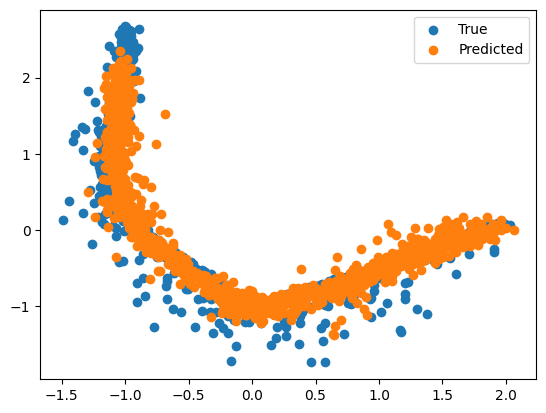

In [22]:
plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = model.predict(x_train)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

10/10 [==============================] - 0s 2ms/step


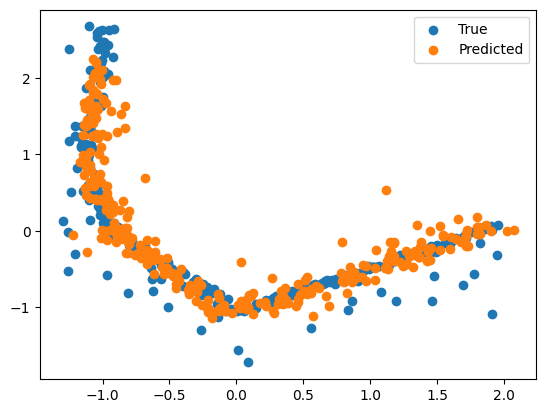

In [23]:
plt.scatter(y_test[:, 0], y_test[:, 1], label="True")
pred = model.predict(x_test)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()